# Exercise Sheet 6: Autoencoder

In [1]:
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import random
import time

# Import PyTorch
import torch 
import torch.nn as nn

# Load FashionMNIST dataset
from torchvision import datasets, transforms

# import own module 
#from network import Autoencoder, ConvAutoencoder, add_white_noise, to_img

# set figure size
plt.figure(figsize=(10, 5))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

<Figure size 1000x500 with 0 Axes>

In [2]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
EPOCHS = 50
EPOCHS_NOISE = 50
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
def to_img(x):
    """ Maps a 2D tensor from range [-1, 1] to 4D tensor with range [0, 1].
    Useful for plotting of reconstructions.

    :param x: 2D Tensor that is supposed to be converted
    :return: Converted 4D Tensor with b, c, w, h, where w = h = 28
    """
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def add_white_noise(x, factor=0.5, stddev=1):
    """ Adds white noise to an input tensor.
    To make sure that data is in intended range [min, max], use torch.clamp(x, min, max) after applying this function.

    :param x: ND Tensor that is altered
    :param factor: A factor that controls the strength of the additive noise
    :param stddev: The stddev of the normal distribution used for generating the noise
    :return: ND Tensor, x with white noise
    """
    # add white noise to tensor
    noise = torch.randn_like(x) * stddev
    return x + (noise * factor)


class Encoder(nn.Module):
    """Encoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.LeakyReLU(0.1), # selected Leaky ReLU activation function
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    """Decoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 784),
            nn.LeakyReLU(0.1),
            nn.Linear(784, input_shape[0] * input_shape[1]),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        return x

class Autoencoder(nn.Module):
    """ Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

class ConvEncoder(nn.Module):
    """ Convolutional Encoder network for the Autoencoder"""

    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(4), # added batch normalization
            nn.Conv2d(4, 8, kernel_size=5),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(8),
            nn.Flatten(),
            nn.Linear(3200, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class ConvDecoder(nn.Module):
    """ Convolutional Decoder network for the Autoencoder"""

    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.LeakyReLU(0.1),
            nn.Linear(400, 4000),
            nn.LeakyReLU(0.1),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class ConvAutoencoder(nn.Module):
    """ Convolutional Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(ConvAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        z = self.encoder(x)
        x = self.decoder(z)
        return x.view(-1, 1, self.input_shape[0], self.input_shape[1])

In [4]:

# Load FashionMNIST dataset & apply transformations for noisy and clean data
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Define a transform with noise to the data
transform_noise = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: add_white_noise(x, factor=0.5, stddev=1)),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform)
trainset_noise = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform_noise)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)


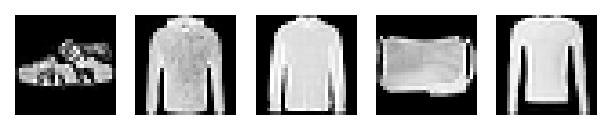

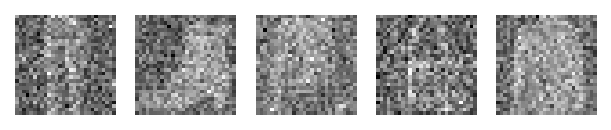

In [5]:
# Plot 5 training images for trainloader and trainloader_noise - no labels
# Set the number of images to plot
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (clean)')
dataiter = iter(trainloader)
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter).to(device)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from trainloader_noise
dataiter_noise = iter(trainloader_noise)  # Create an iterator for trainloader_noise
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (noisy)')
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter_noise).to(device)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from testloader
plt.title('FashionMNIST images (random samples)')
plt.show()

### Task 1: Implement a Linear Autoencoder 

In [6]:
# 1.1 Implement a fully-connected autoencoder using the class torch.nn.Module2 from pytorch. Use the provided starter code as a template
autoencoder = Autoencoder().to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): LeakyReLU(negative_slope=0.1)
      (8): Linear(in_features=16, out_features=8, bias=True)
      (9): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=64, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Linear(in_features=128, out_features=784, bias=True)
      (7): L

In [7]:
def plot_samples(samples, path='img.png', figsize=(15, 6)):
    """ Plot 10 samples with their reconstructions """
    n_samples = len(samples)
    fig, axes = plt.subplots(2, n_samples, figsize=figsize) 
    axes = axes.flatten()
    fig.suptitle('Input Samples and their Reconstructions')

    for i, (input_img, reconstructed_img) in enumerate(samples):
        # Plot the input image
        axes[i].imshow(input_img.numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Input Image {i+1}', fontsize=7)

        # Plot the reconstructed image
        axes[i+n_samples].imshow(reconstructed_img.numpy().squeeze(), cmap='gray')
        axes[i+n_samples].axis('off')
        axes[i+n_samples].set_title(f'Reconstructed Image {i+1}', fontsize=7)

    plt.subplots_adjust(wspace=0.1) 
    plt.savefig(path)
    plt.show()

In [8]:
# 1.2 Use the mean squared error3 to implement the reconstruction error of the autoencoder.
def train(model, train_loader, optimizer, criterion, noise=False, device='cpu'):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs = inputs.to(device)

        # add noise to the inputs
        if noise:
            # mean square error with tanh activation in output - values are restricted to range [-1, 1]
            inputs_= torch.clamp(inputs, -1, 1)
        else:
            inputs_ = inputs

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs_)

        # calculate loss
        loss = criterion(outputs, inputs)
        loss.backward()

        # update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_loader)


In [9]:
criterion = nn.MSELoss() # MSE loss

In [10]:
# 1.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128. 
# -- Run it for at least 50 epochs.
lr = 0.001
weight_decay = 1e-5

# create optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(autoencoder, trainloader, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')


Epoch 1/3, Loss: 0.1575, Time: 5.61 sec
Epoch 2/3, Loss: 0.0889, Time: 5.36 sec
Epoch 3/3, Loss: 0.0811, Time: 5.25 sec


In [11]:
def plot_latent(autoencoder, data, num_batches=64, path='latent.png', figsize=(4, 3)):
    plt.figure(figsize=figsize)  # set the figure size
    
    # plot latent space as scatter plot
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    # show plot
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space')
    plt.savefig(path)
    plt.show()

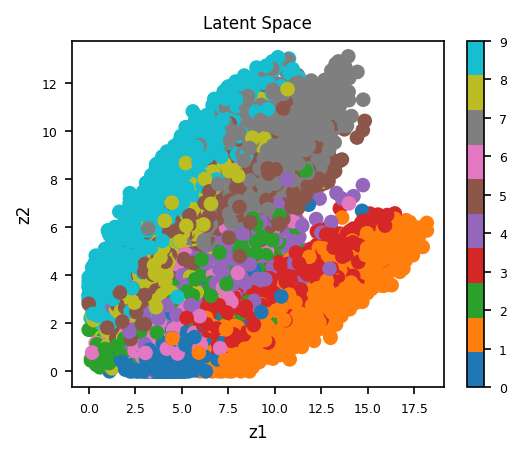

In [12]:
# Plot the latent space
plot_latent(autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent.png')

In [13]:
# Report the training and validation loss of the autoencoder every ten epochs.
def plot_loss(train_losses, test_losses, label='Loss curve',figsize=(5, 4), path='loss.png'):
    """ Plot test and training loss into the same plot """
    
    plt.figure(figsize=figsize)  # set the figure size
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.savefig(path)
    plt.show()

In [14]:
# 1.4 During the computation of the testing loss plot ten input samples as well as their reconstructions produced by the autoencoder

def test(model, test_loader, criterion, device='cpu', model_name='autoencoder'):
    model.eval()
    running_loss = 0.0
    samples = [] 

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, _ = data
            inputs = inputs.to(device)

            # forward pass
            outputs = model(inputs)

            # calculate loss
            loss = criterion(outputs, inputs)
            running_loss += loss.item()

            # store the first image from each batch
            inputs = inputs[0].view(1, 1, 28, 28)
            outputs = outputs[0].view(1, 1, 28, 28)
            inputs = to_img(inputs)
            outputs = to_img(outputs)
            samples.append((inputs.cpu(), outputs.cpu()))

            # every 10 batches plot input samples + reconstructions
            if (i+1) % 10 == 0:
                # plot samples
                plot_samples(samples, path=f'{RESULTS_DIR}{model_name}_{i}.png')
                samples = []

    return running_loss / len(test_loader)

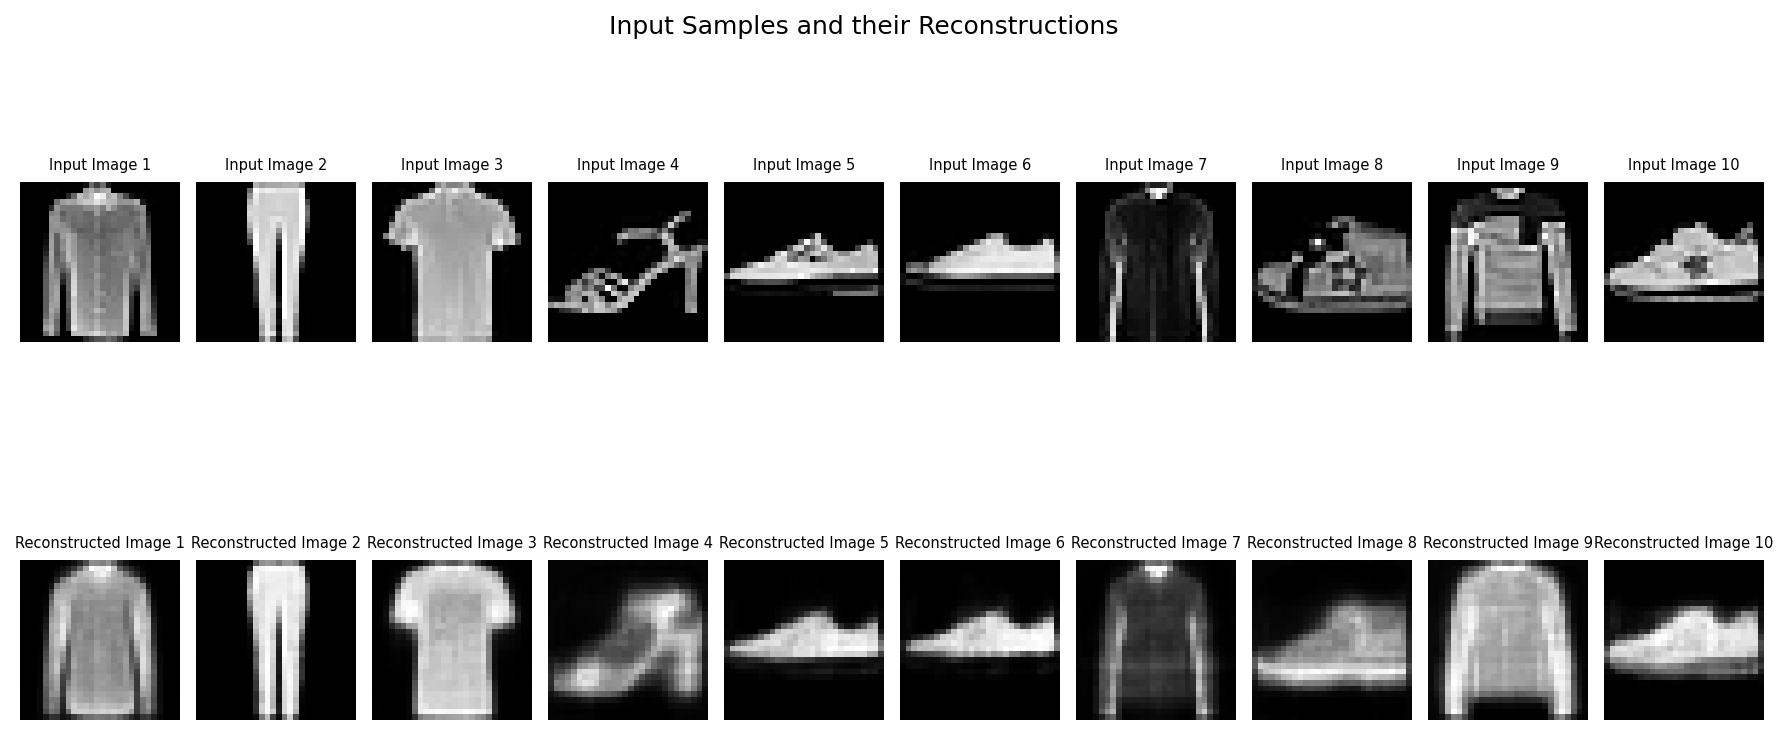

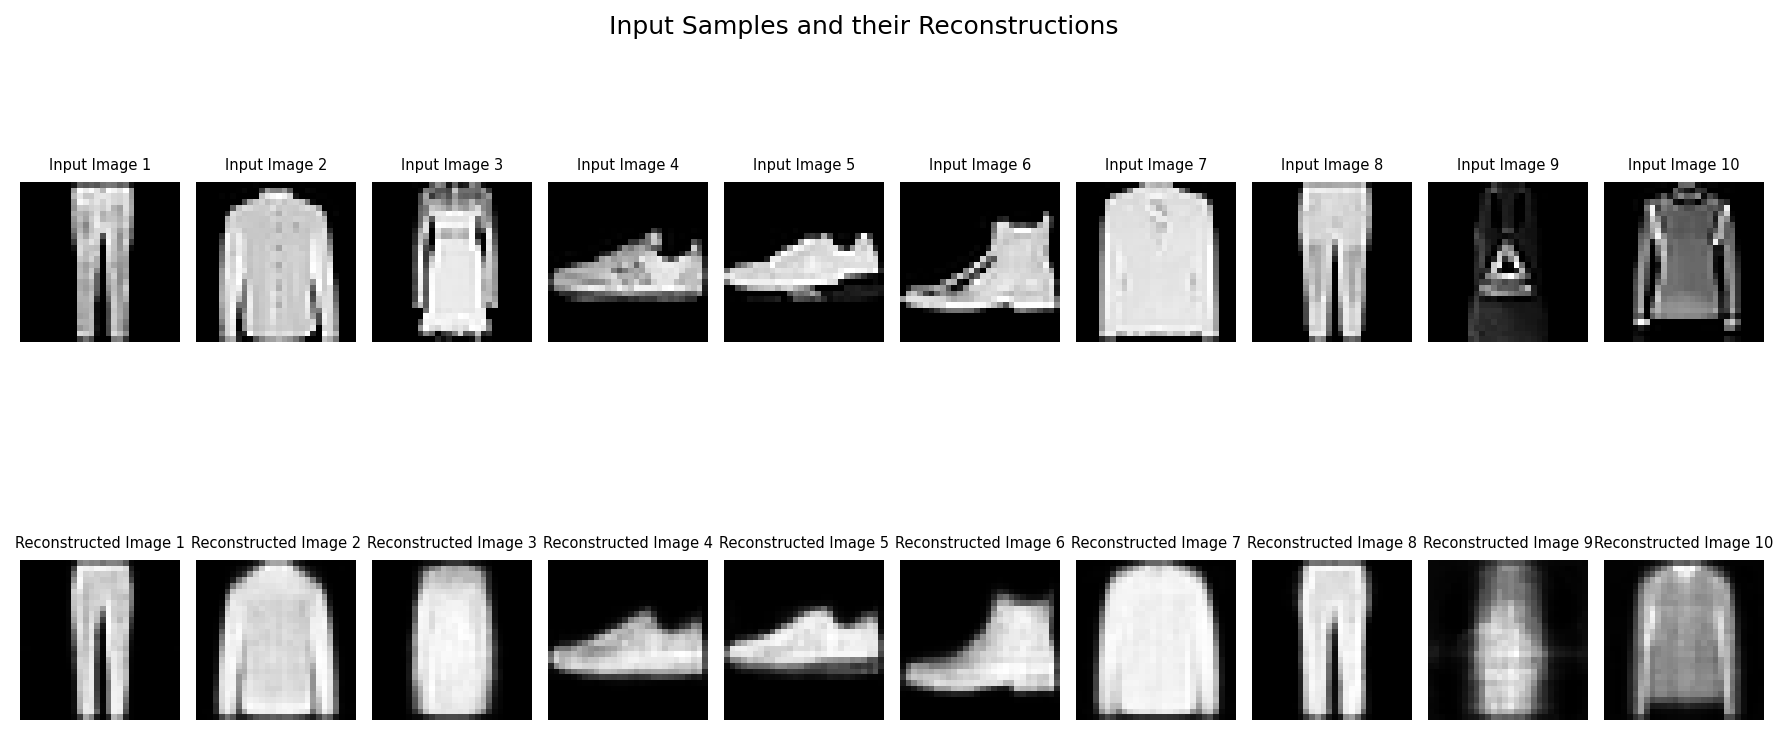

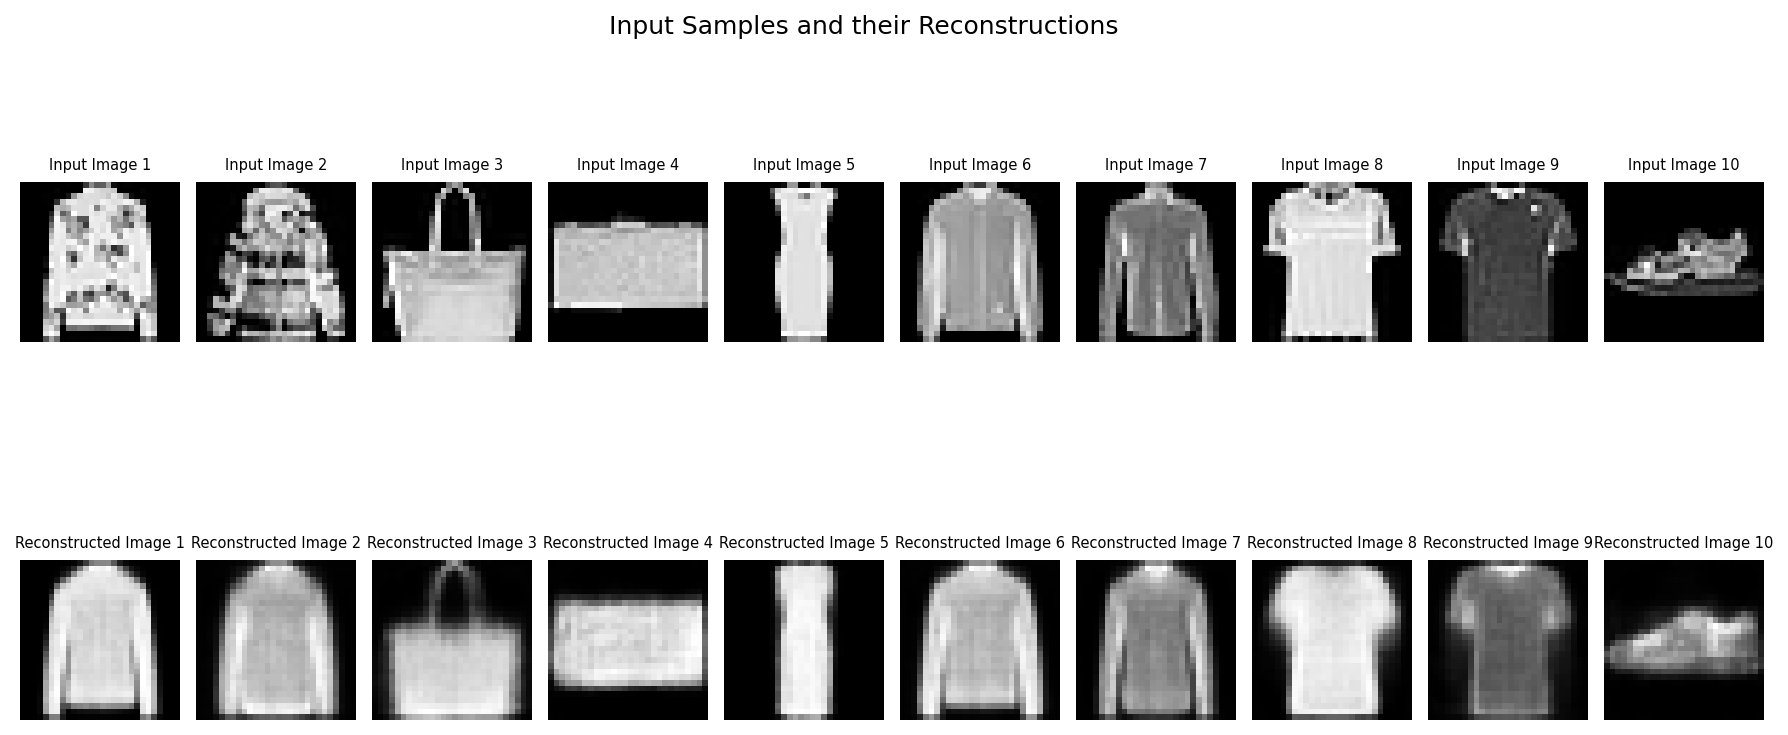

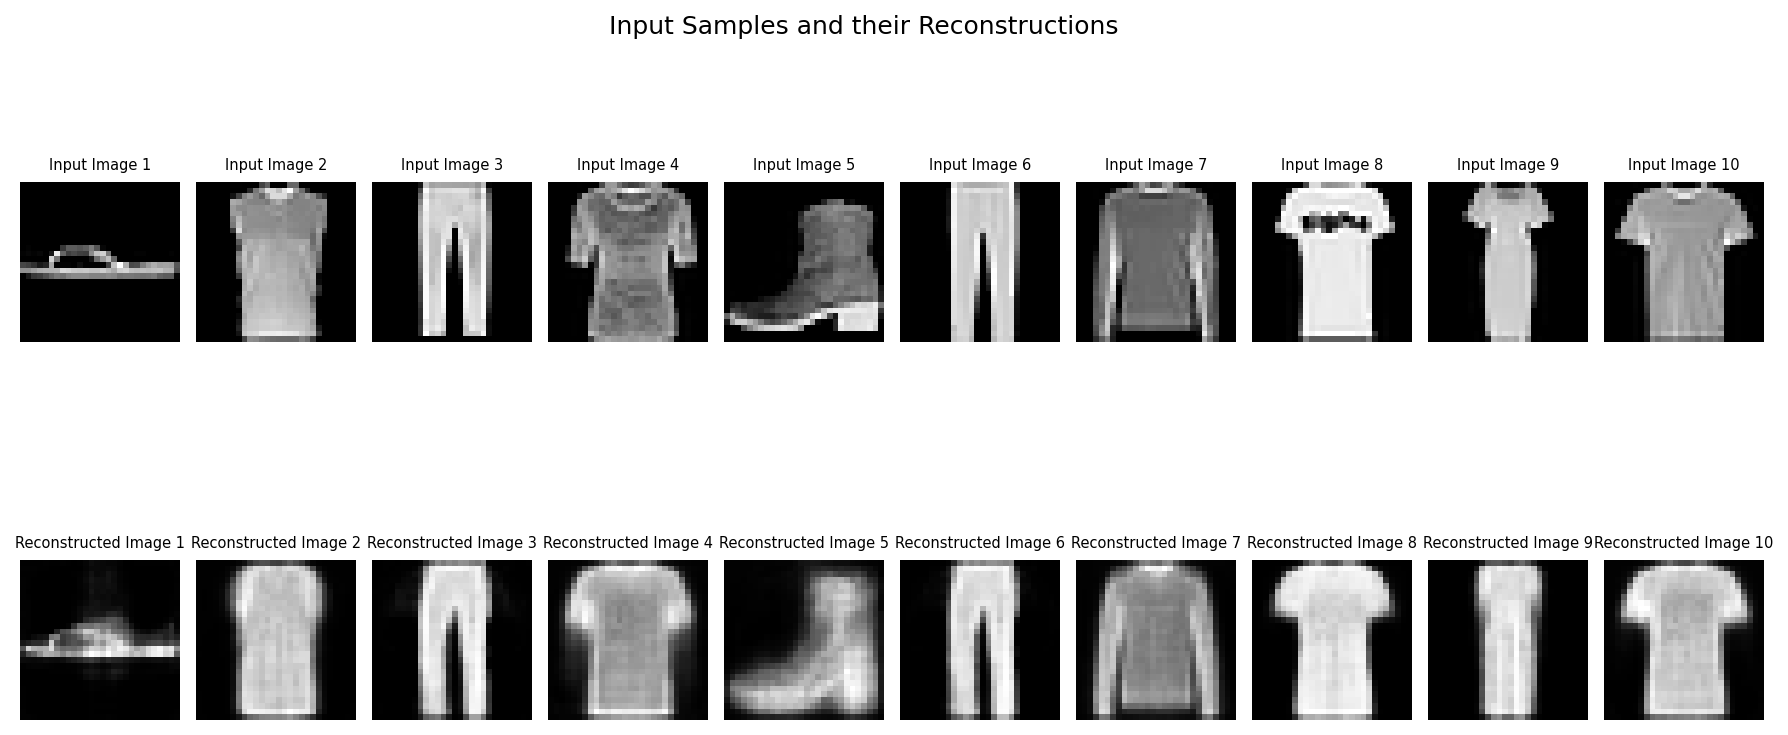

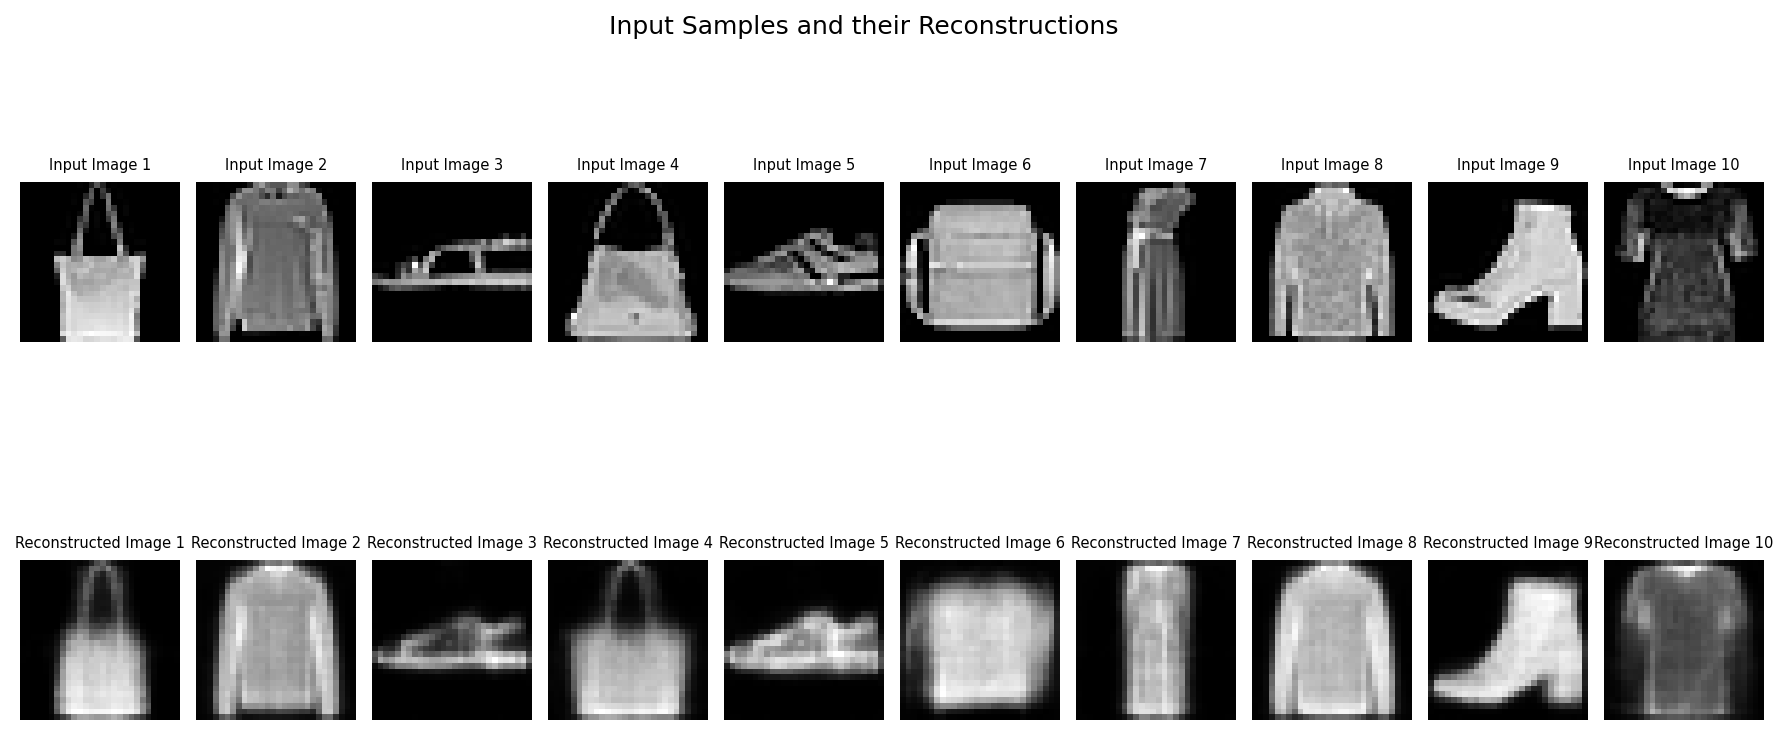

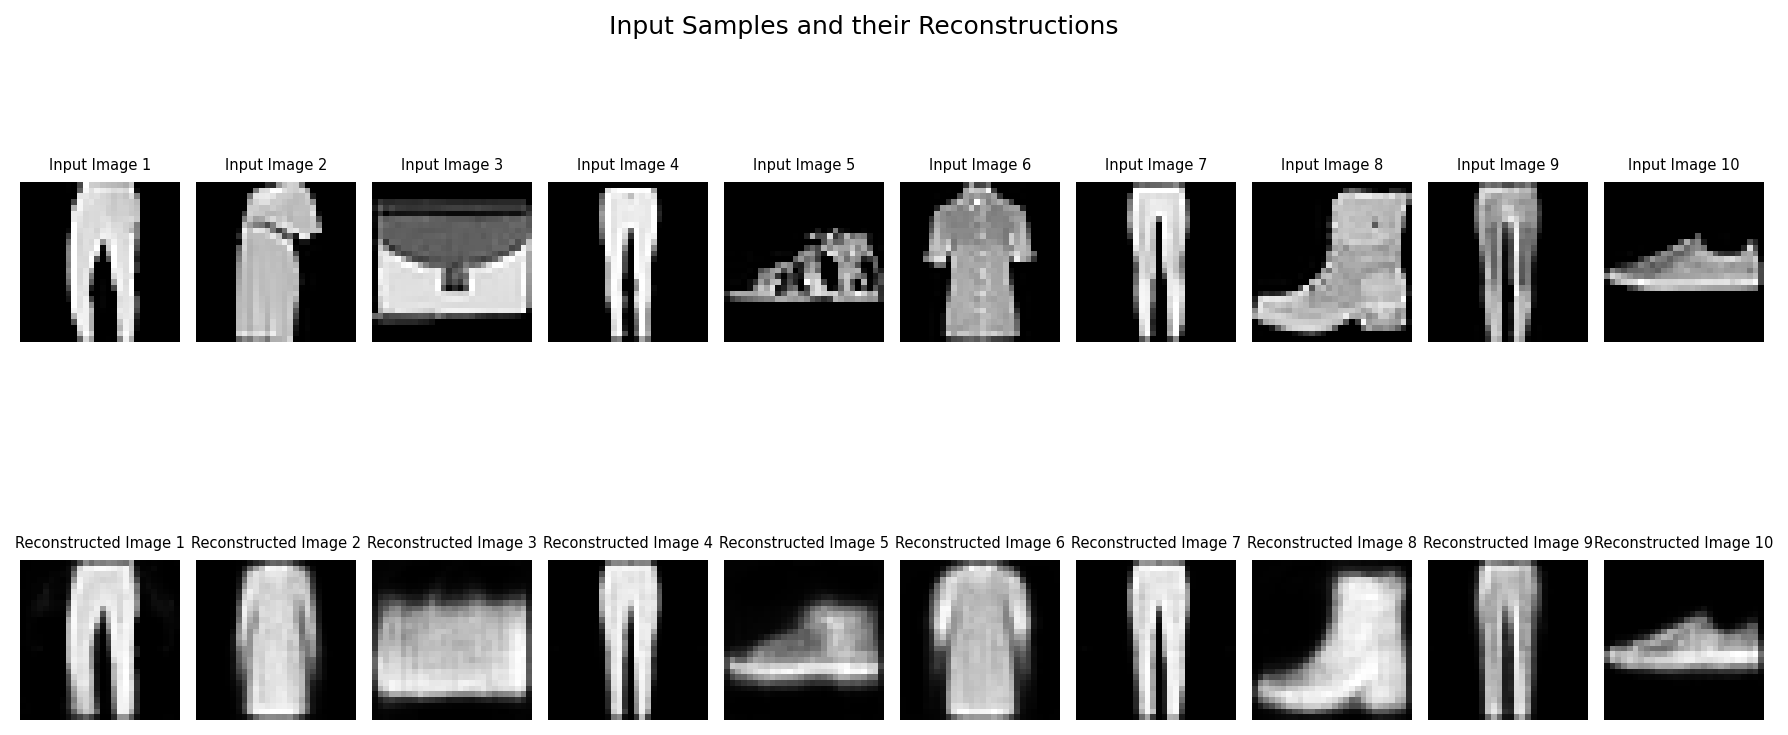

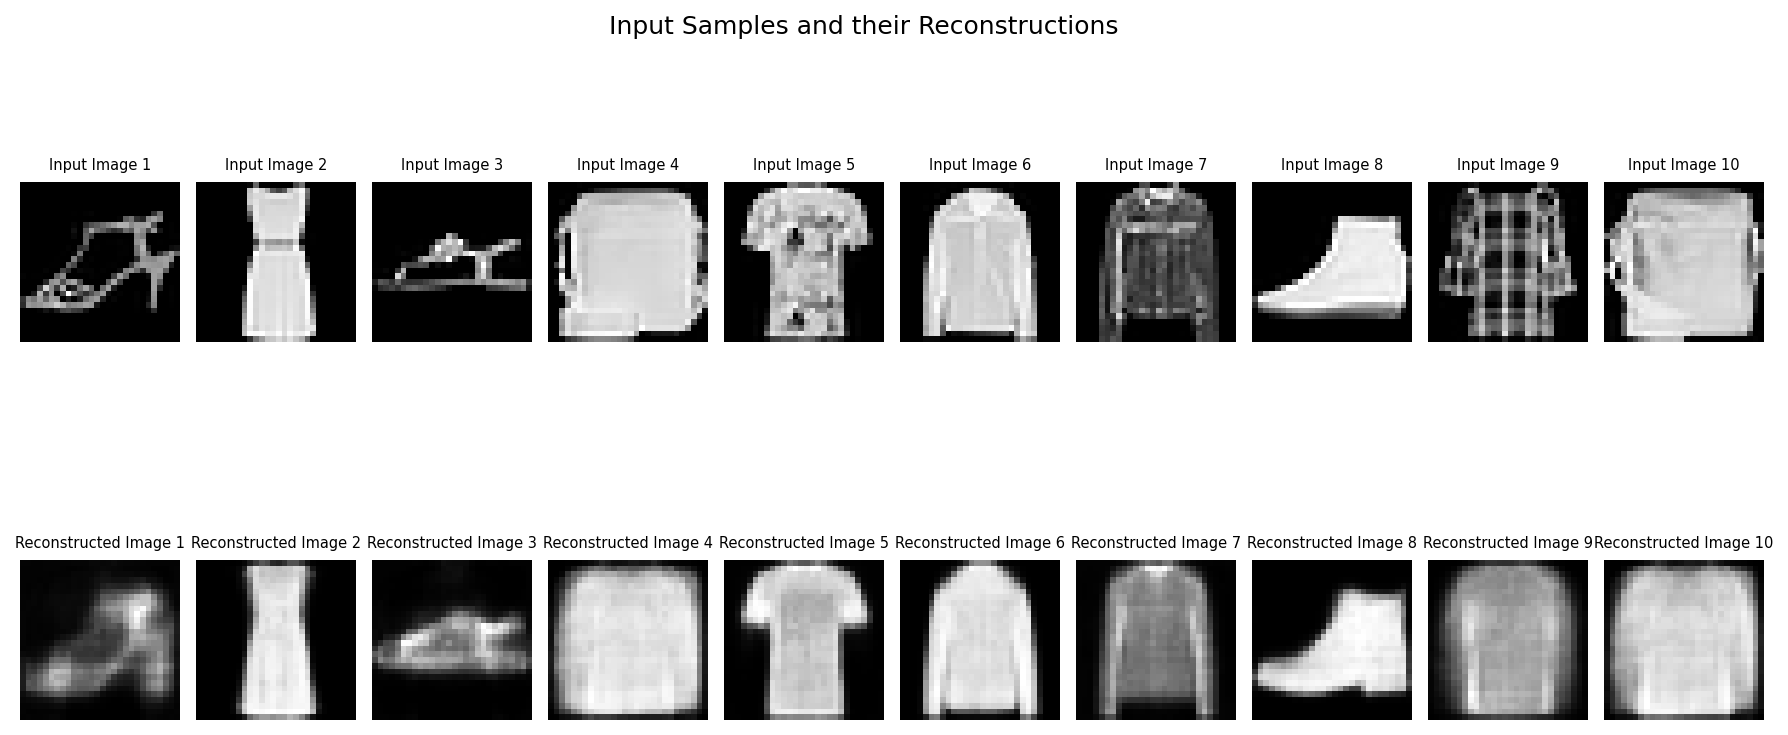

Epoch 1/3, Loss: 0.0784


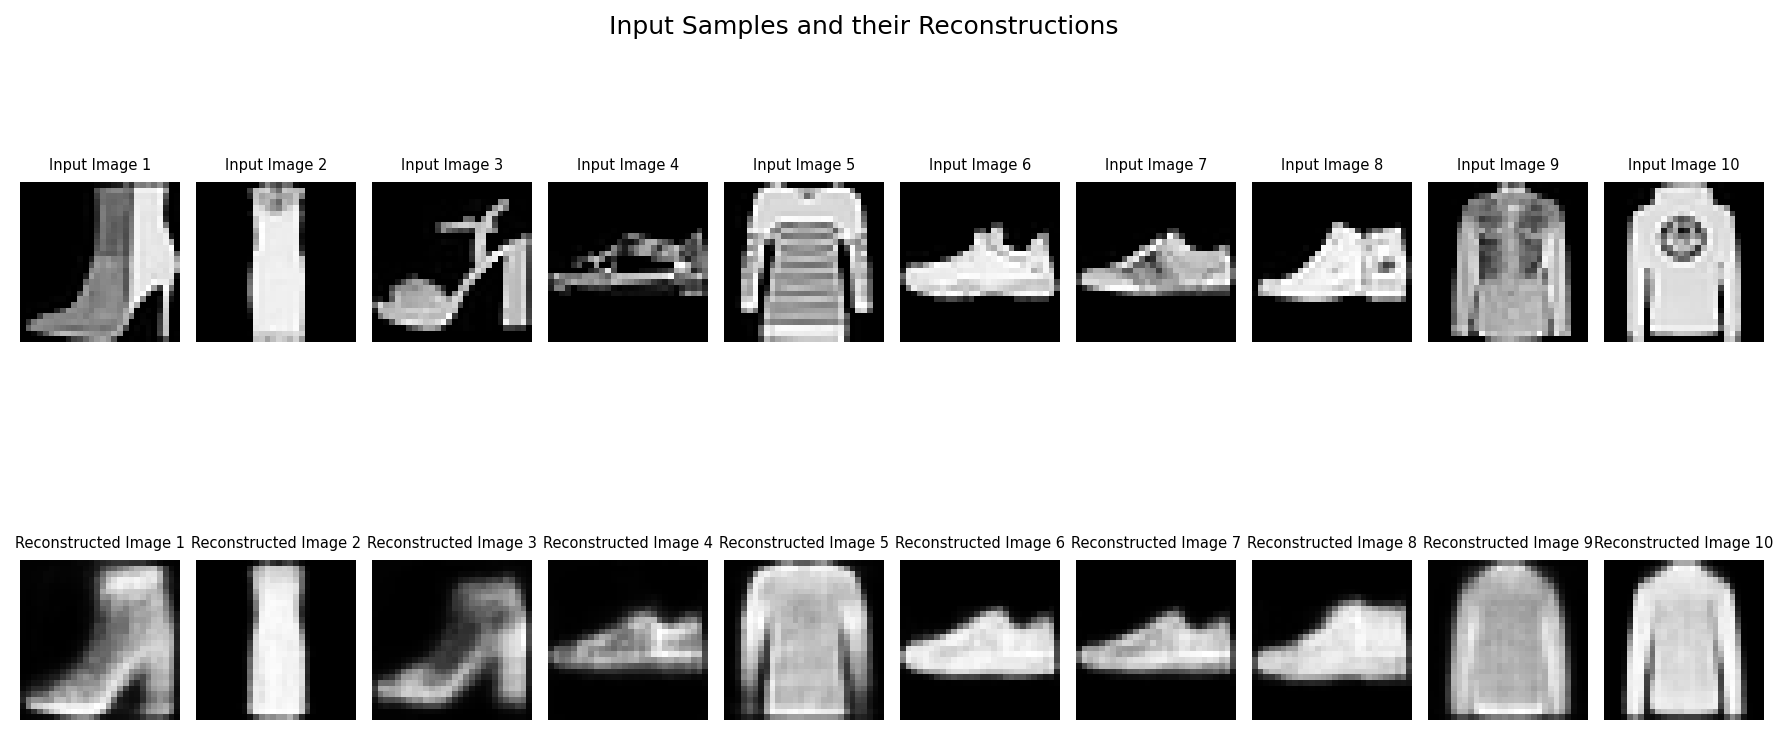

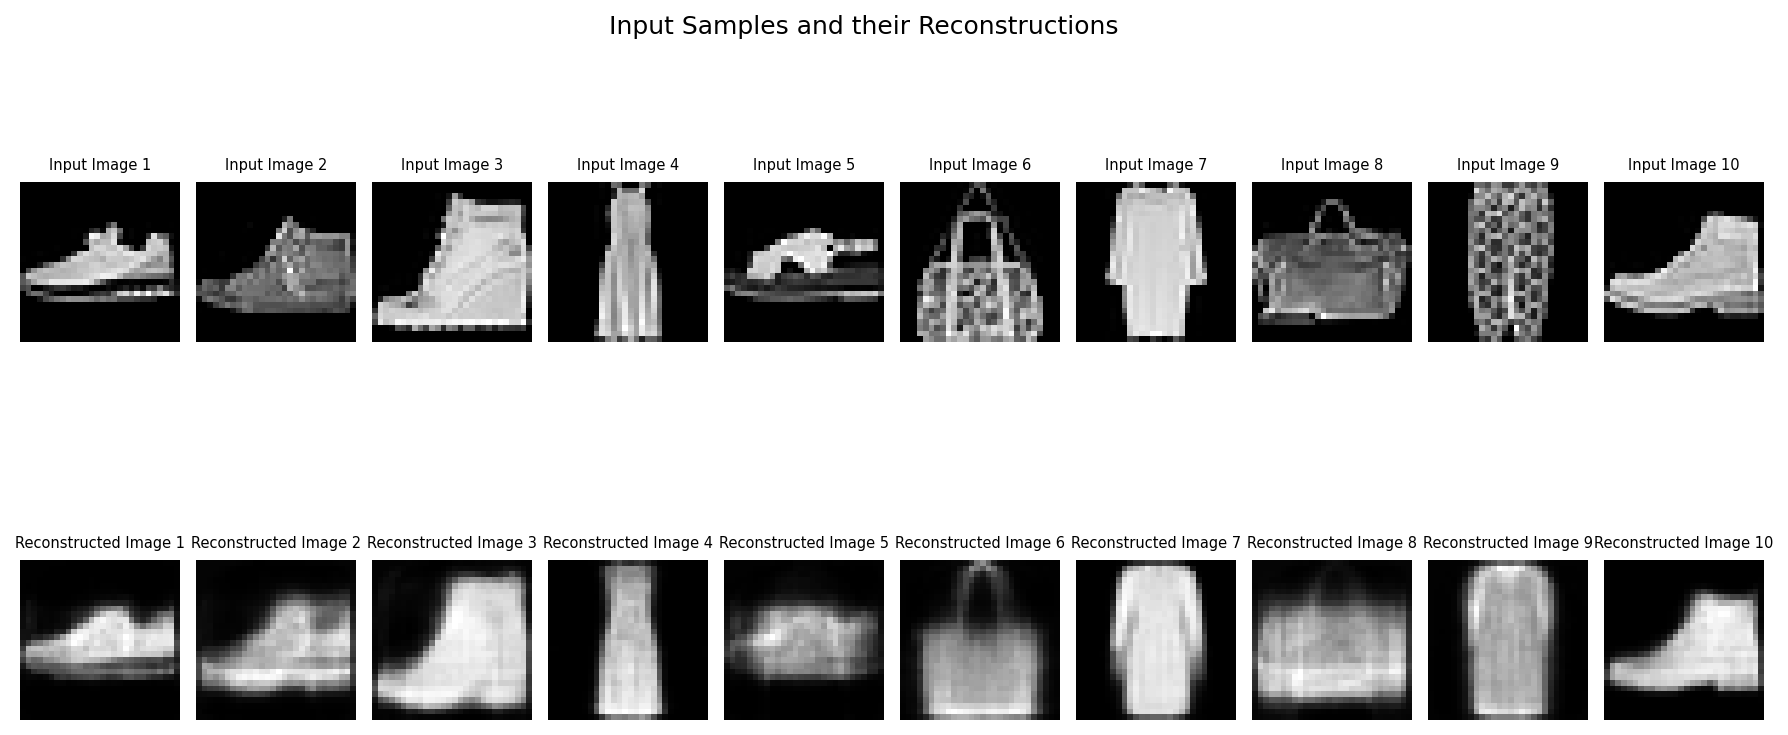

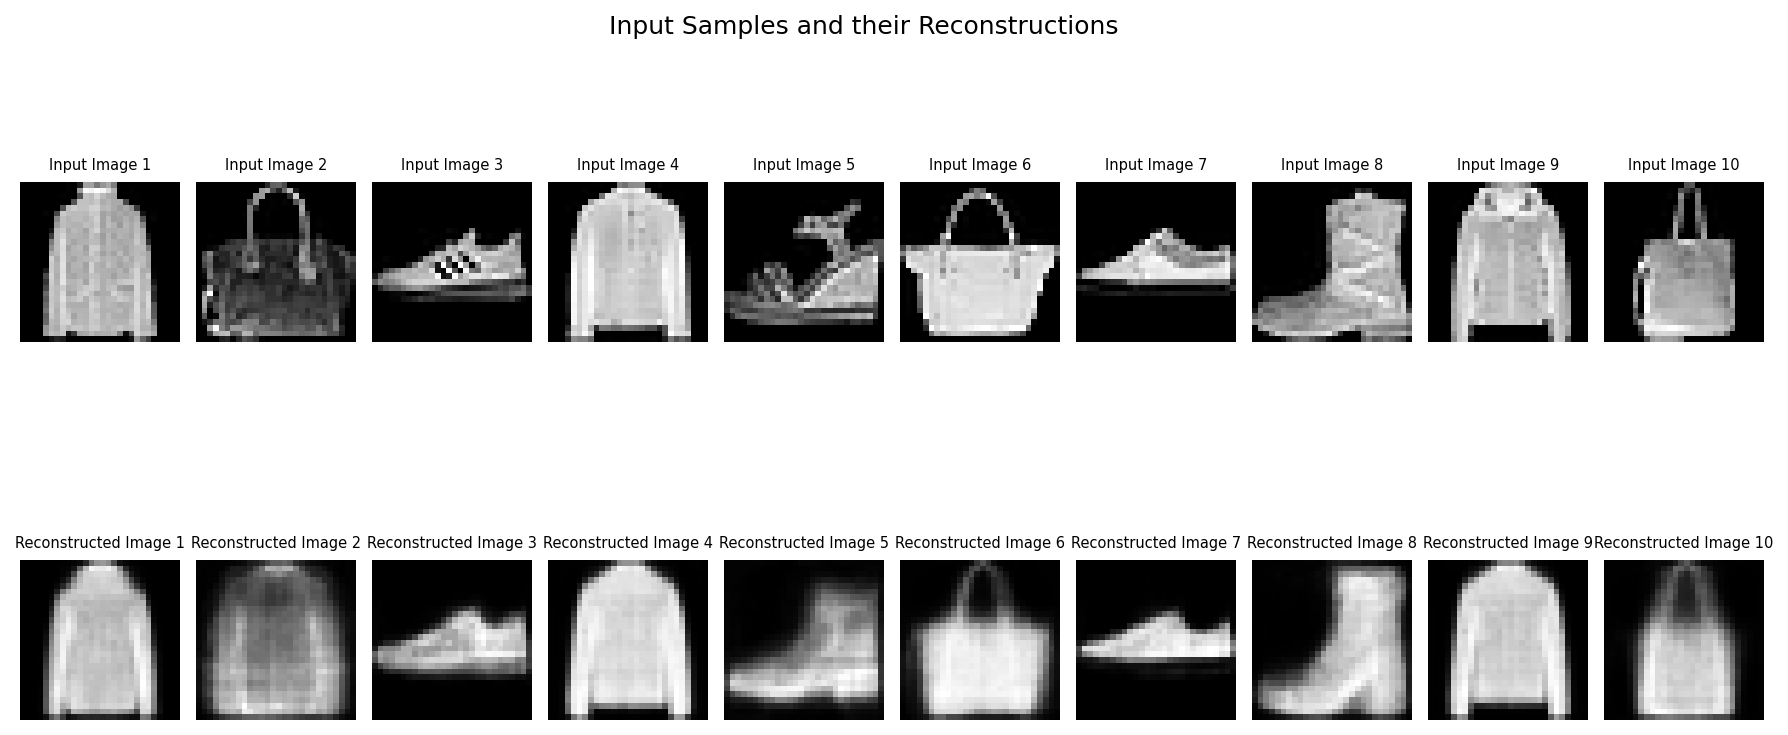

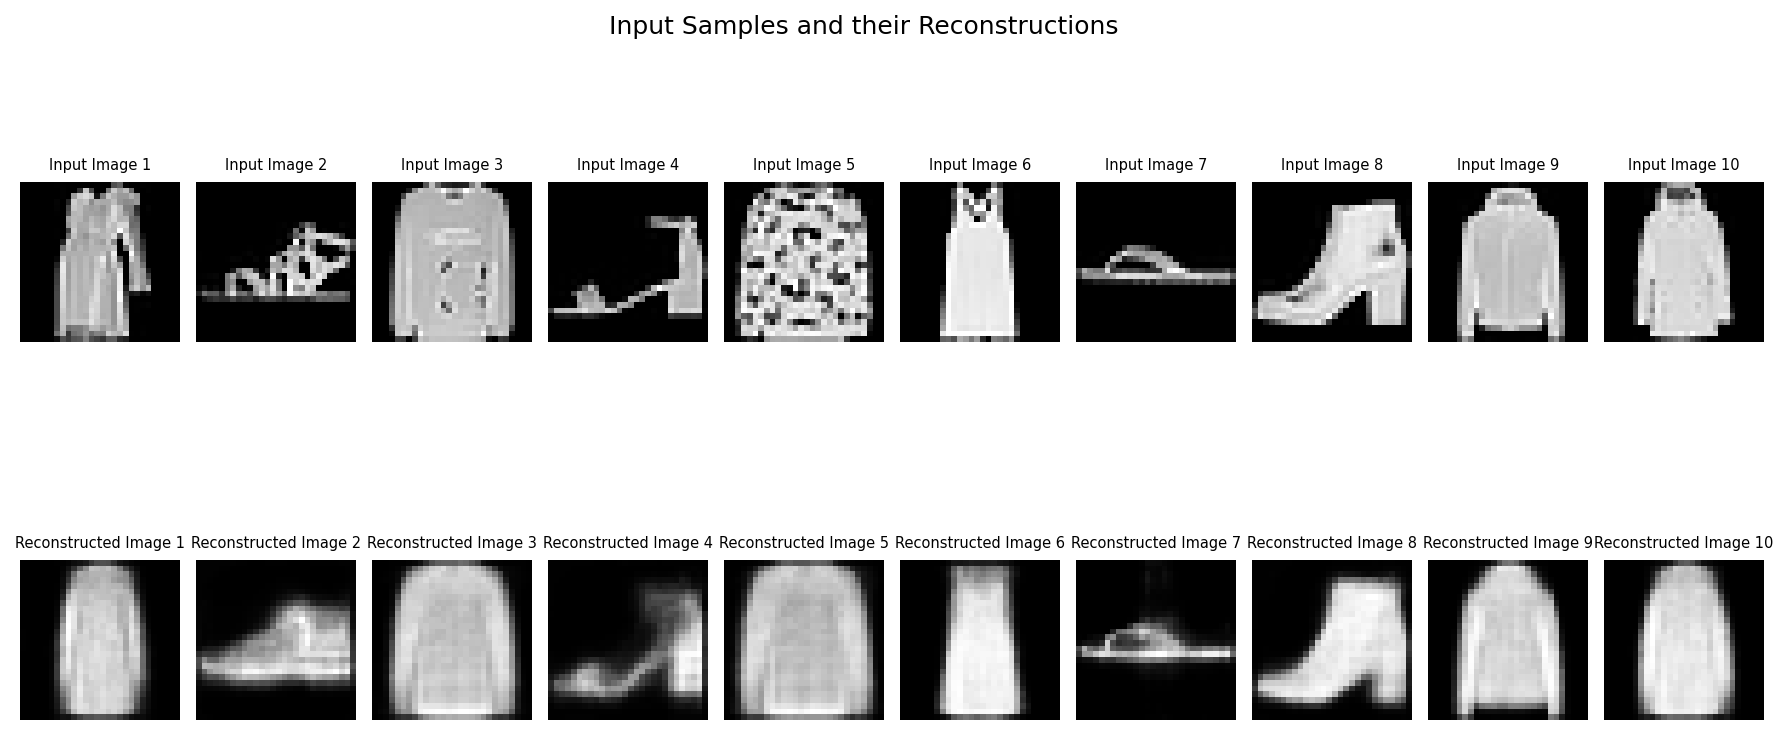

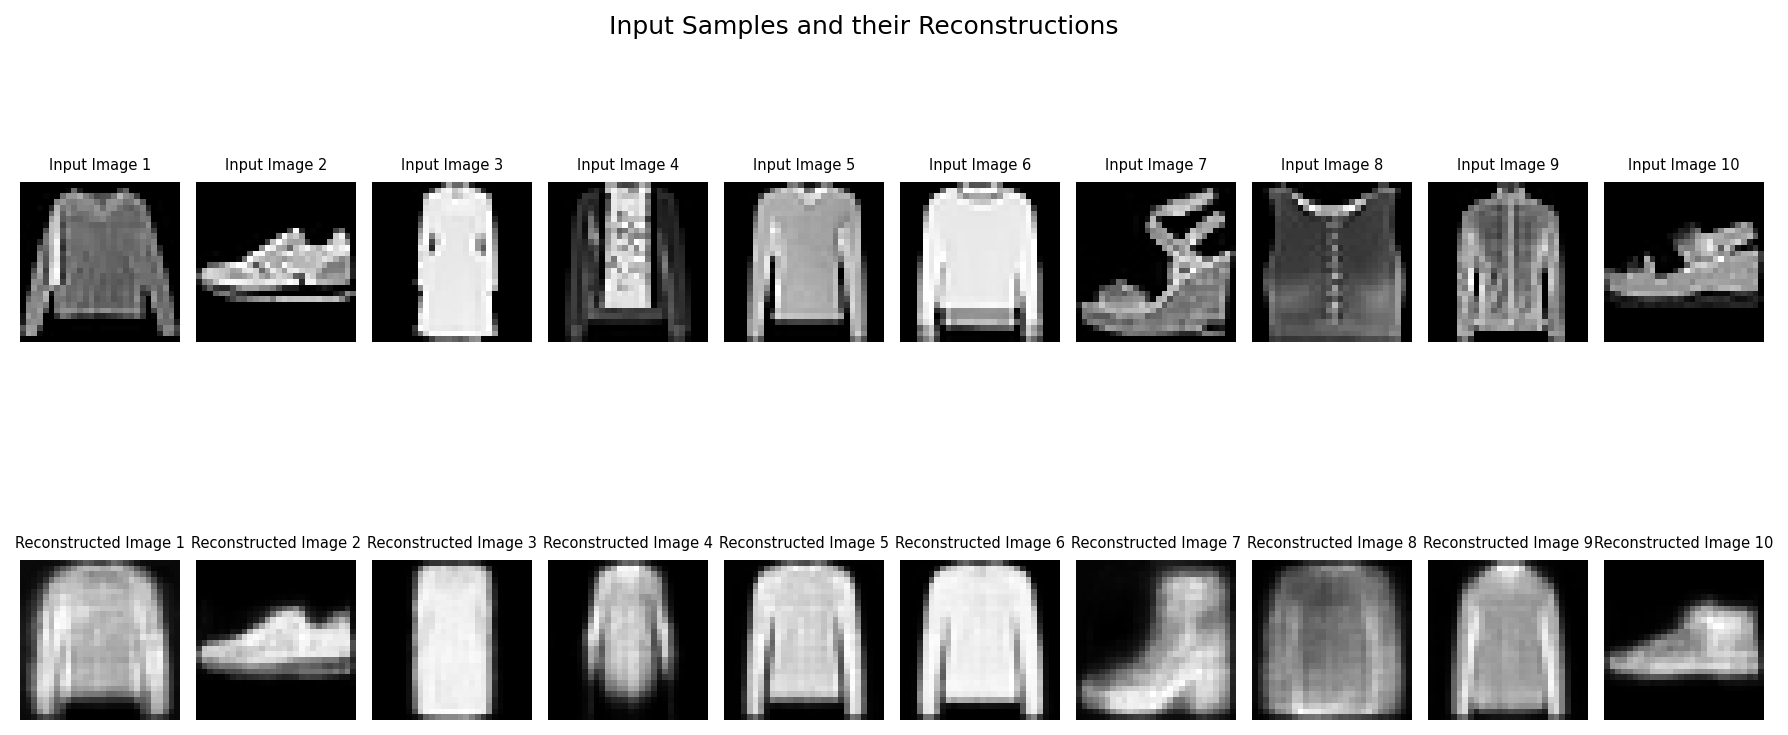

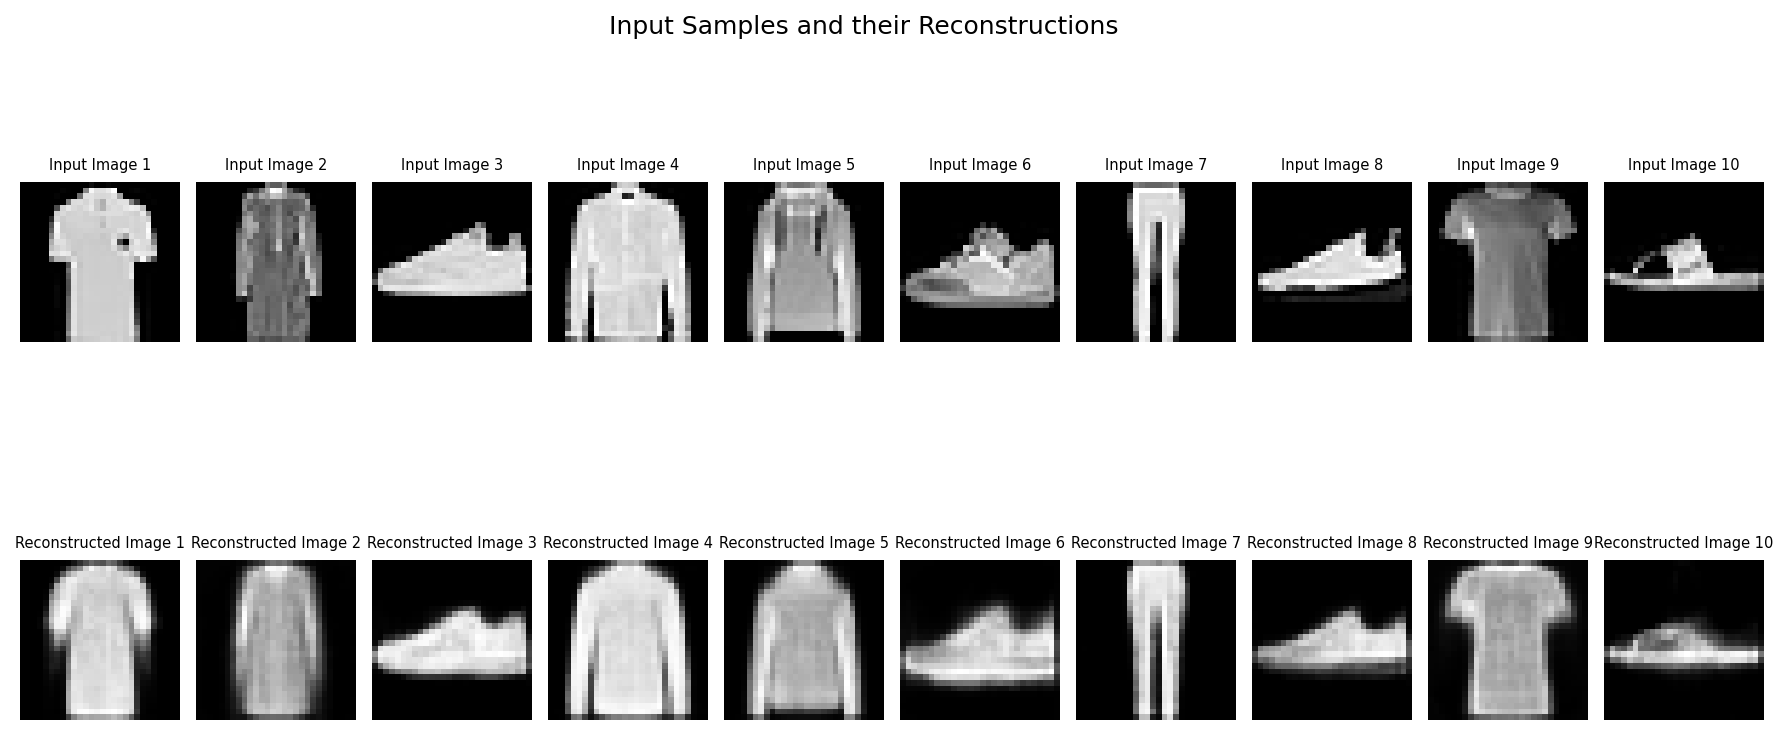

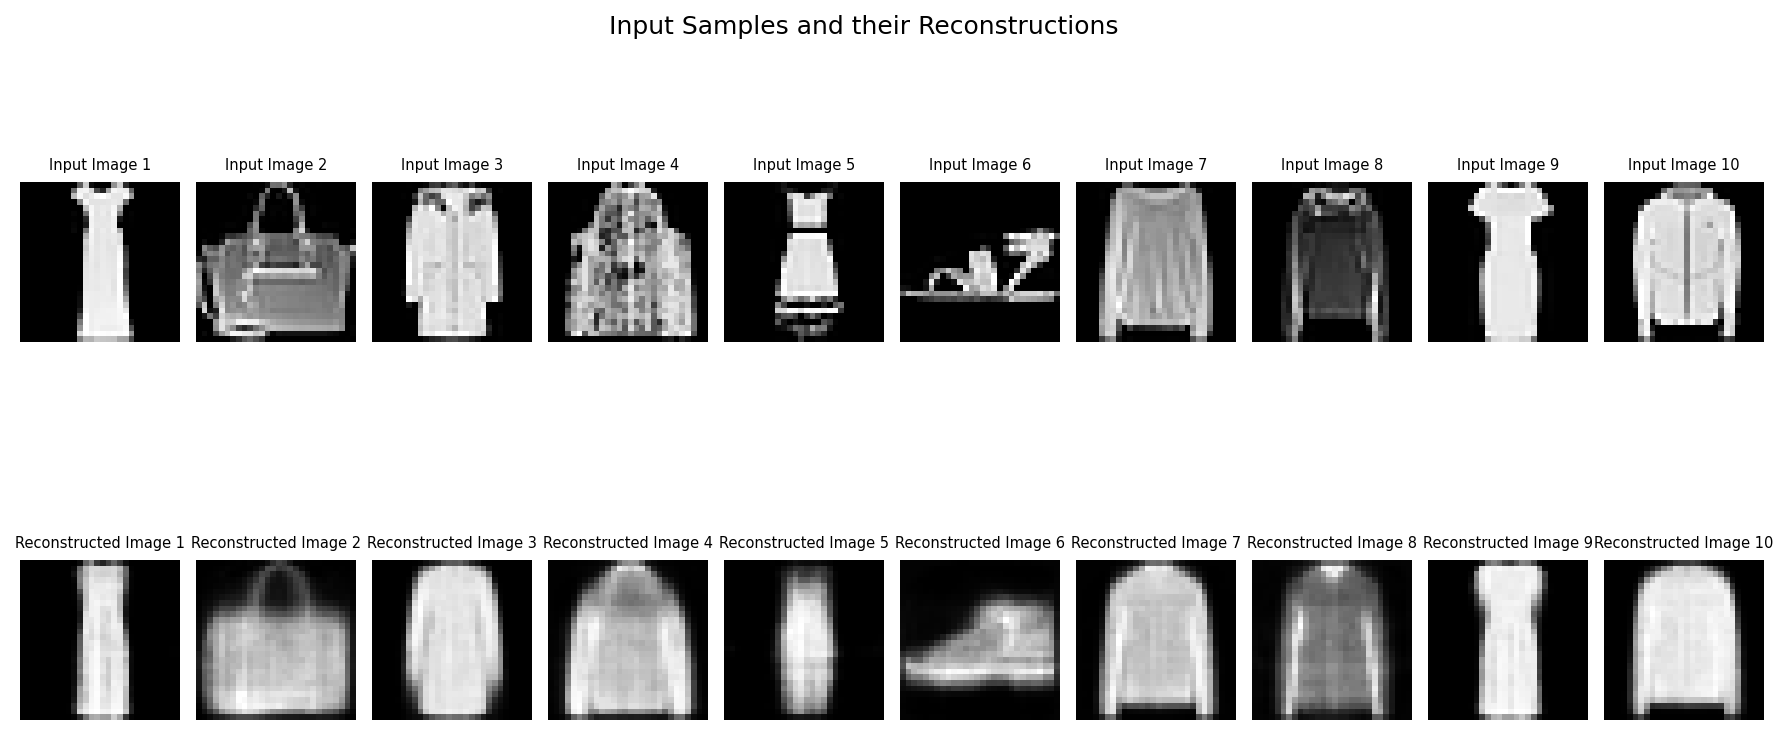

Epoch 2/3, Loss: 0.0785


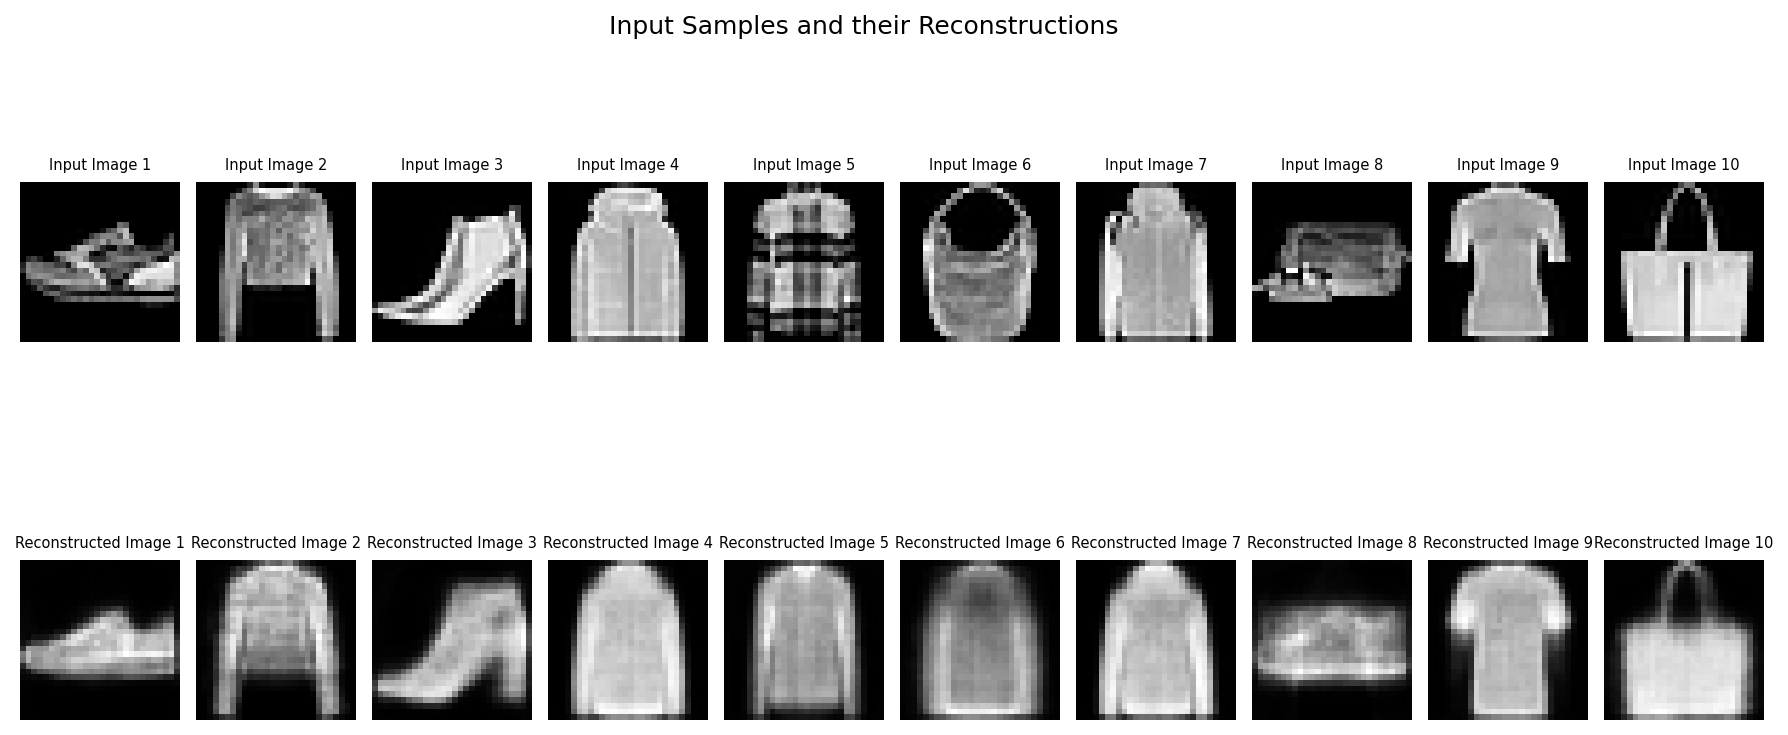

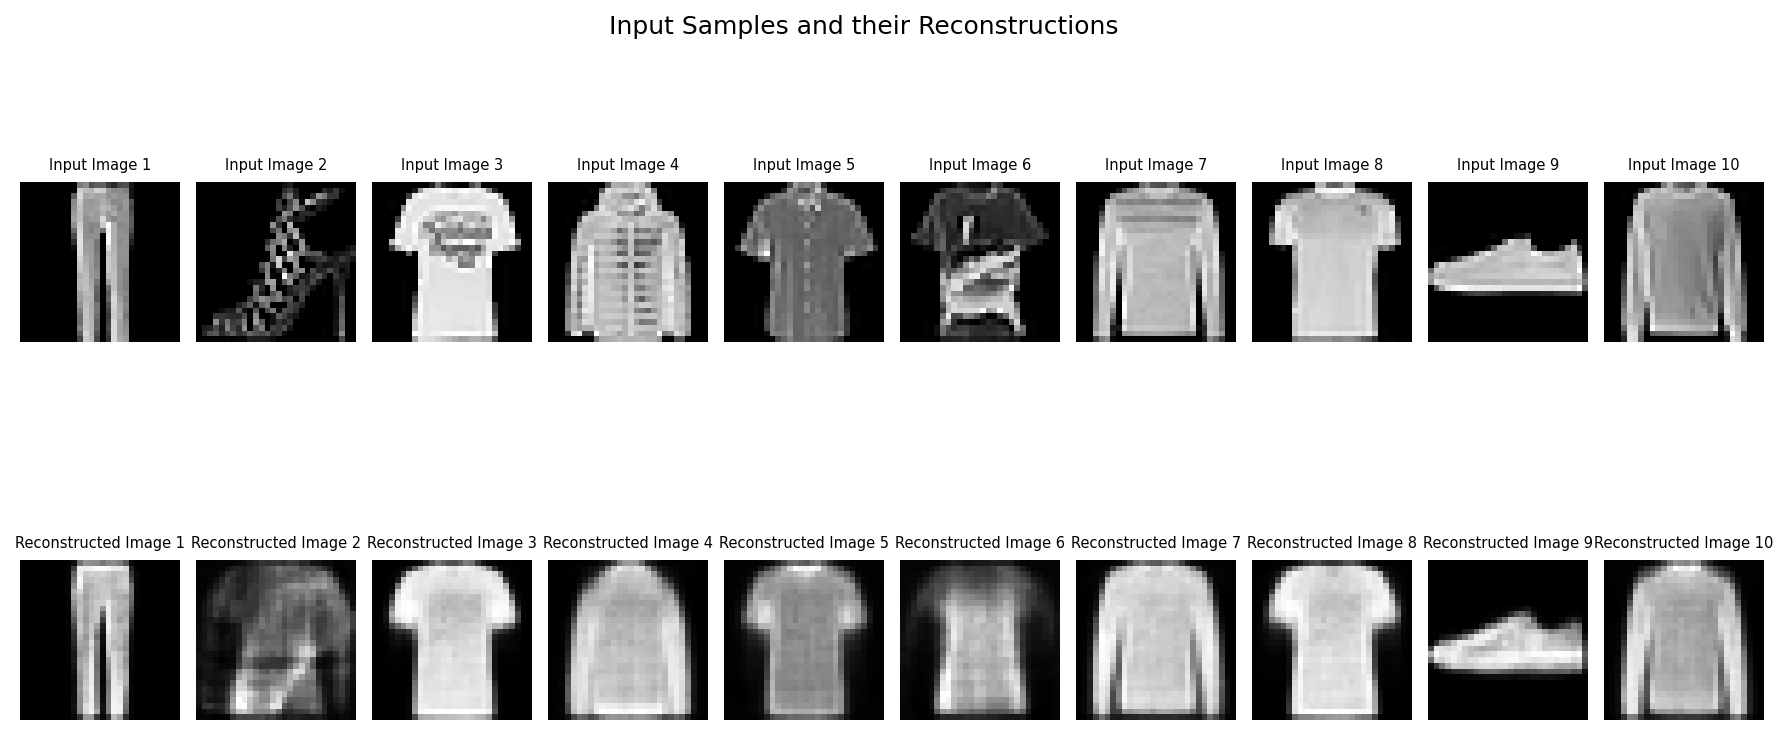

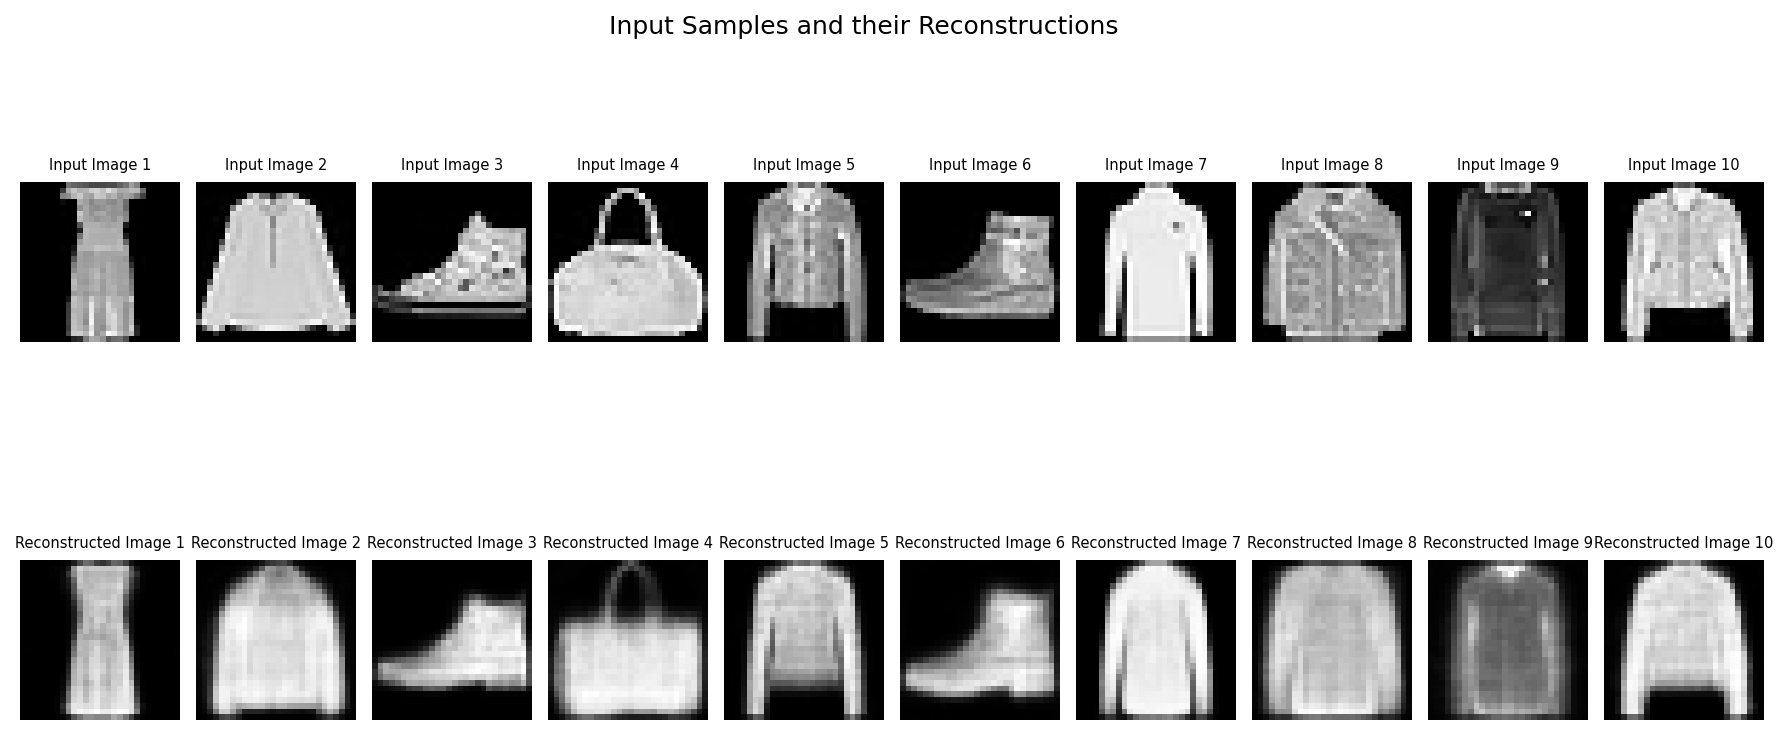

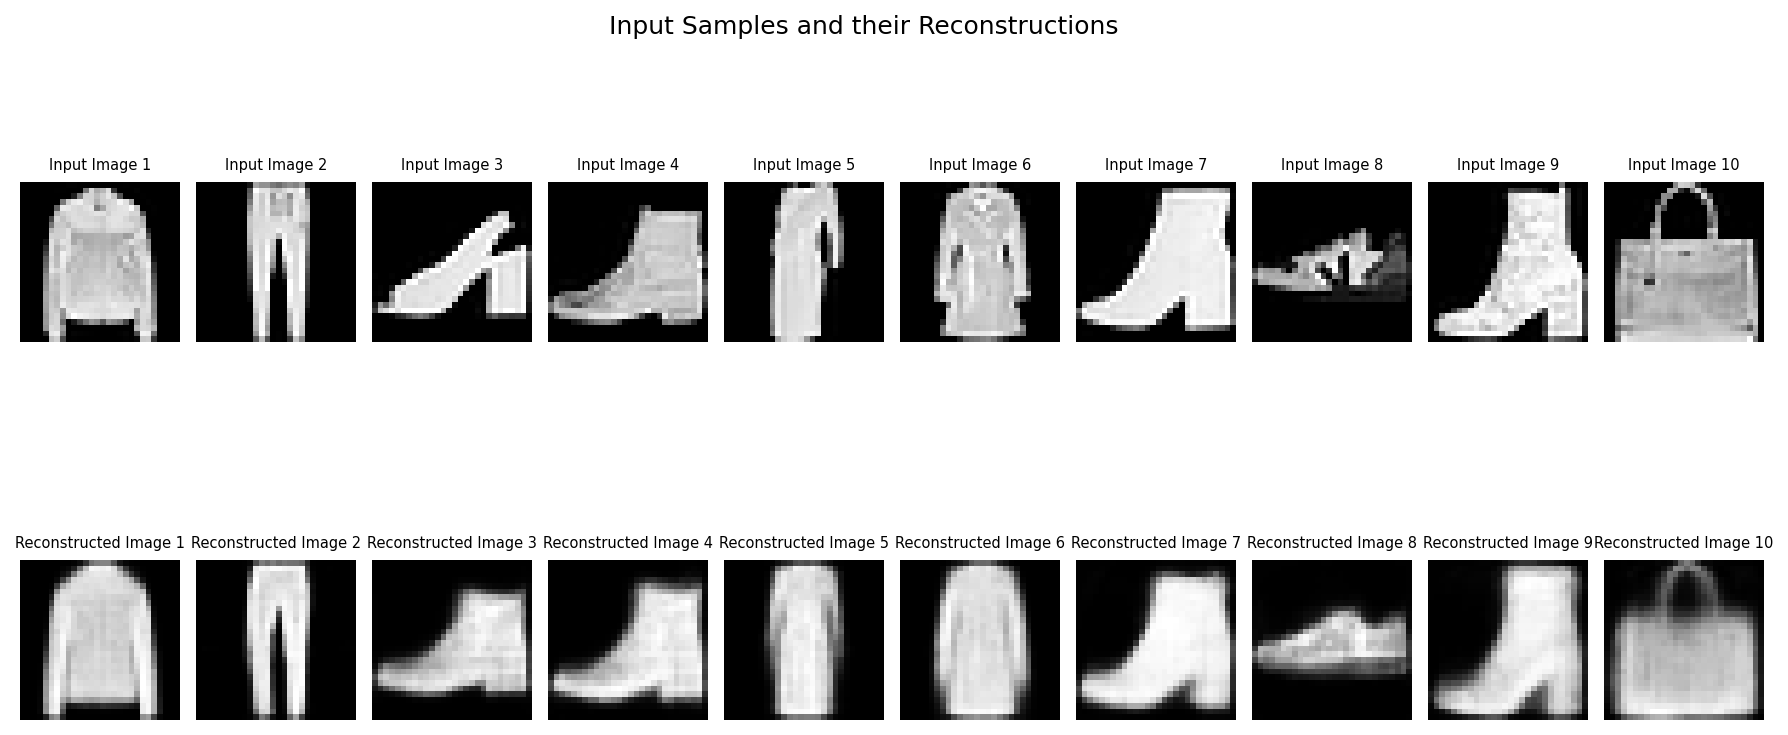

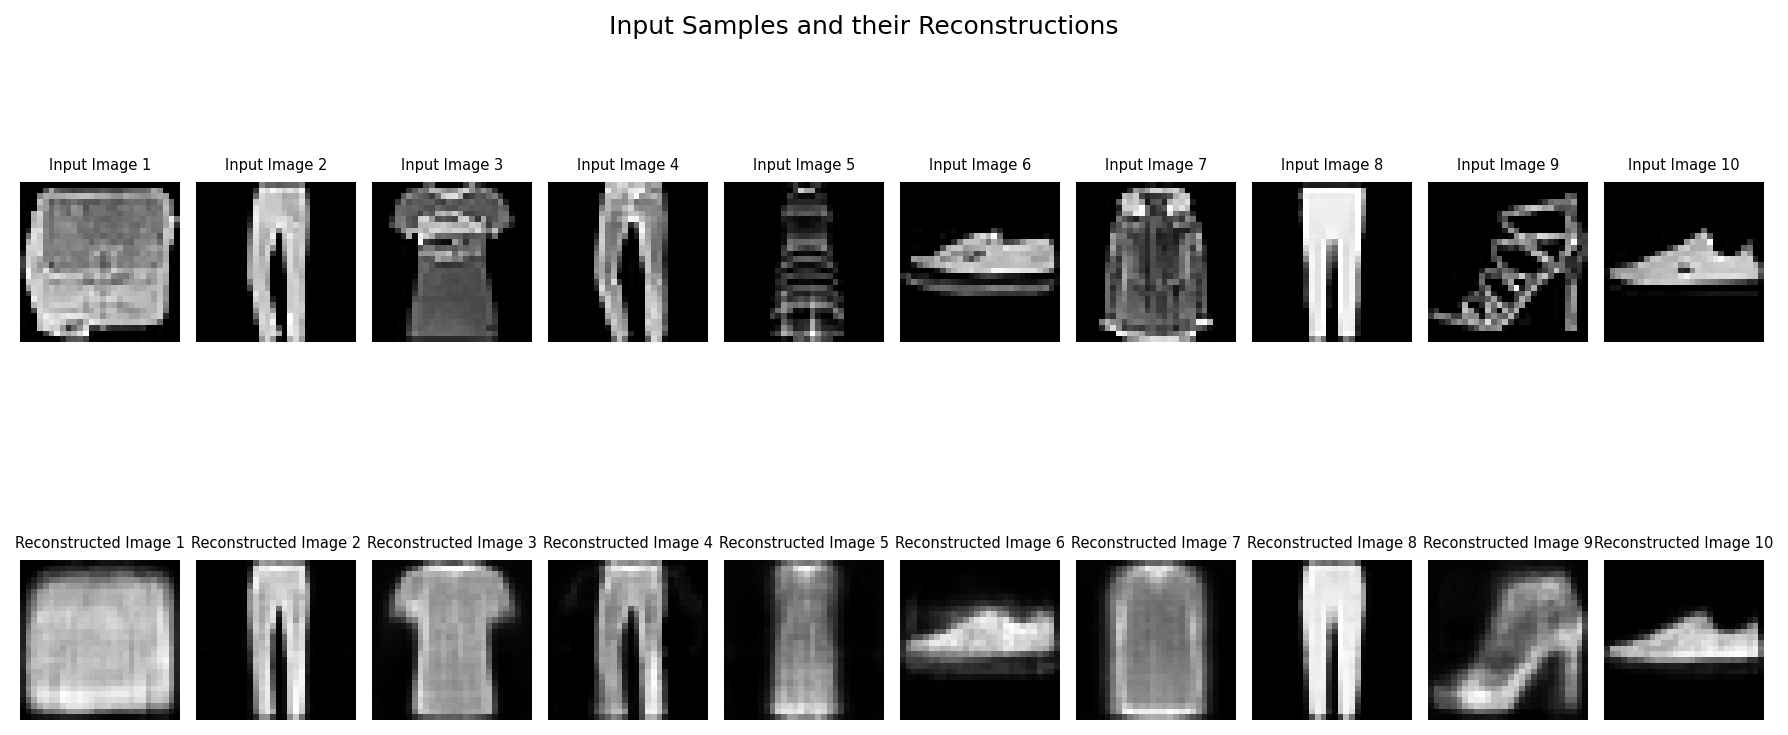

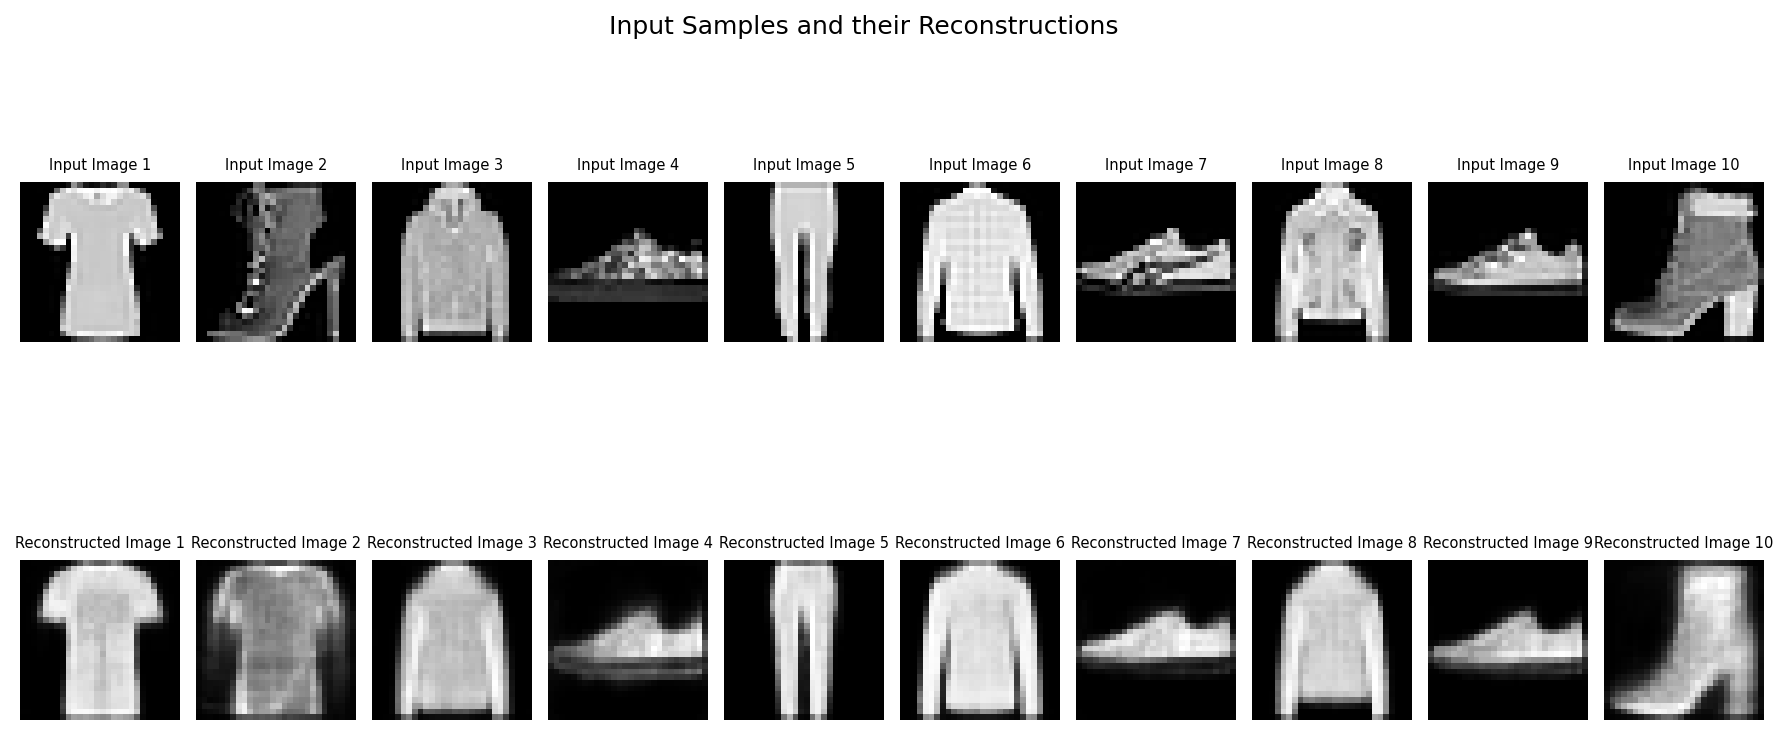

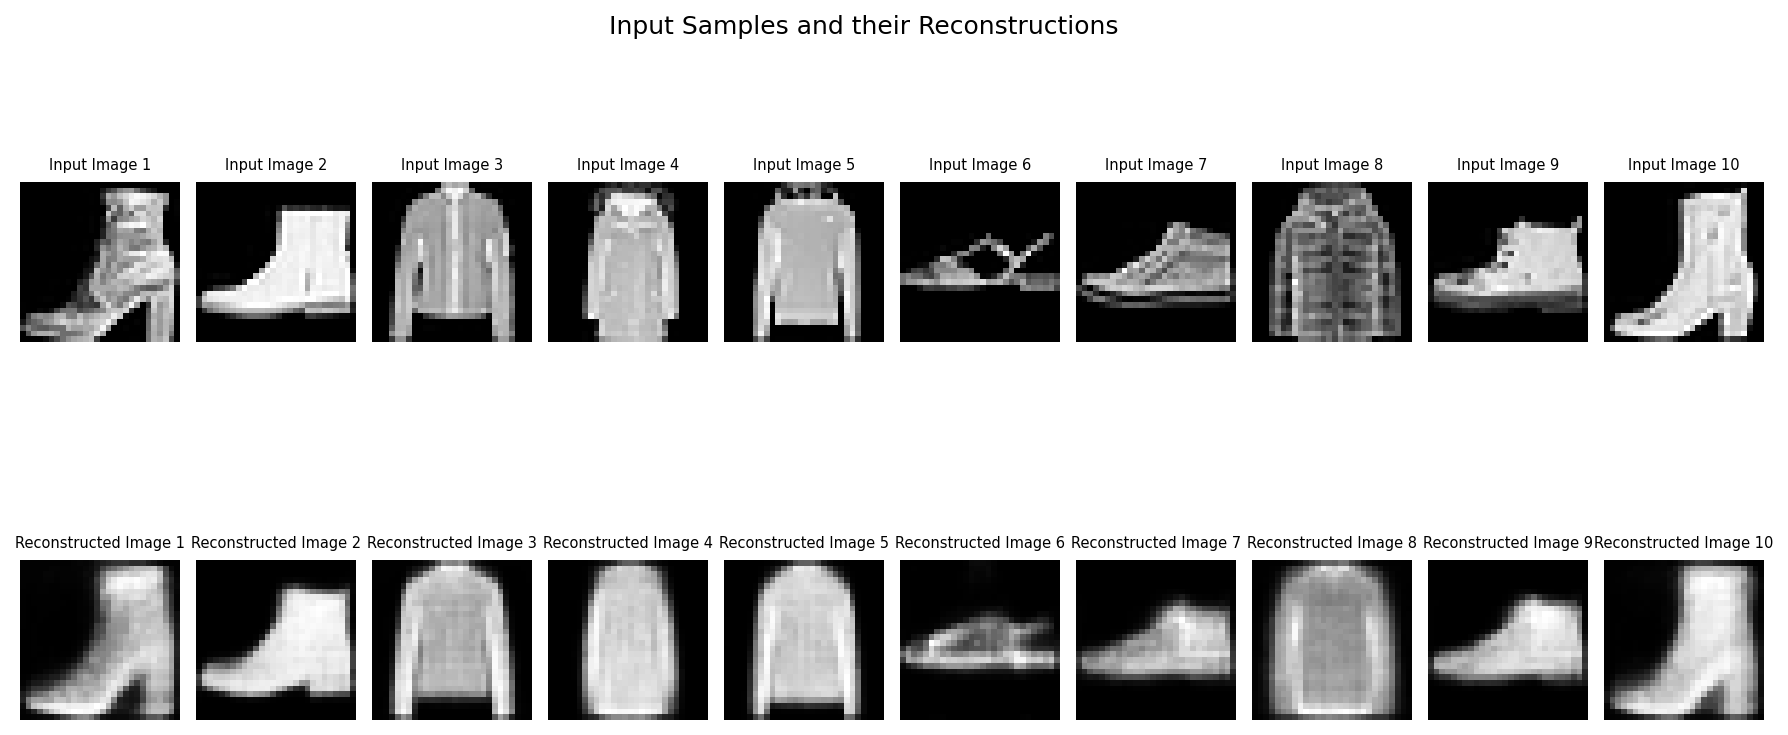

Epoch 3/3, Loss: 0.0783


In [15]:
# test the model
for epoch in range(EPOCHS):
    test_loss = test(autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

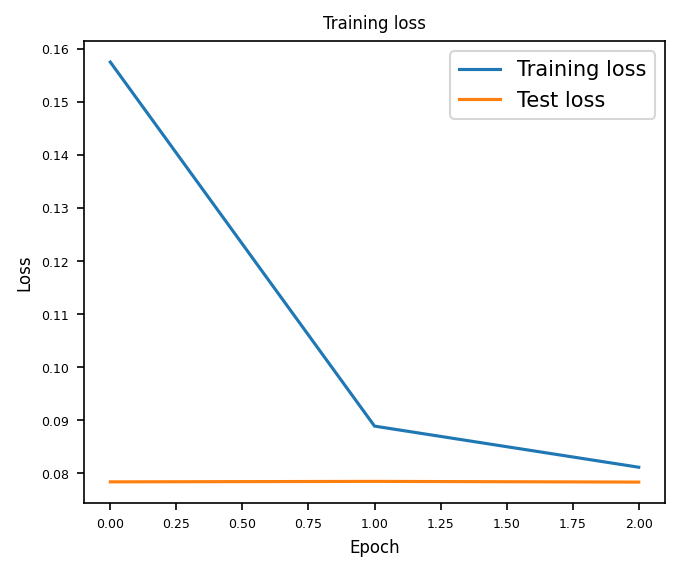

In [16]:
plot_loss(train_losses, test_losses, label='Training loss', path=RESULTS_DIR+'ae_loss_curve.png')

### Task 2: Denoising Autoencoders

2.1 Use your code for the previous task. The model stays the same. But instead of the original input apply your network to the noised input (see function add noise in network.py)

In [17]:
# Note that you should still count loss between not noised image and your prediction.
# Compute the testing loss

denoise_autoencoder = Autoencoder().to(device)
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS_NOISE):
    start = time.time()
    train_loss = train(denoise_autoencoder, trainloader_noise, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS_NOISE}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')


Epoch 1/3, Loss: 1.6829, Time: 5.40 sec
Epoch 2/3, Loss: 1.6833, Time: 5.44 sec
Epoch 3/3, Loss: 1.6830, Time: 5.26 sec


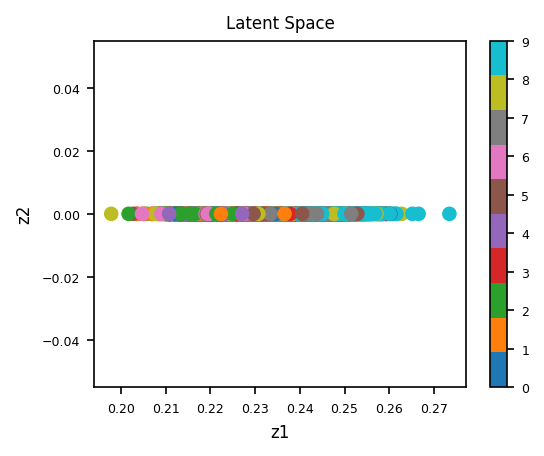

In [18]:
# Plot the latent space
plot_latent(denoise_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent_with_noise.png')

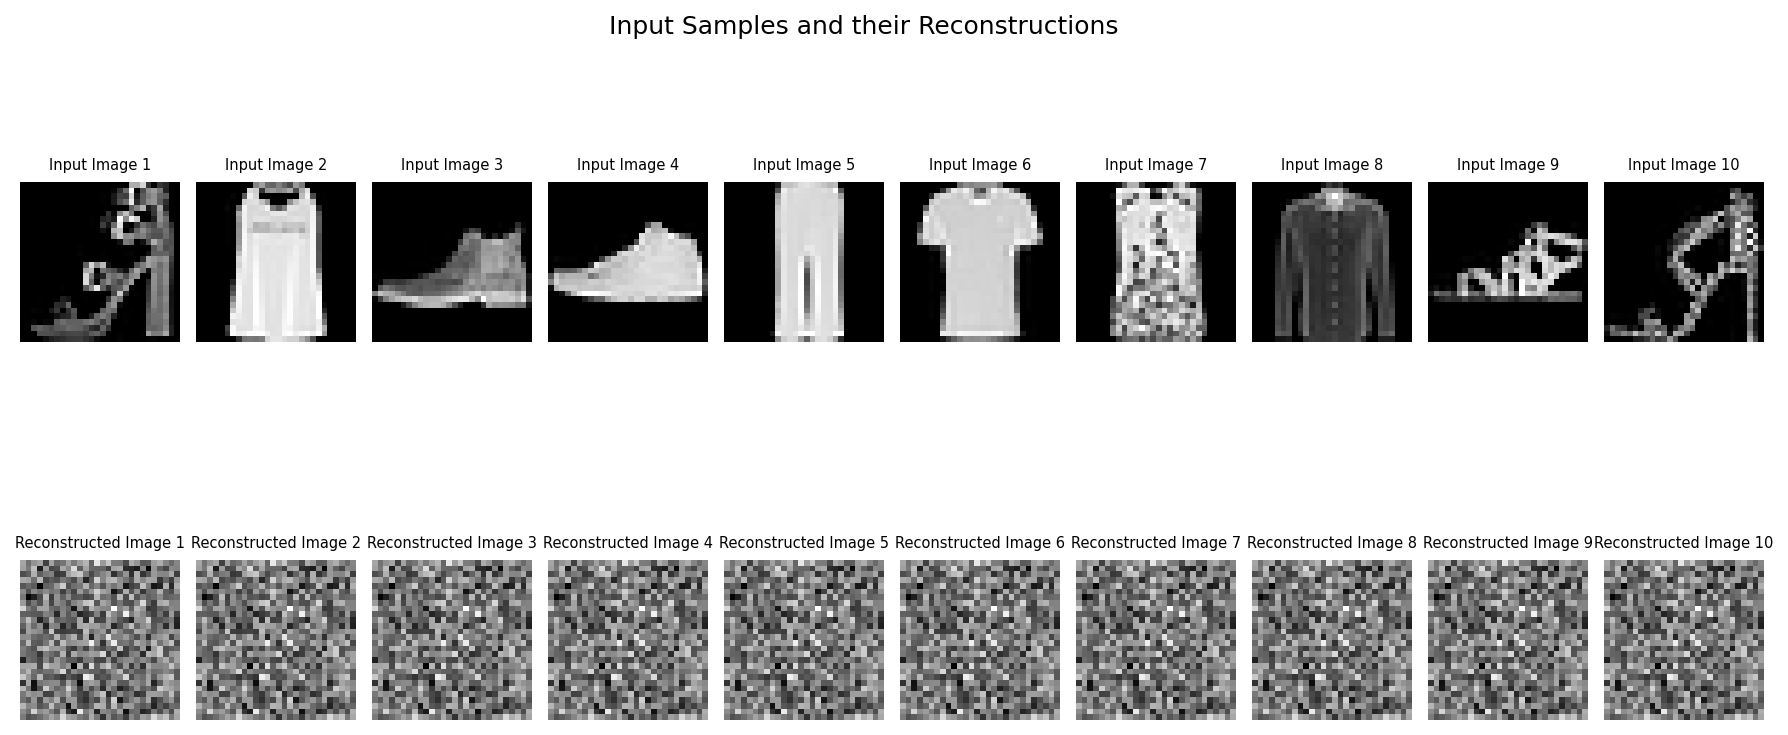

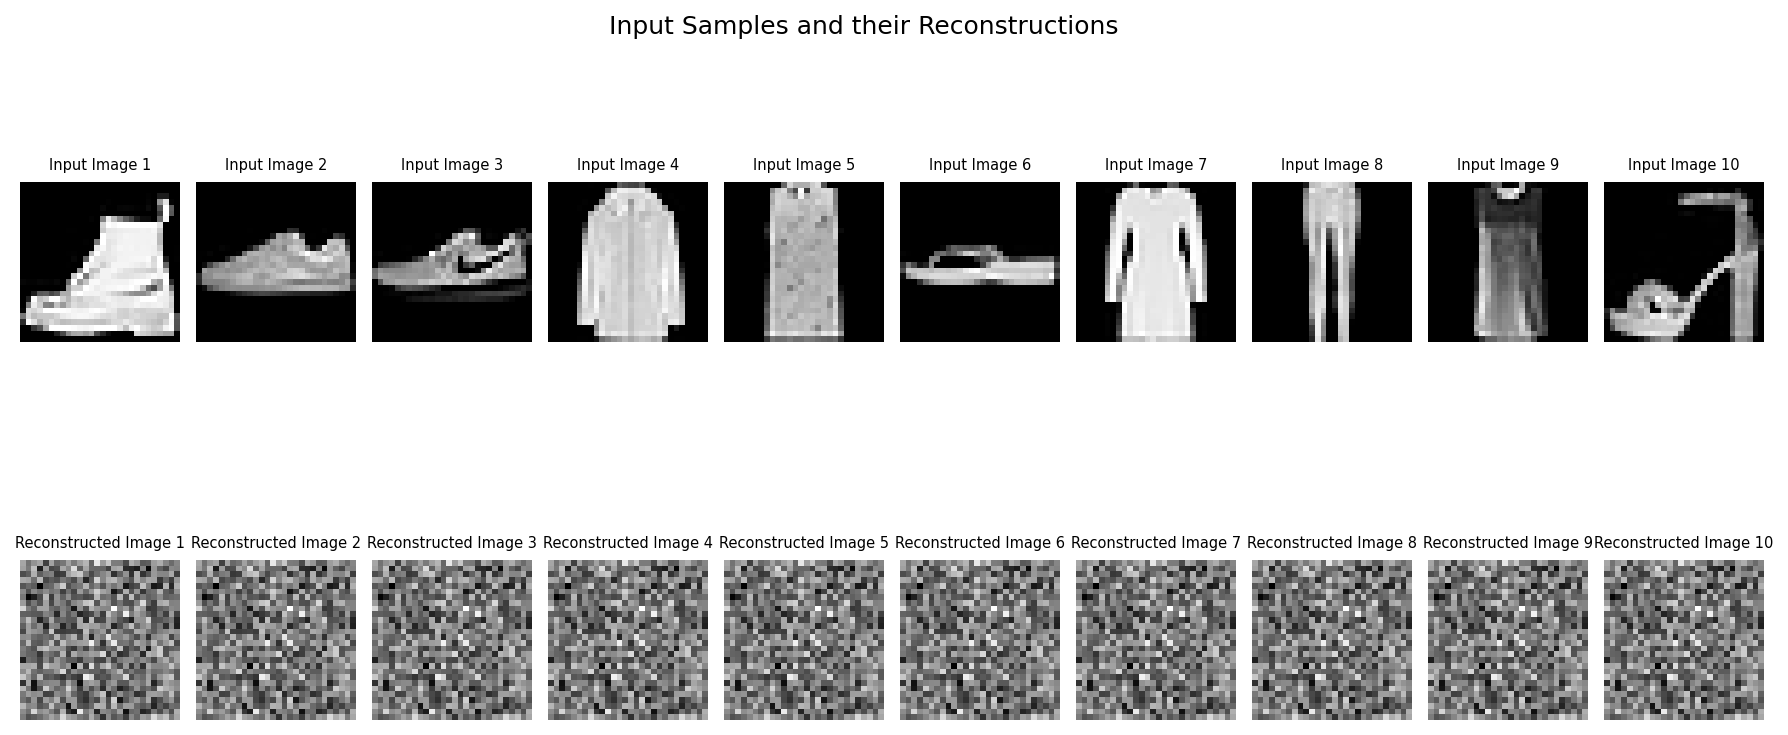

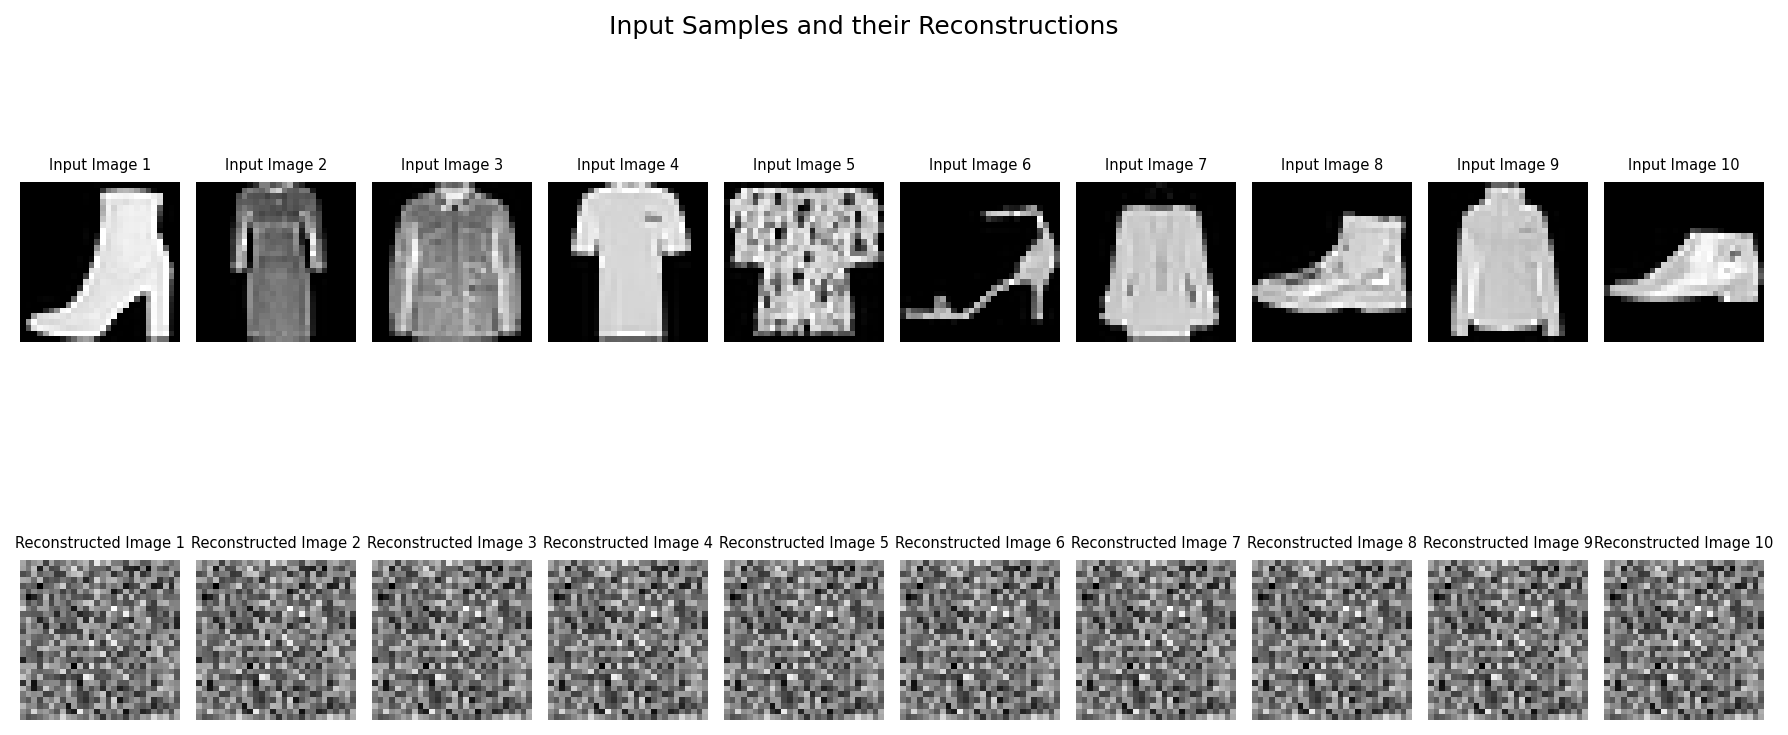

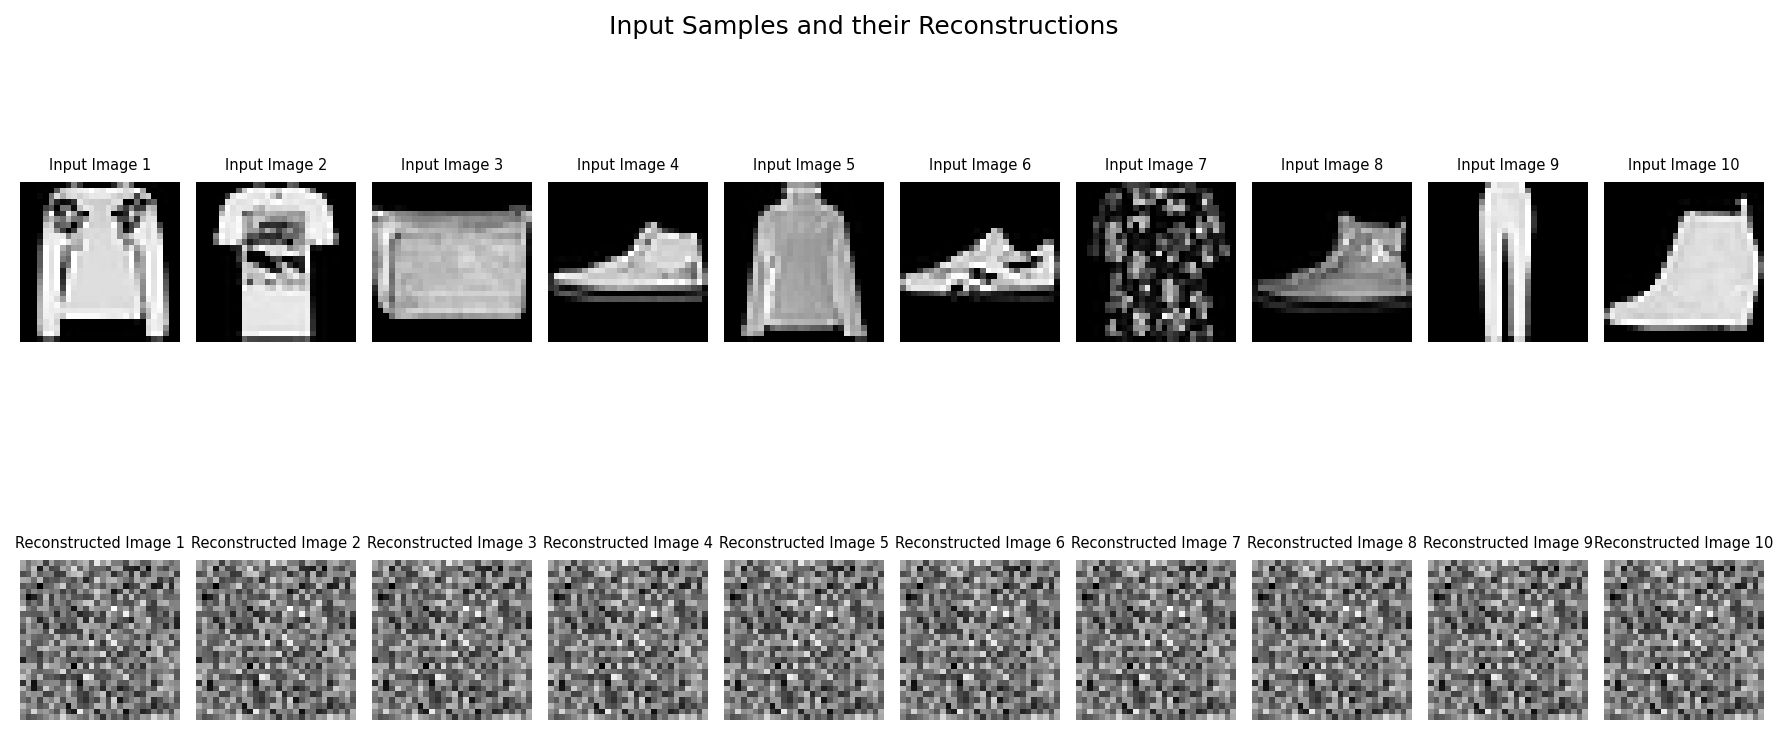

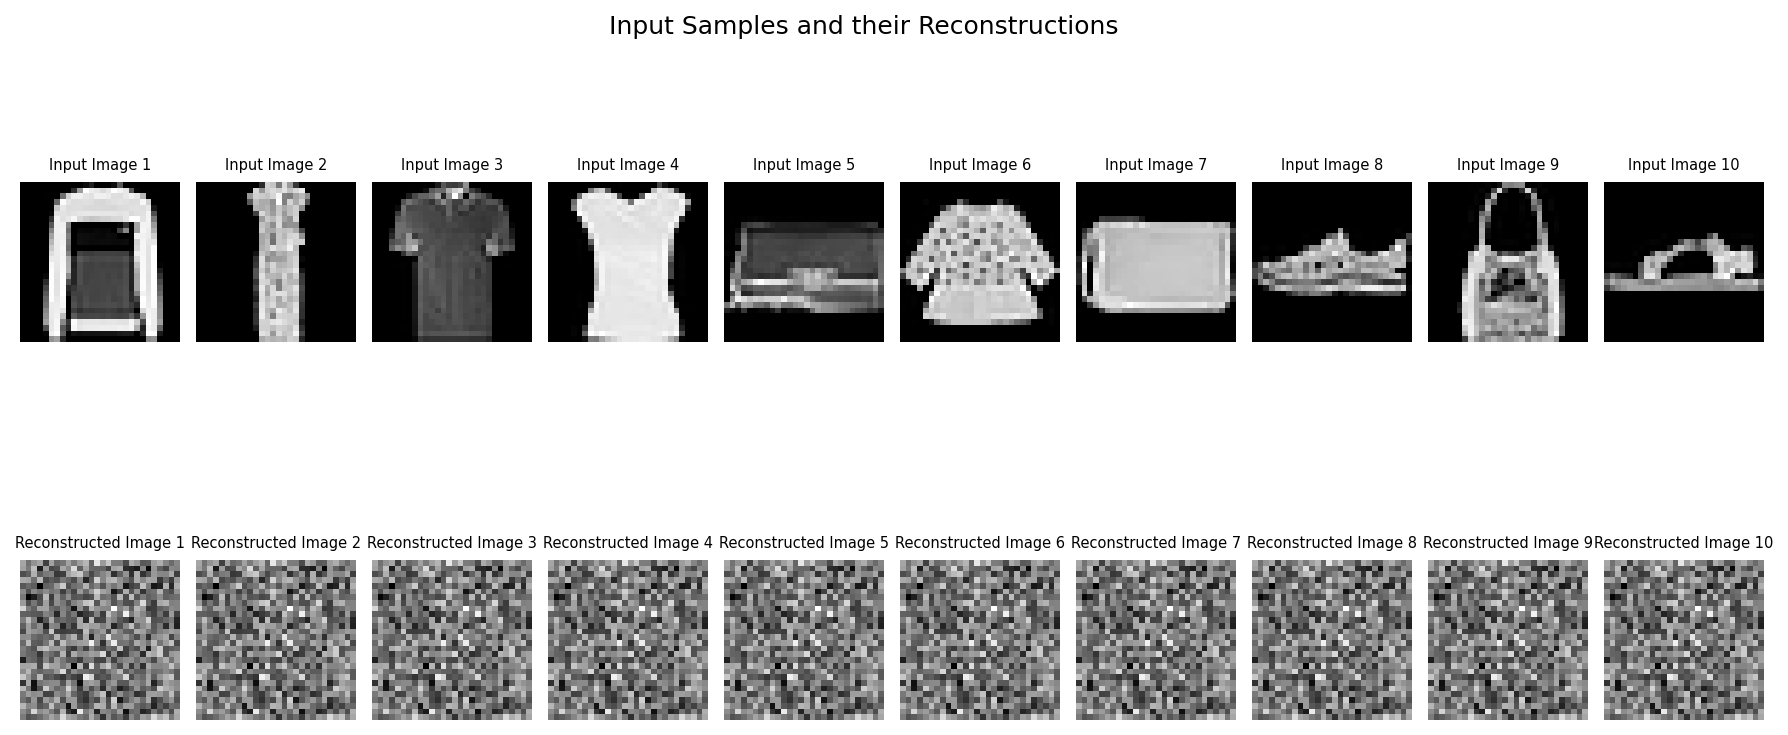

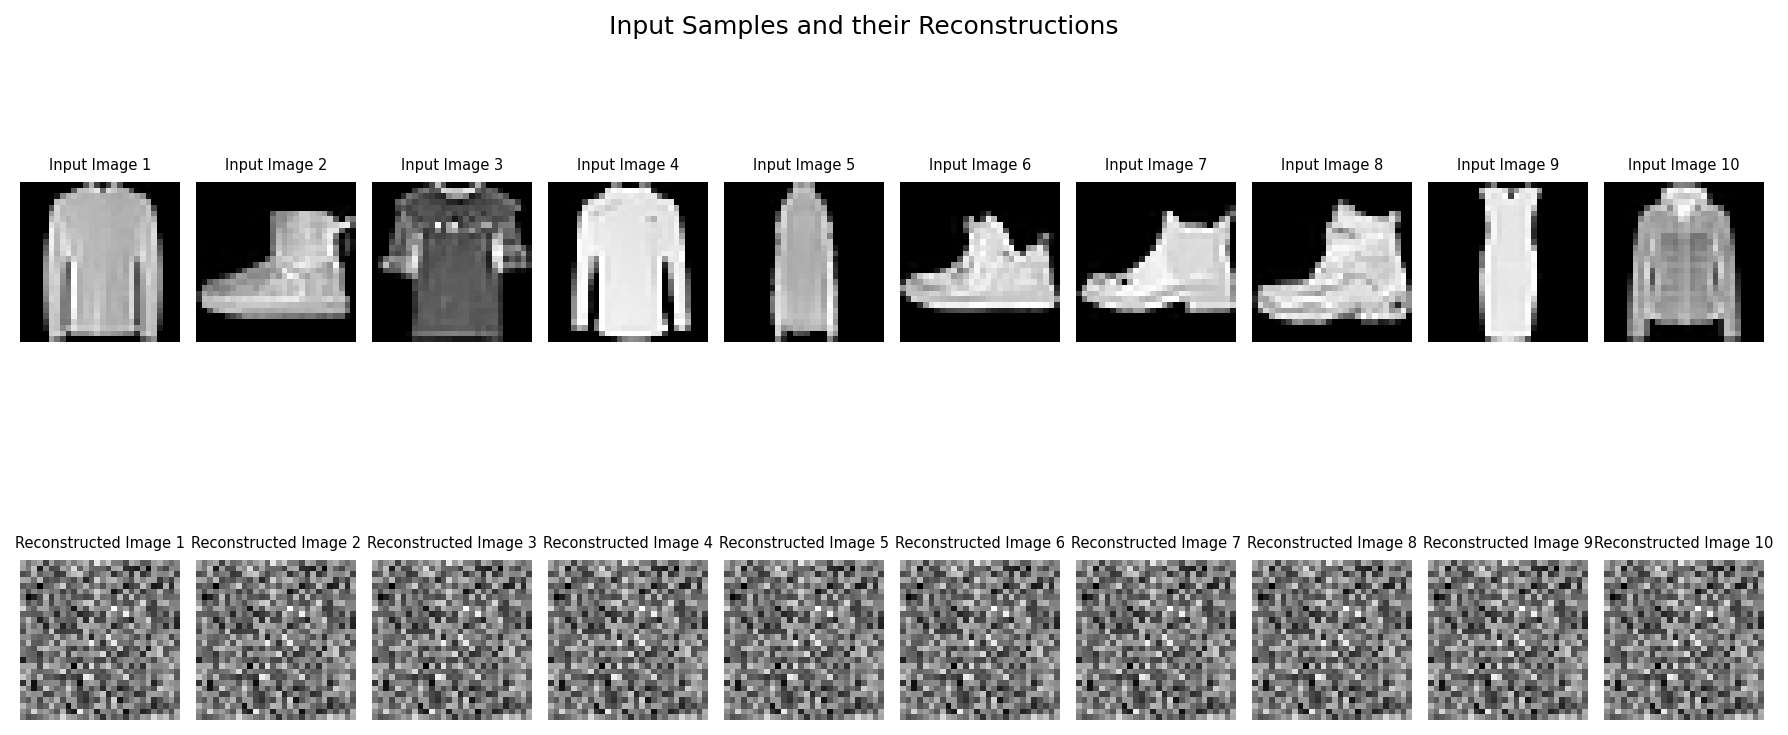

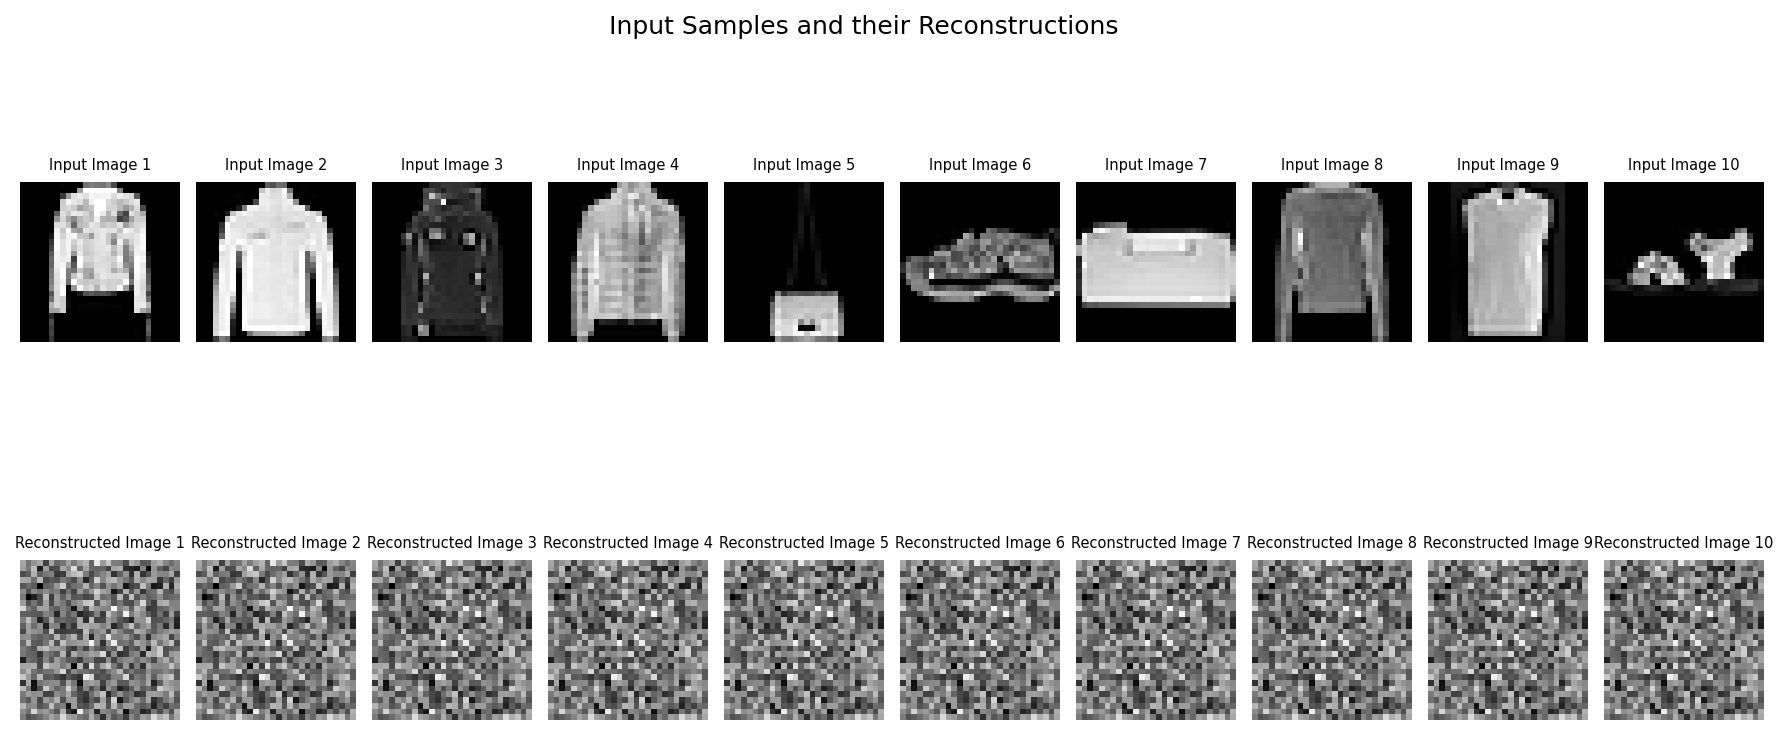

Epoch 1/3, Loss: 0.6801


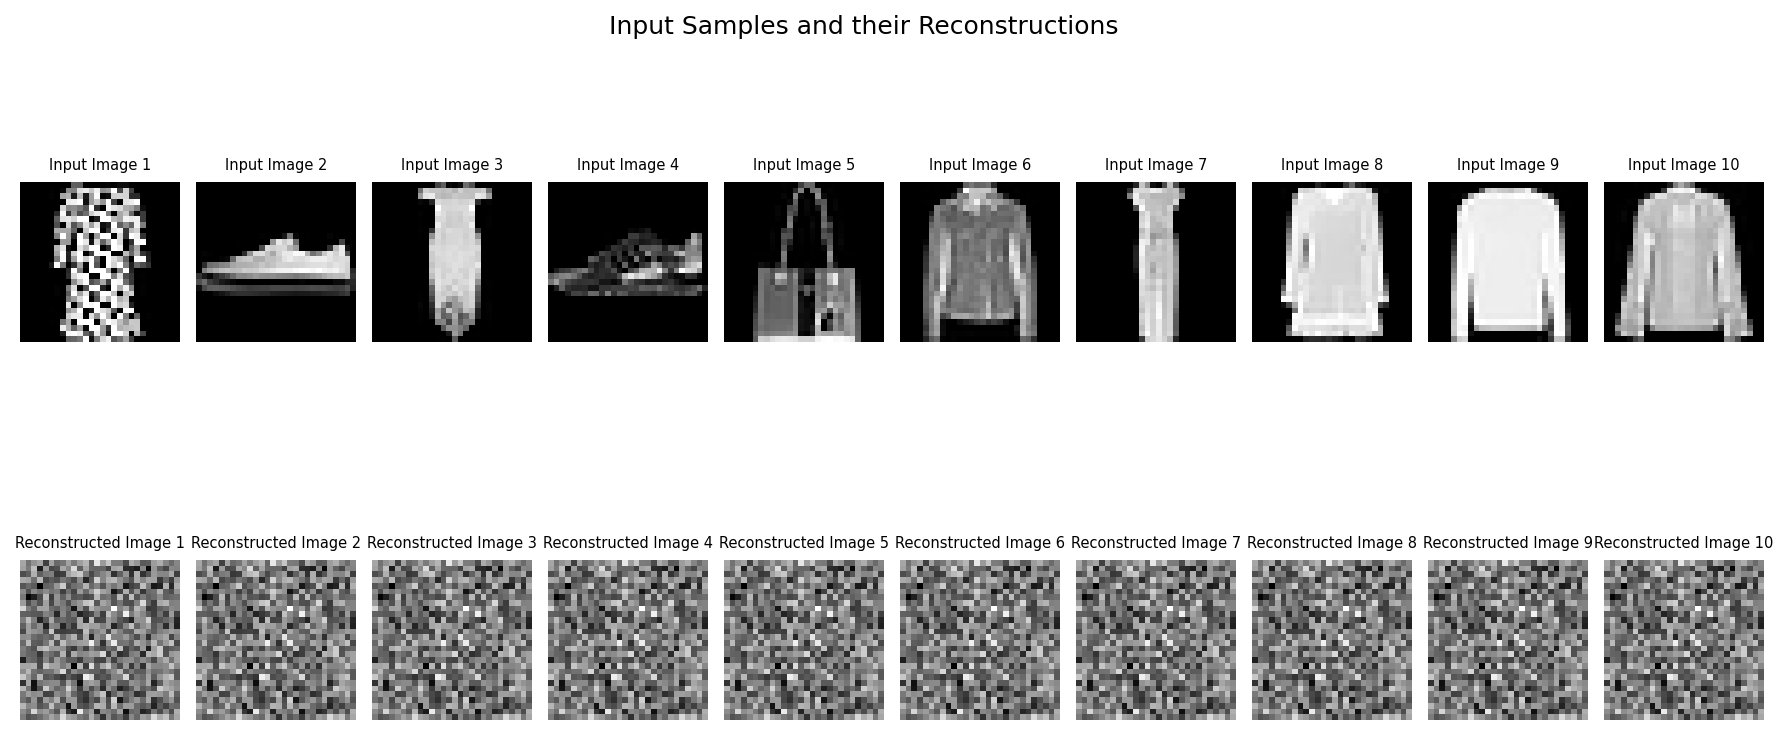

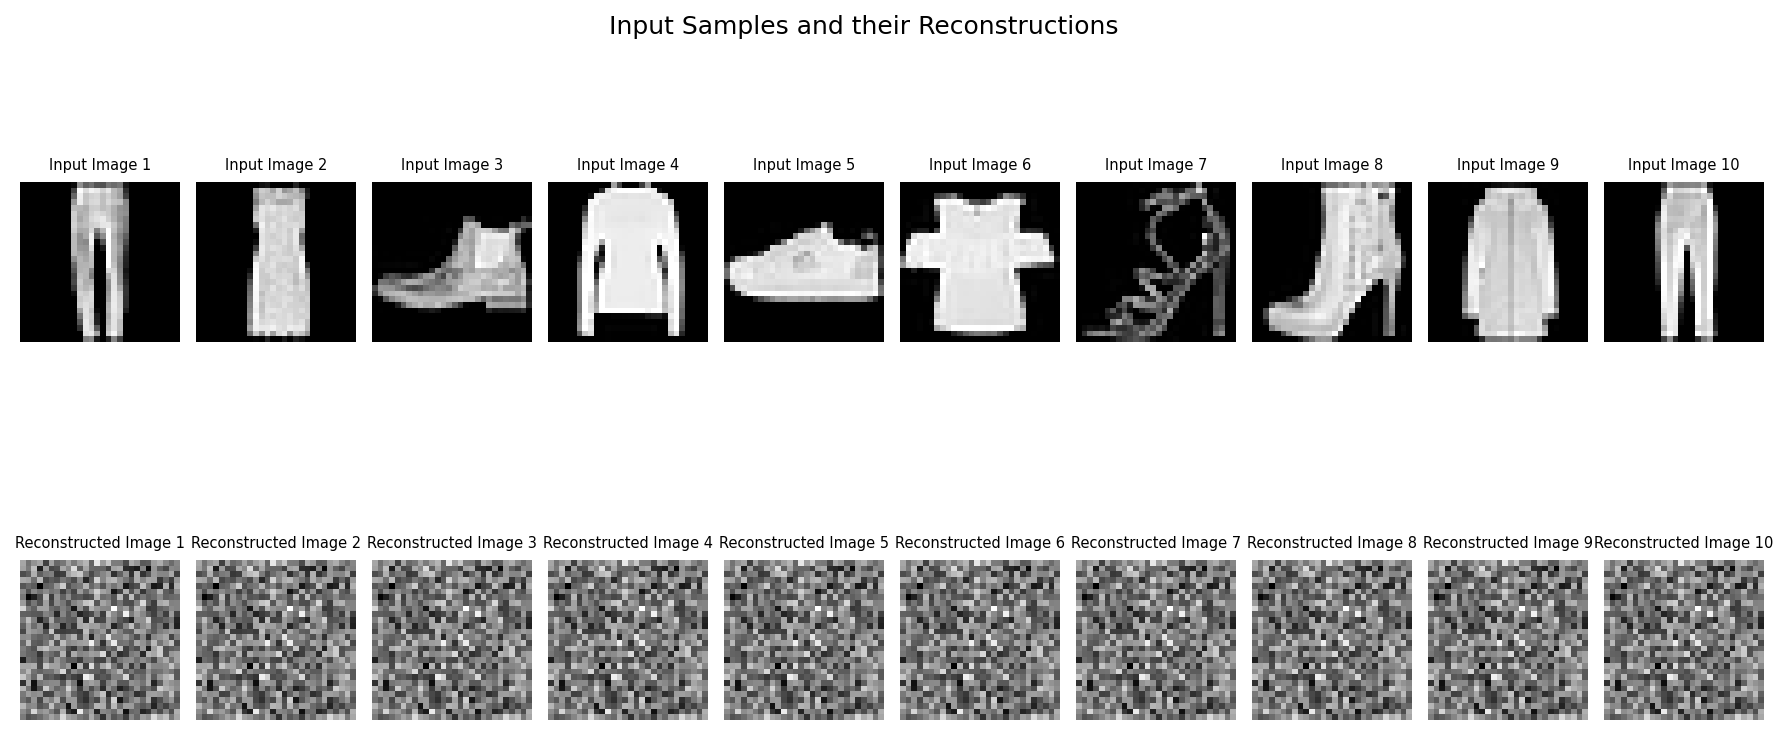

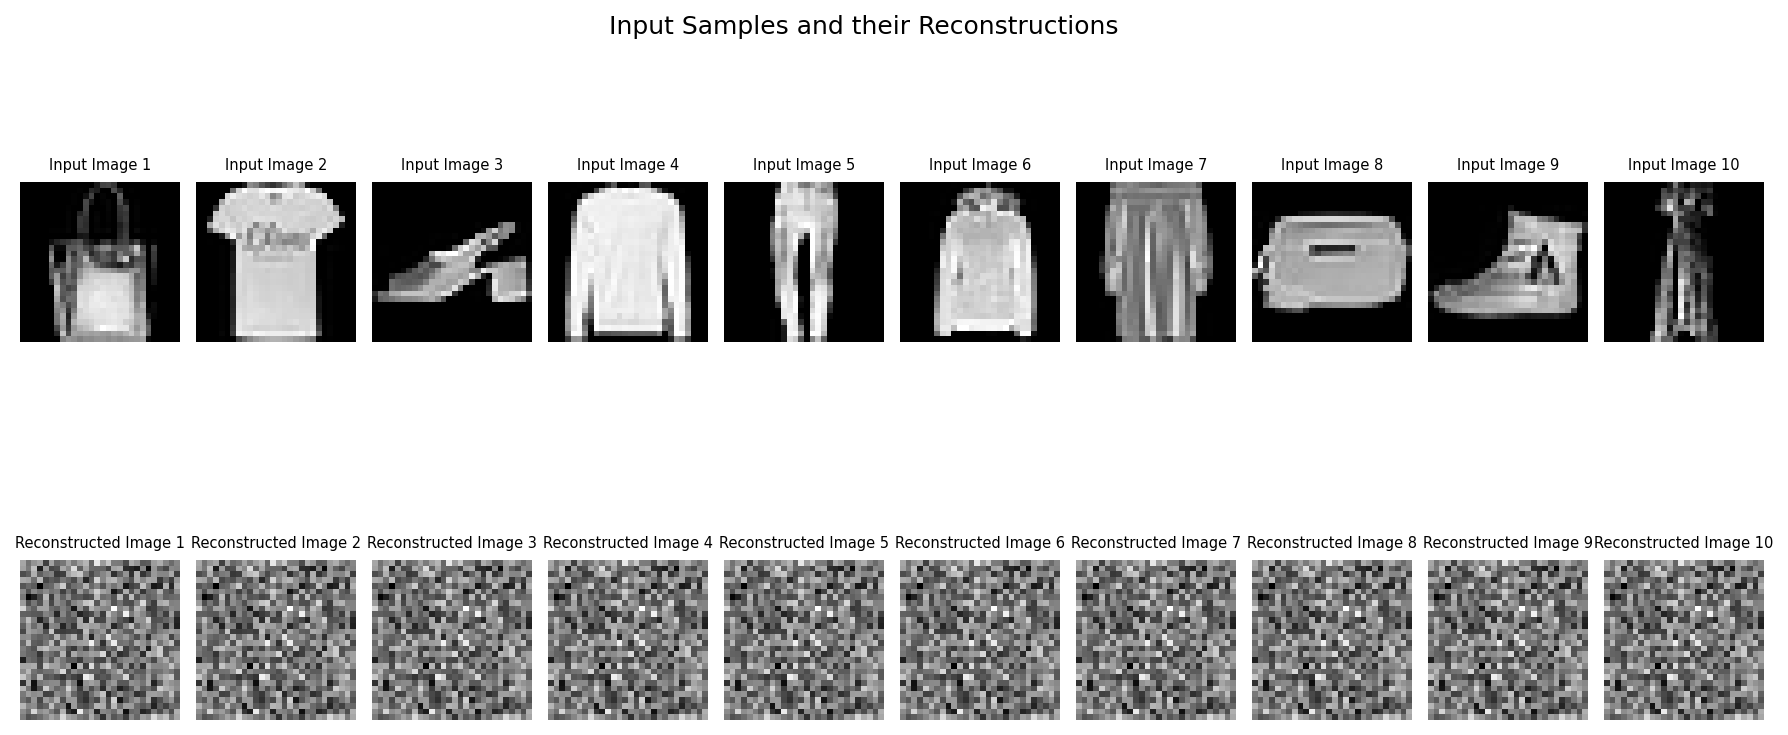

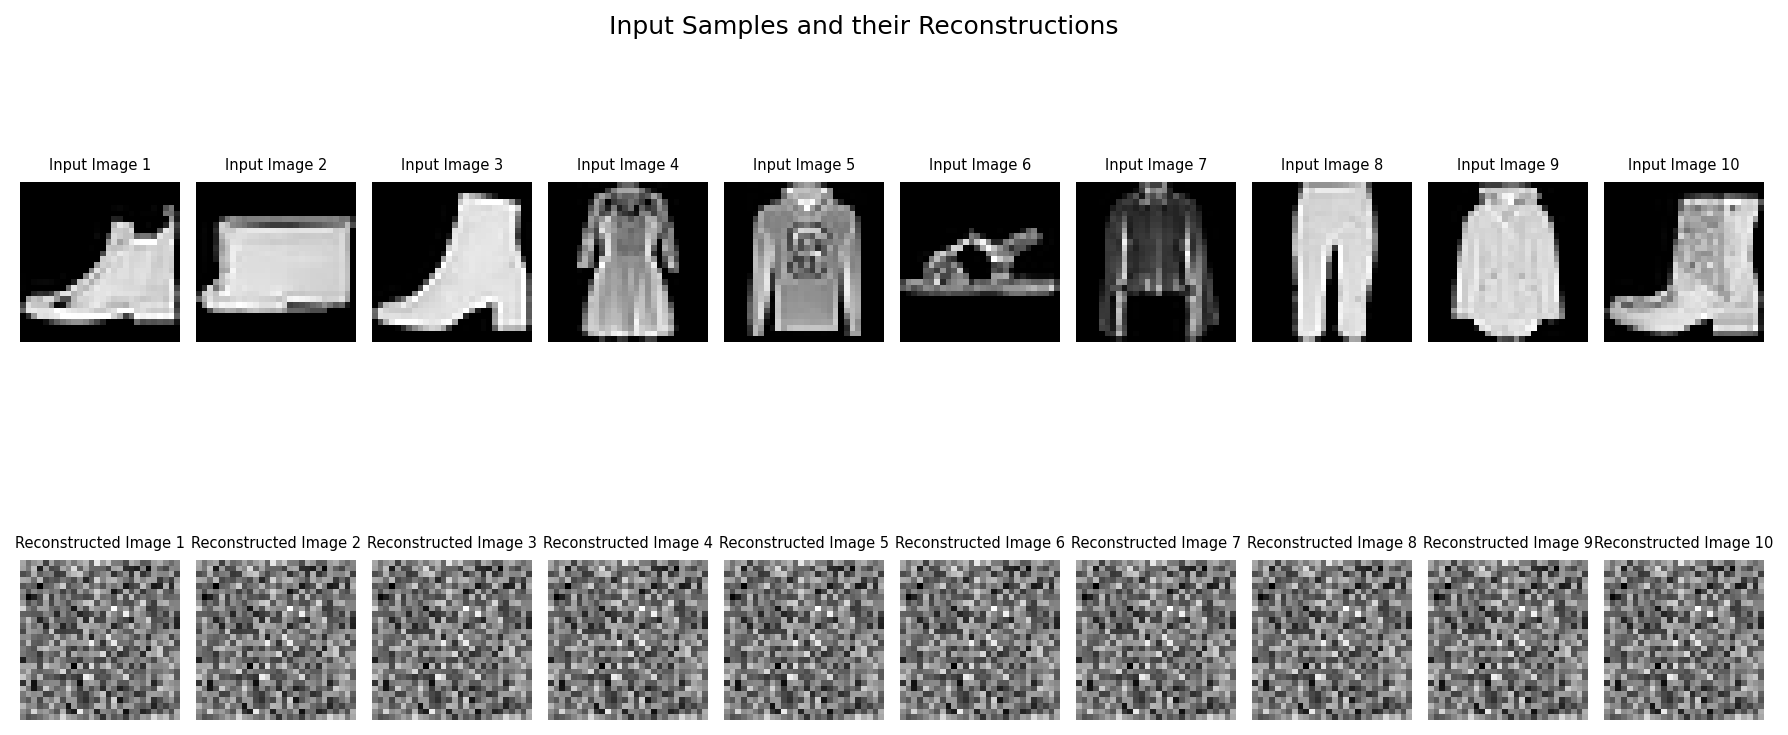

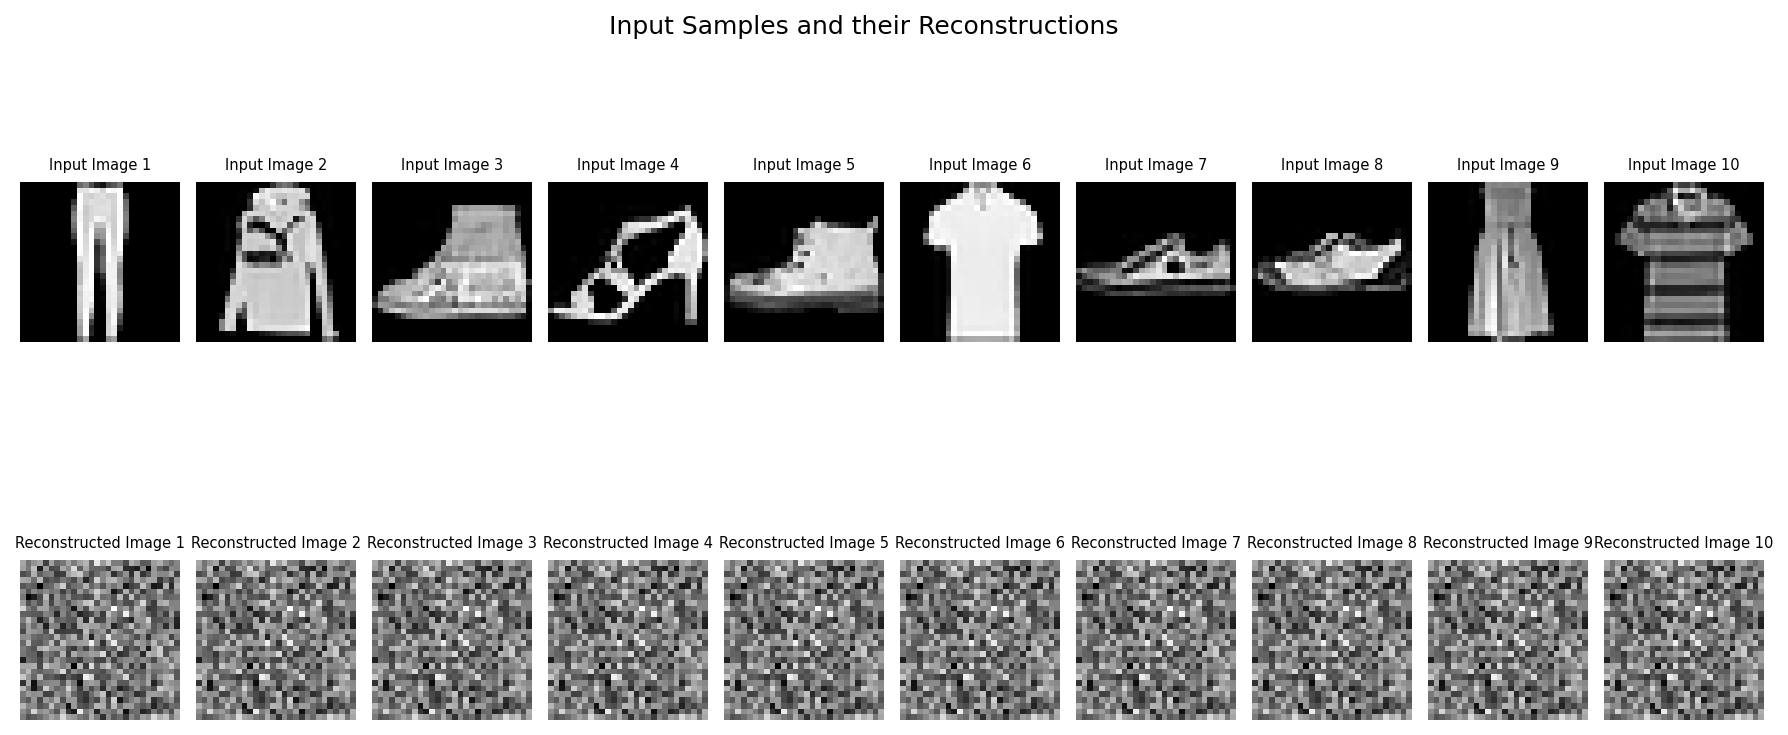

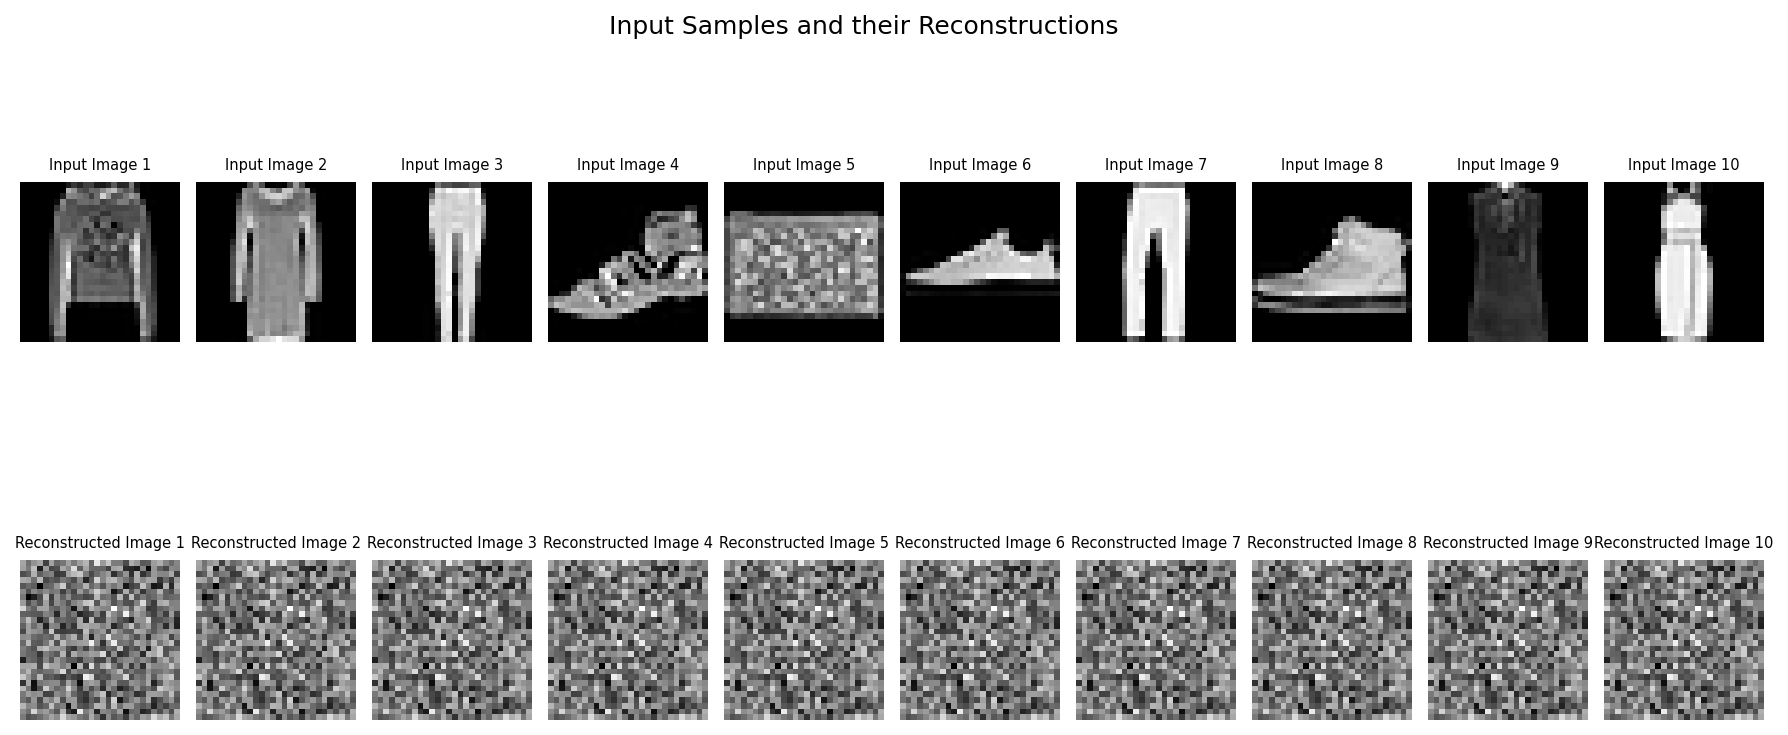

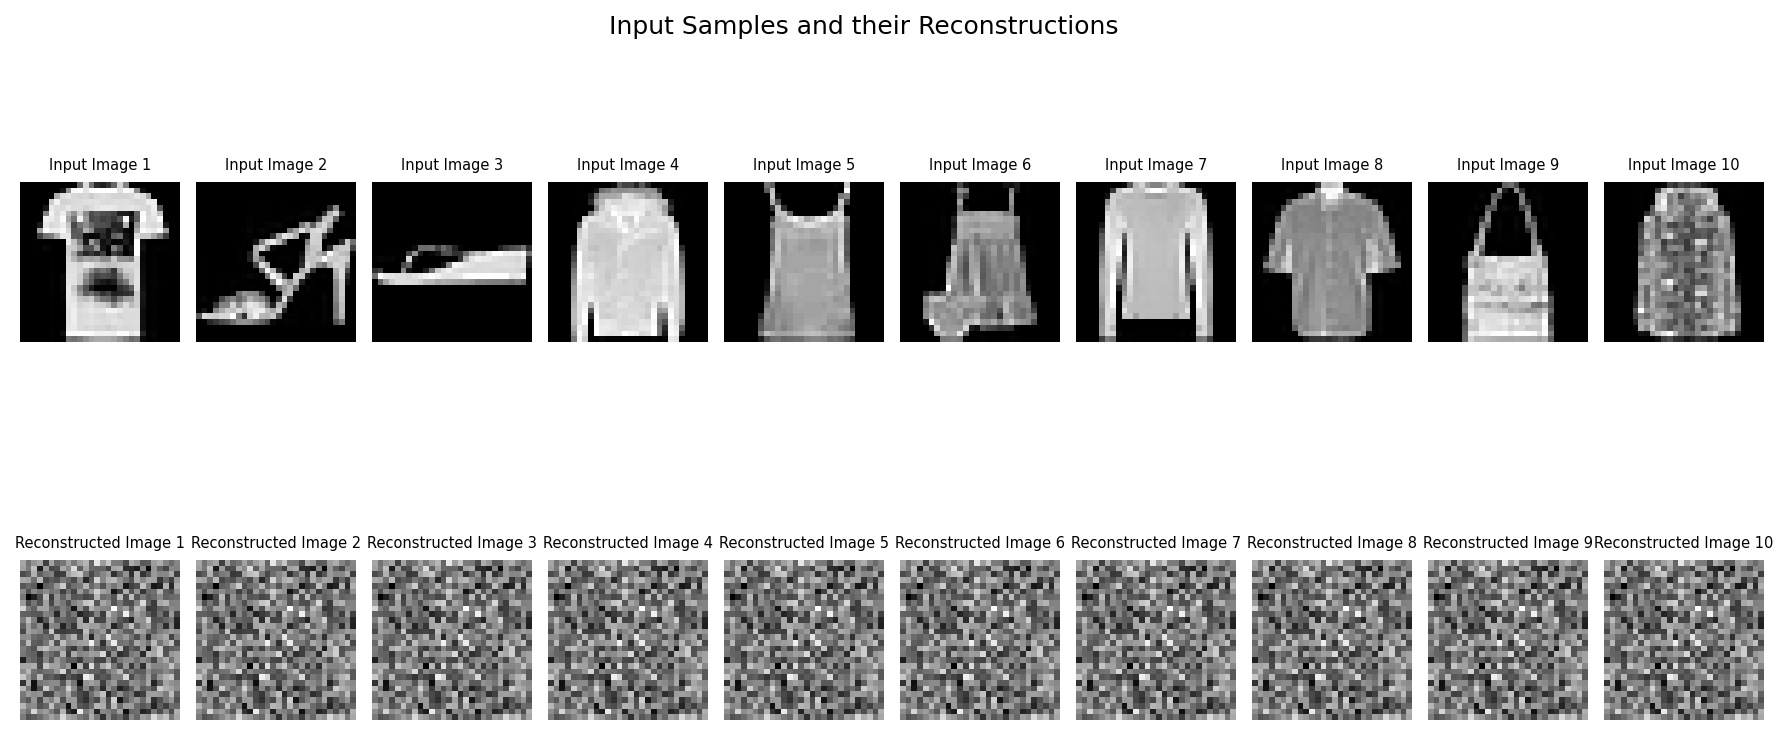

Epoch 2/3, Loss: 0.6797


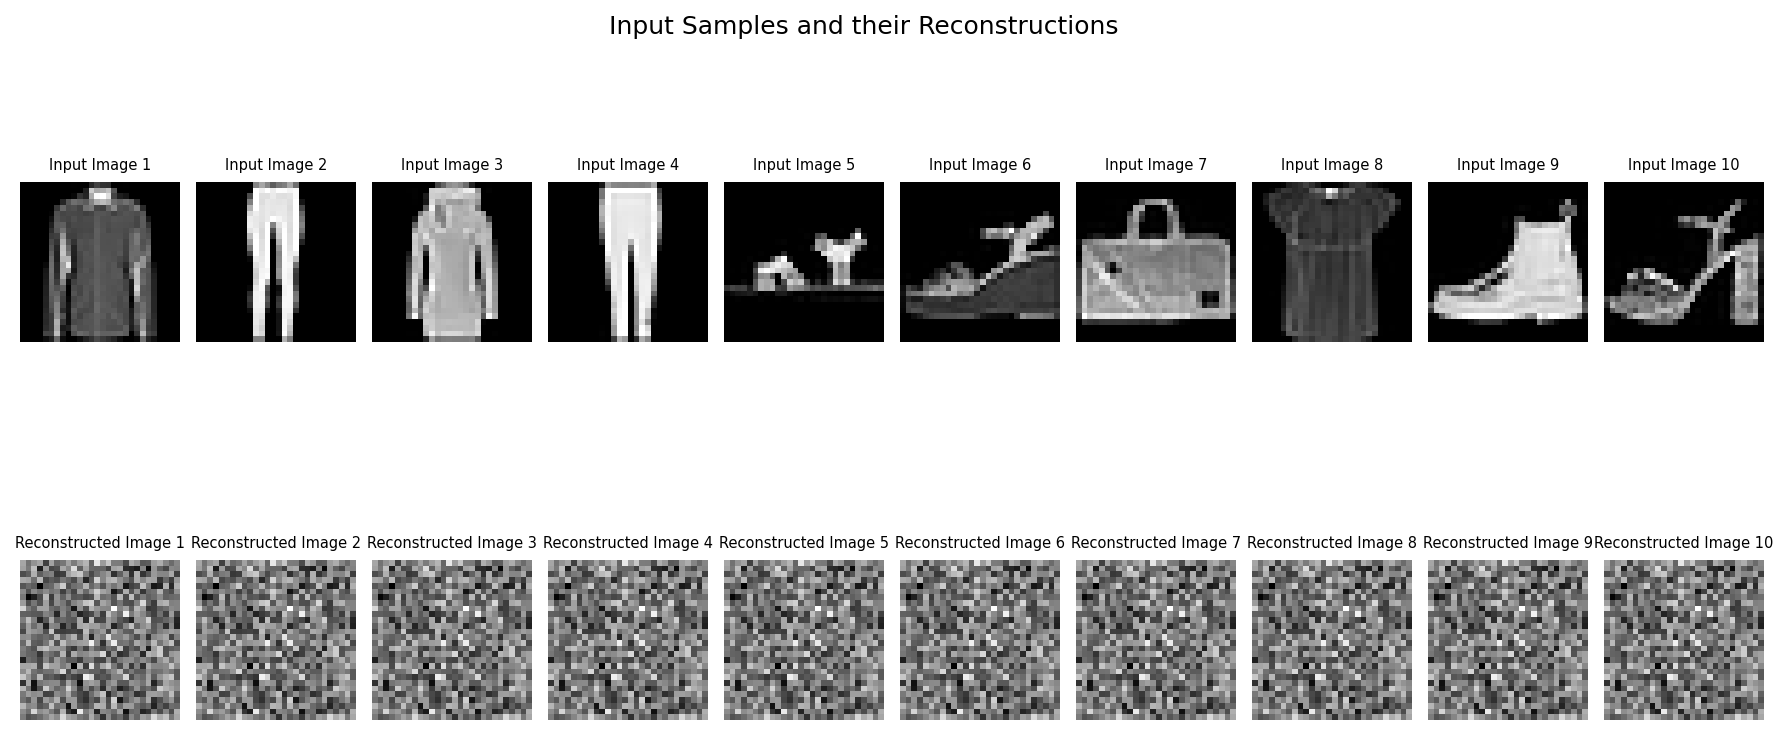

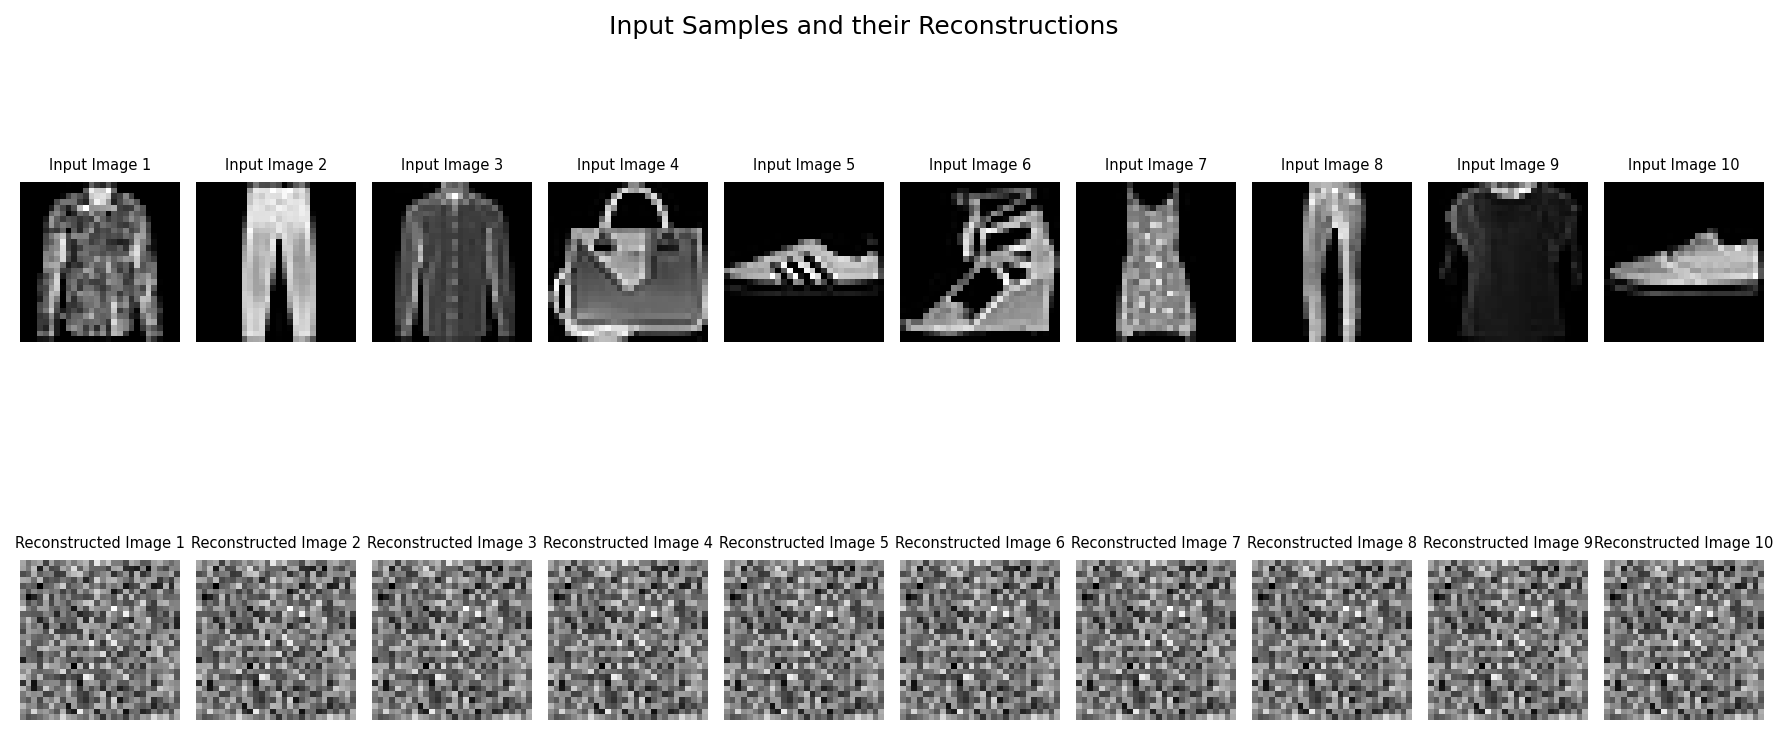

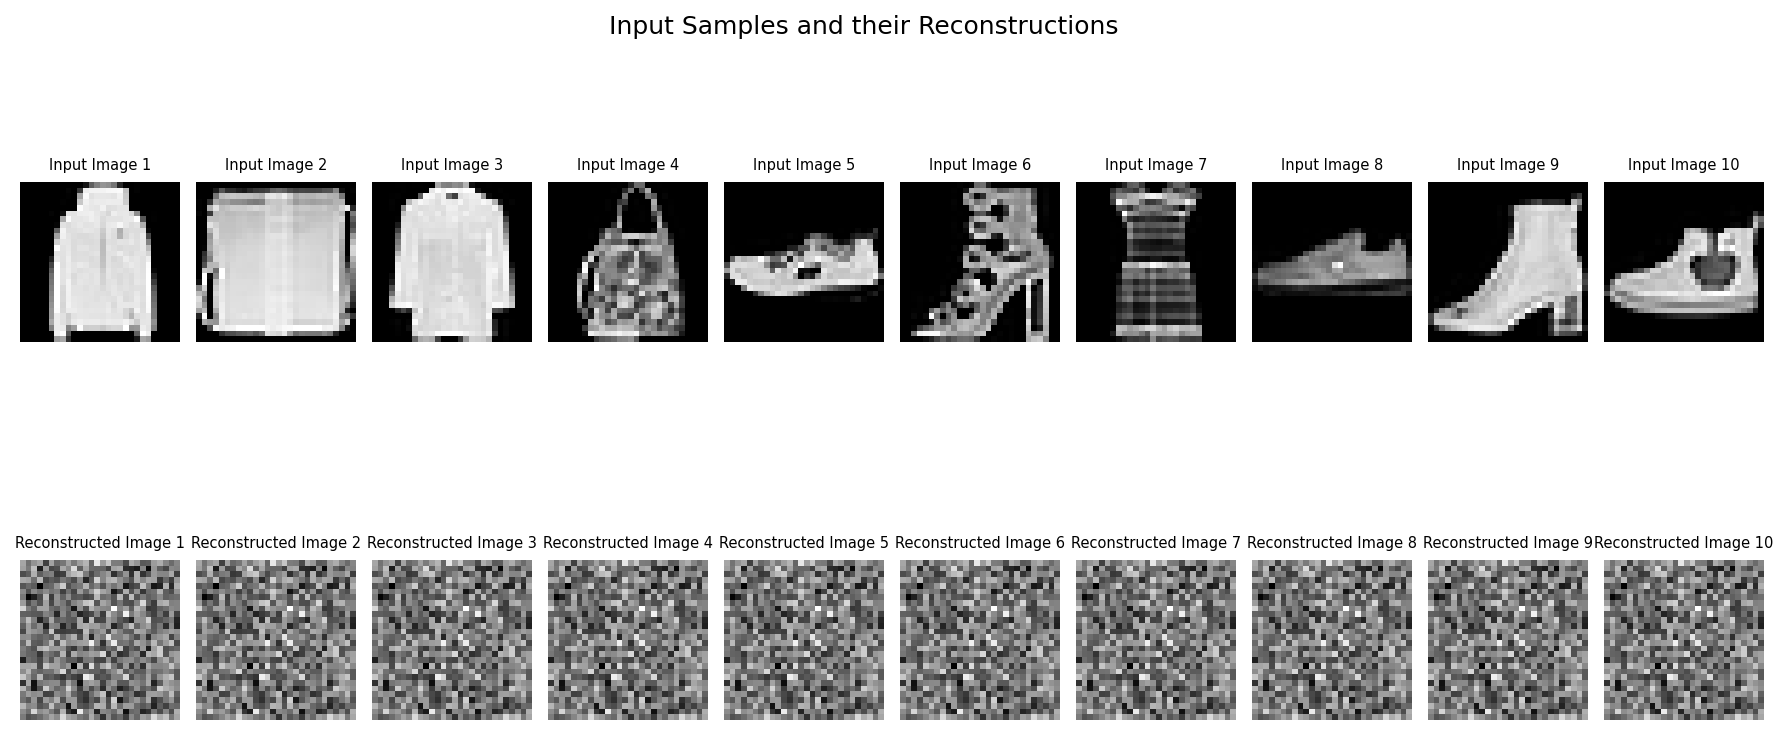

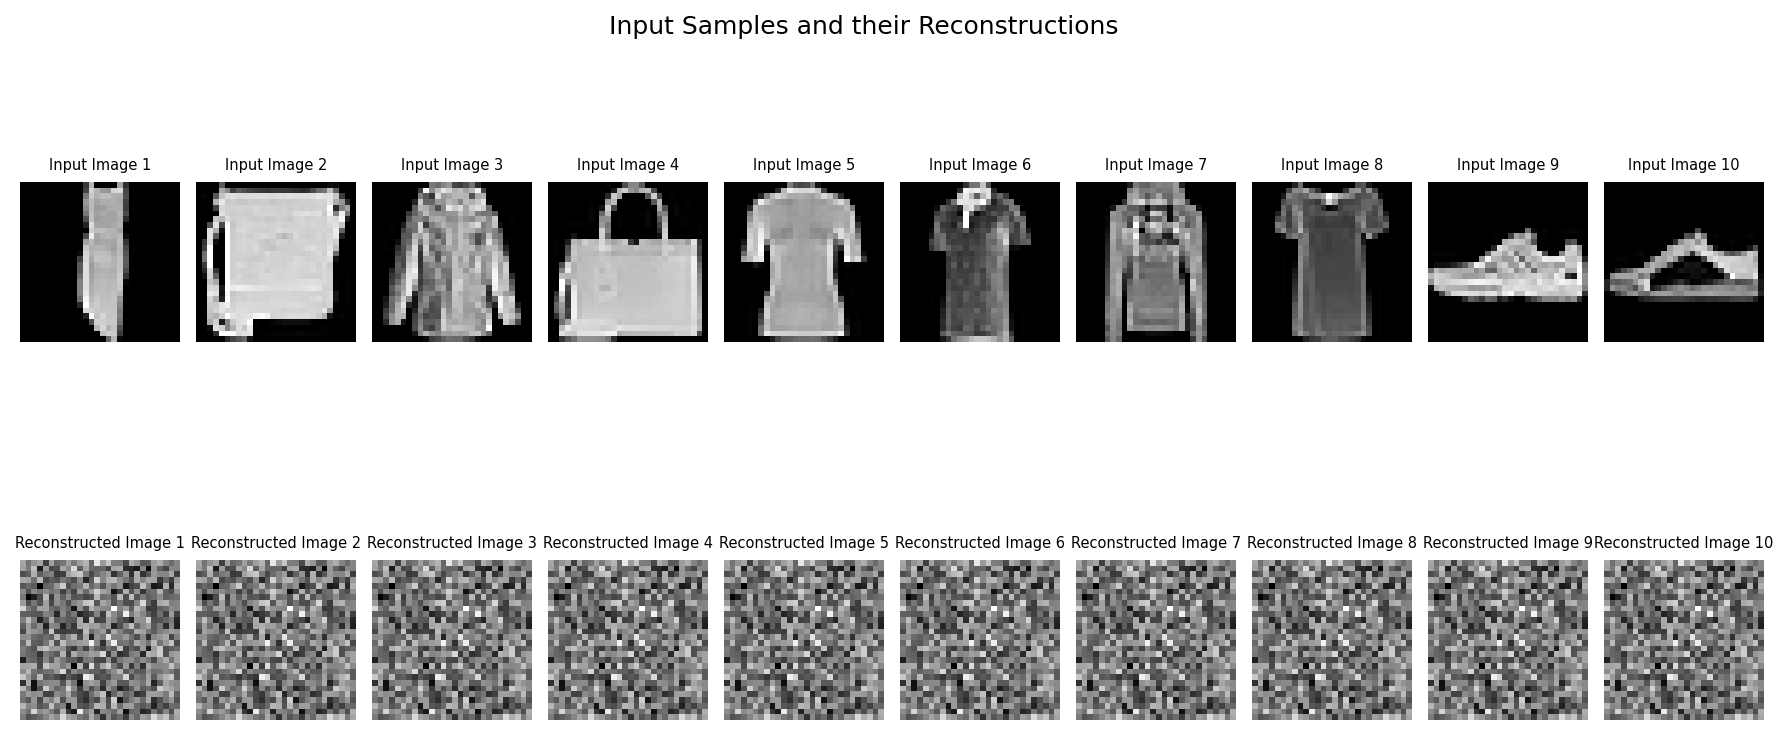

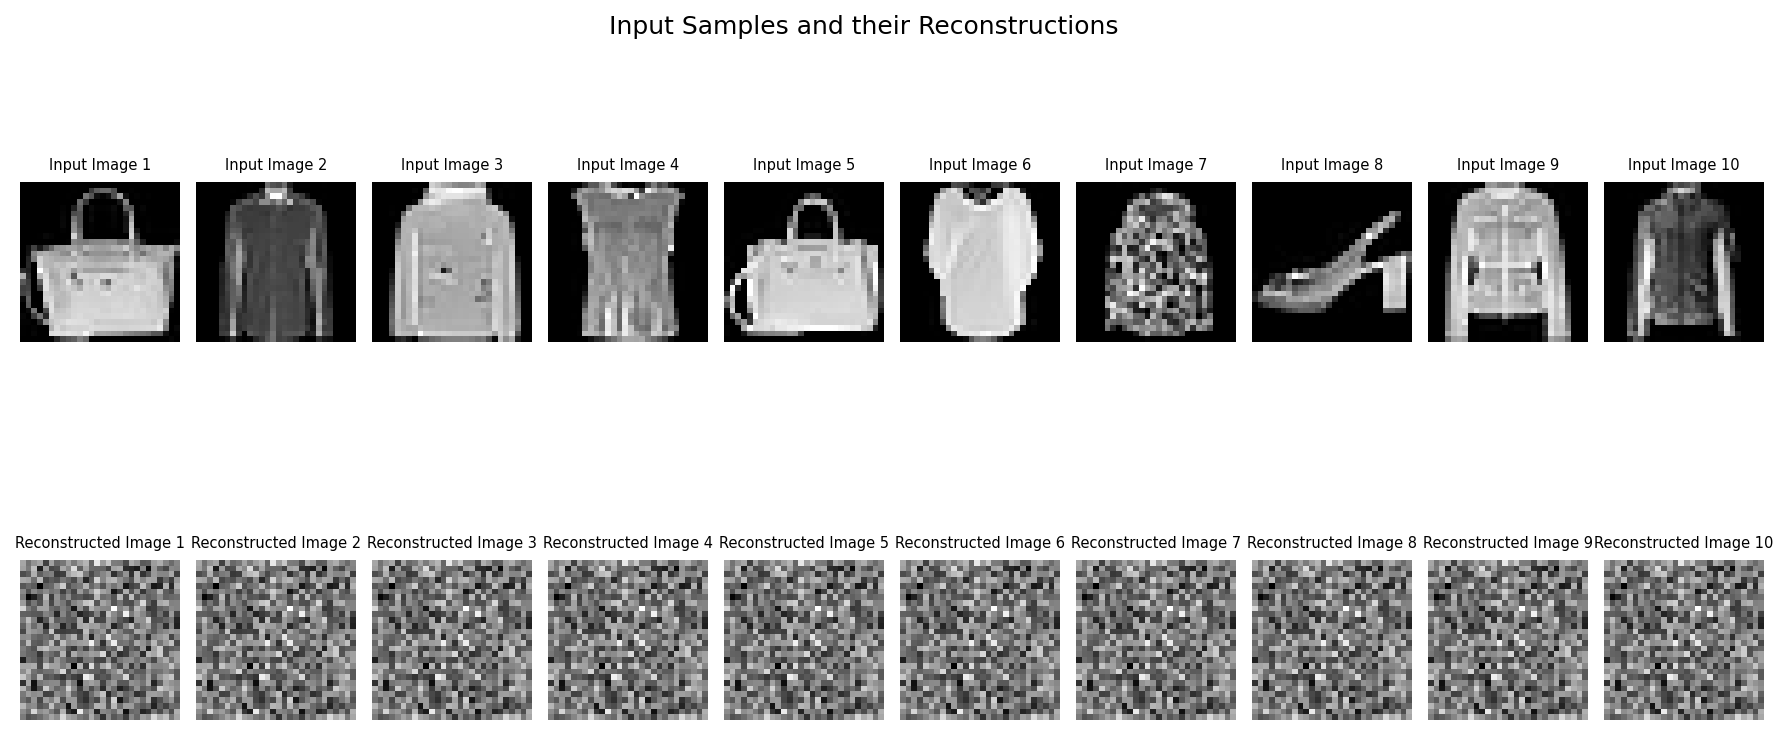

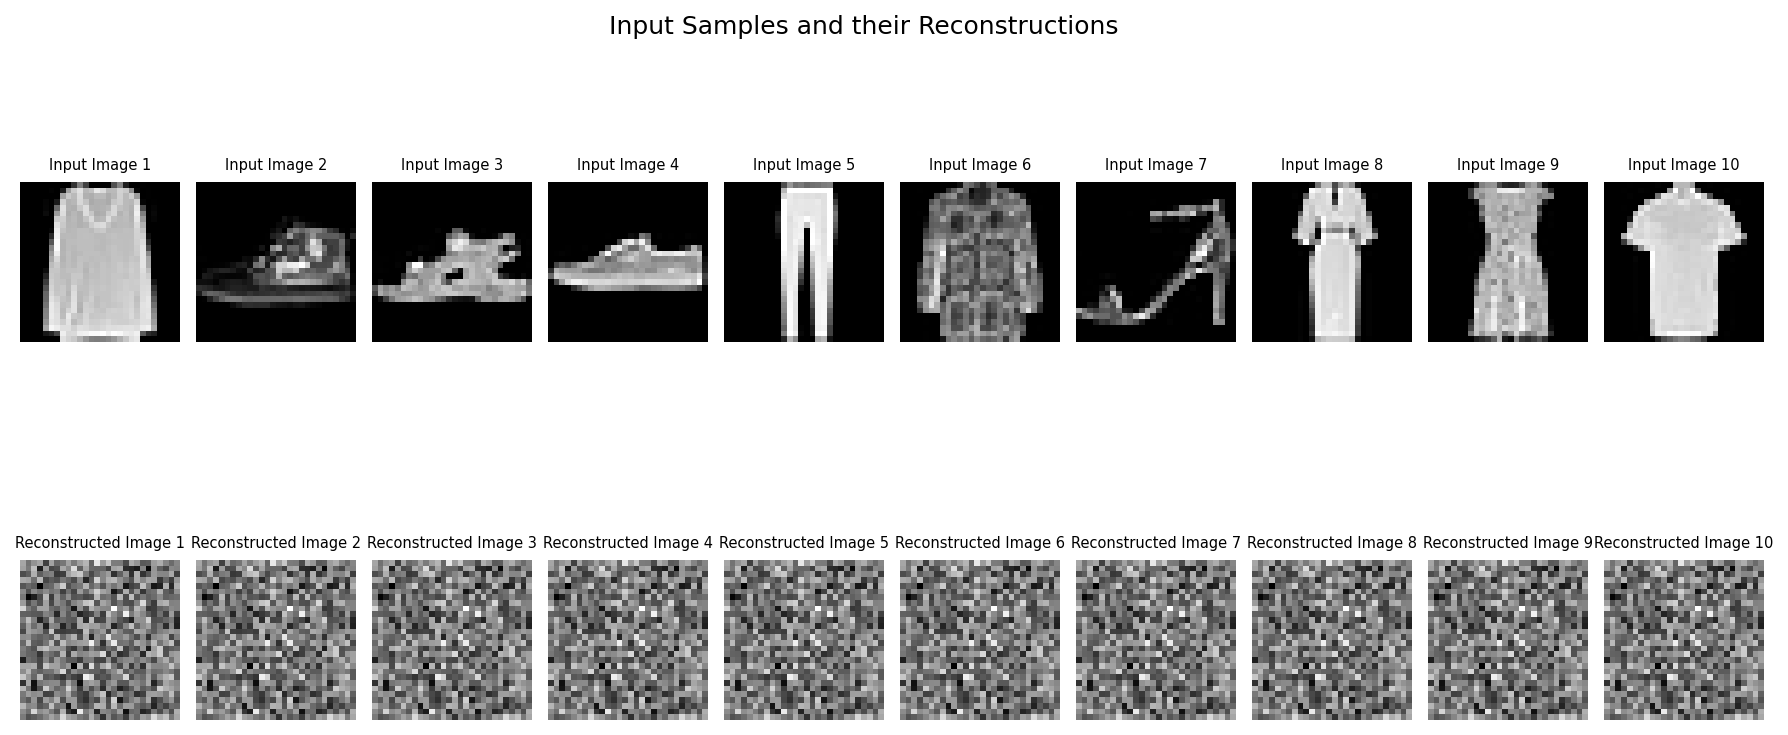

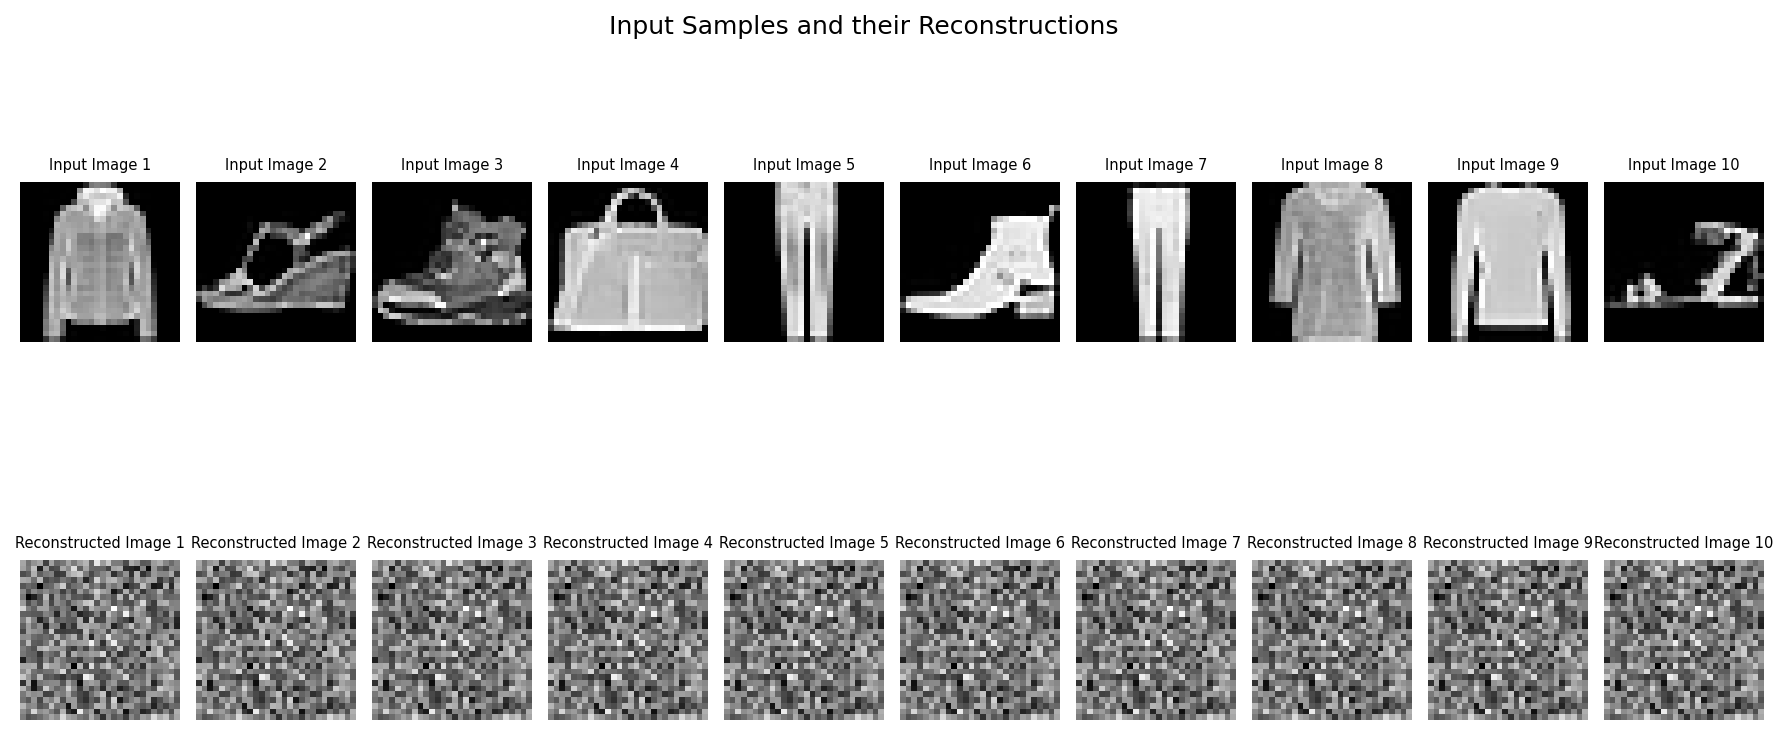

Epoch 3/3, Loss: 0.6795


In [19]:
# test the model
for epoch in range(EPOCHS_NOISE):
    test_loss = test(denoise_autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS_NOISE}, Loss: {test_loss:.4f}')

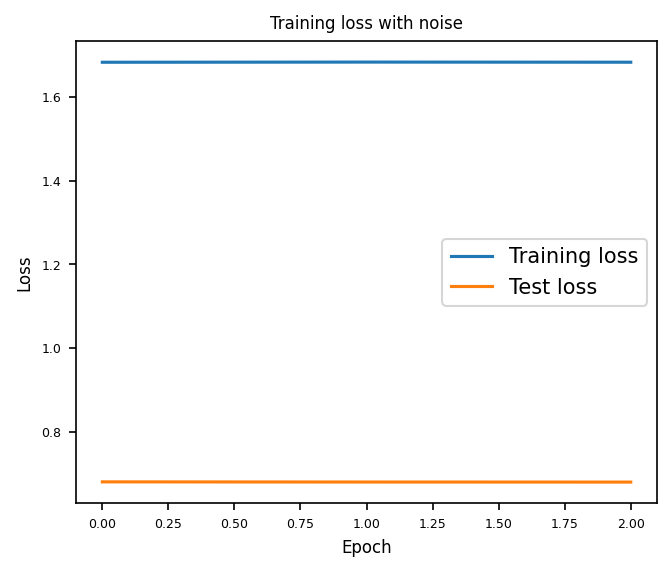

In [20]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss with noise', path=RESULTS_DIR+'ae_loss_curve_noise.png')

**Describe how has the performance of the model changed.**

The linear encoder-decoder network demonstrates the ability to effectively encode by transformation the salient information of the input data into a lower-dimensional latent space, Z, through linear transformations. This results in good preliminary outcomes, often visible in less than 30 epochs. However, it is also noticeable that the results can be blurry and lack certain details. This might be a consequence of the loss function used, as the Mean Squared Error (MSE) loss tries to minimize the difference between the output and input of the network on a pixel level.

MSE loss is highly sensitive to outliers and large errors. In order to minimize the MSE loss, the model tends to focus on reducing these large errors first, often at the expense of preserving high-frequency details, such as edges, textures, and patterns, in the images. These high-frequency components are crucial for the perception of image sharpness and quality. Moreover, the MSE loss function assumes that the errors are independent and identically distributed (i.i.d.), which might not be the case for images. In natural images, the pixels are highly correlated with their neighbors, and these spatial dependencies are not explicitly considered by the MSE loss.

In contrast, the denoising autoencoder appears to struggle with learning how to recover the underlying structures of the data in order to minimize loss. The denoising autoencoder is a modification designed to prevent the network from simply learning an identity function, where the input and output are the same. This issue can arise when the encoder is too large and powerful, causing it to memorize the data instead of performing meaningful representation learning or dimensionality reduction.

Adding noise to the data can be seen as a form of regularization, encouraging the encoder to capture the salient features of the input data without resorting to memorization. However, the results of this experiment have not shown the expected improvements. This could be due to the choice of optimizer, the loss function, or potential issues in the implementation of the concatenation and subsequent clipping of noise and original data. Further investigation is needed to determine the cause and identify potential solutions, such as exploring alternative loss functions

### Task 3: Implement a Convolutional Autoencoder

In [21]:
# 3.1 mplement a convolutional autoencoder using the class torch.nn.Module4 from pytorch. Use the provided starter code as a template.
conv_autoencoder = ConvAutoencoder().to(device)
print(conv_autoencoder)

ConvAutoencoder(
  (encoder): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
      (4): LeakyReLU(negative_slope=0.1)
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3200, out_features=10, bias=True)
      (8): Softmax(dim=1)
    )
  )
  (decoder): ConvDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=400, out_features=4000, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Unflatten(dim=1, unflattened_size=(10, 20, 20))
      (5): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (6): Bat

In [22]:
# 3.2 Use the mean squared error5 to implement the reconstruction error of the autoencoder. 
# The error will be computed between the input image x and the output of the autoencoder g(f (x)).

criterion = nn.MSELoss()

In [23]:
# 3.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128. Run it for at least 50 epochs.
lr = 0.001
weight_decay = 1e-5

# create optimizer
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer

In [24]:
# Report the loss on the training split for each epoch, and every ten epochs on the test set
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS):
    start = time.time()
    train_loss = train(conv_autoencoder, trainloader, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')

Epoch 1/3, Loss: 0.1316, Time: 42.61 sec
Epoch 2/3, Loss: 0.0881, Time: 45.65 sec
Epoch 3/3, Loss: 0.0764, Time: 43.68 sec


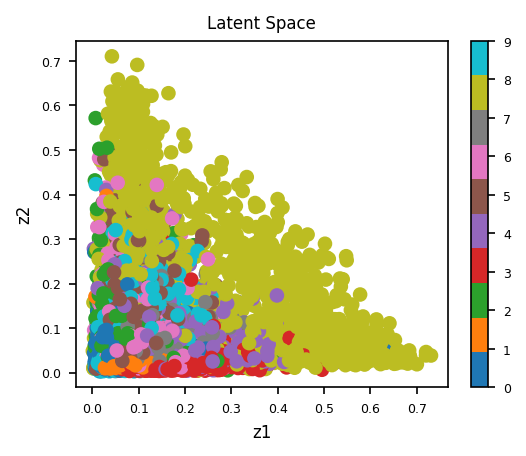

In [25]:
# Plot the latent space
plot_latent(conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent.png')

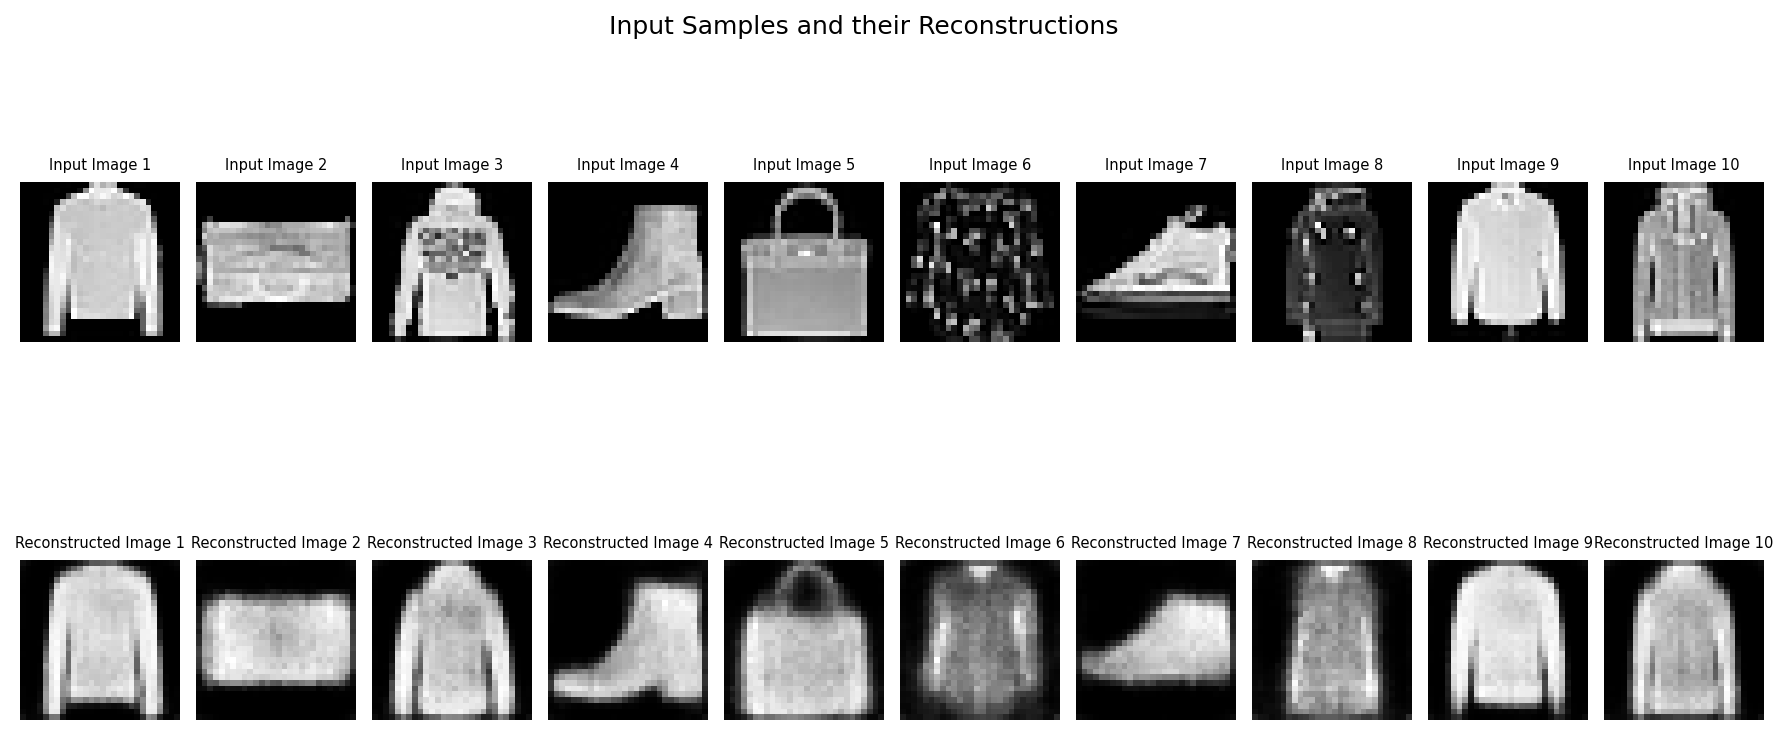

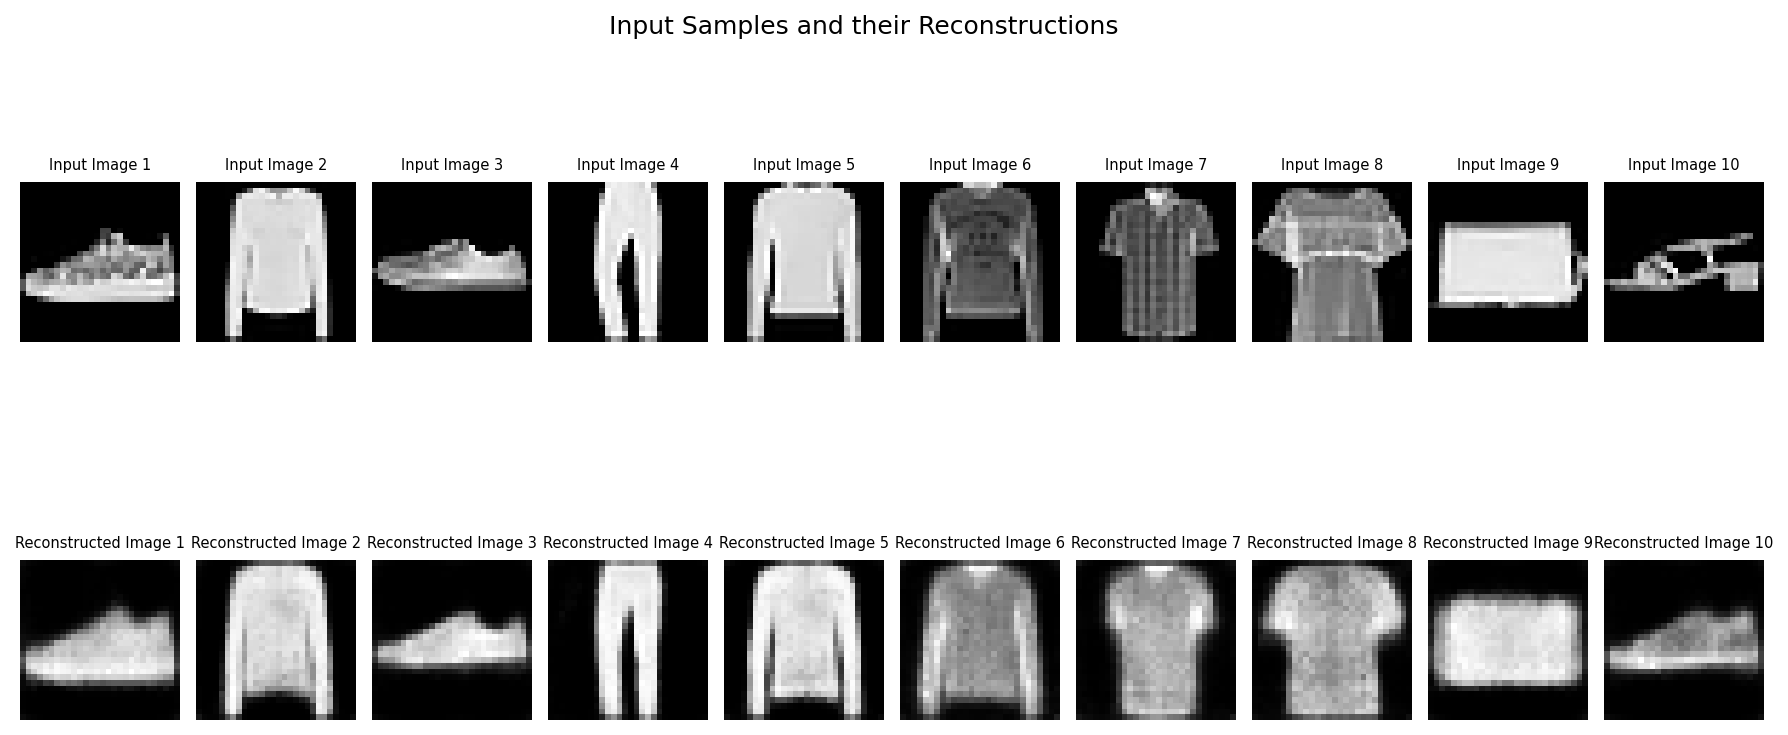

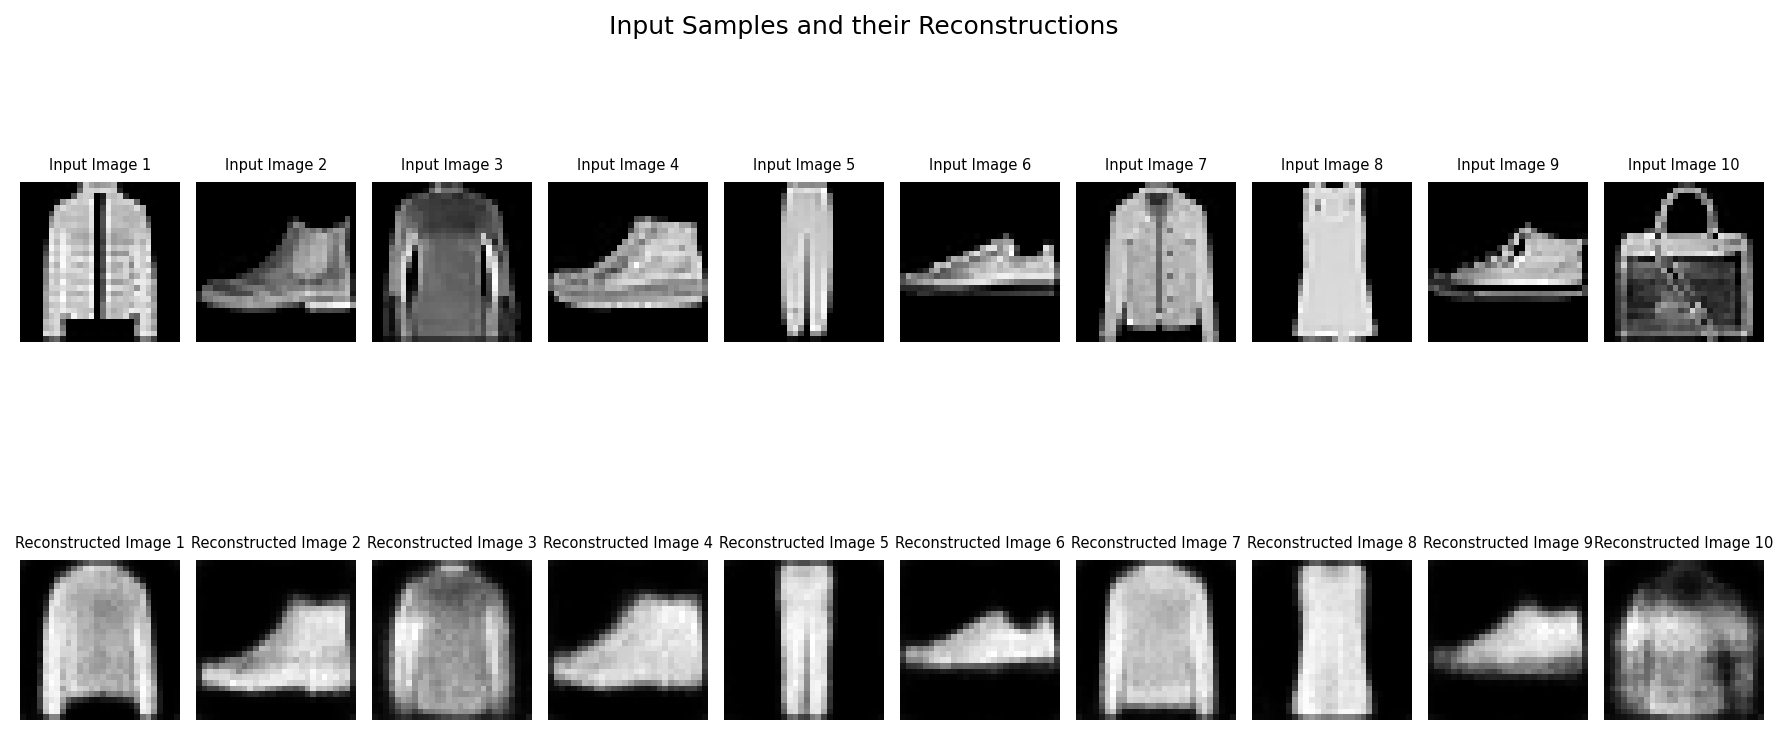

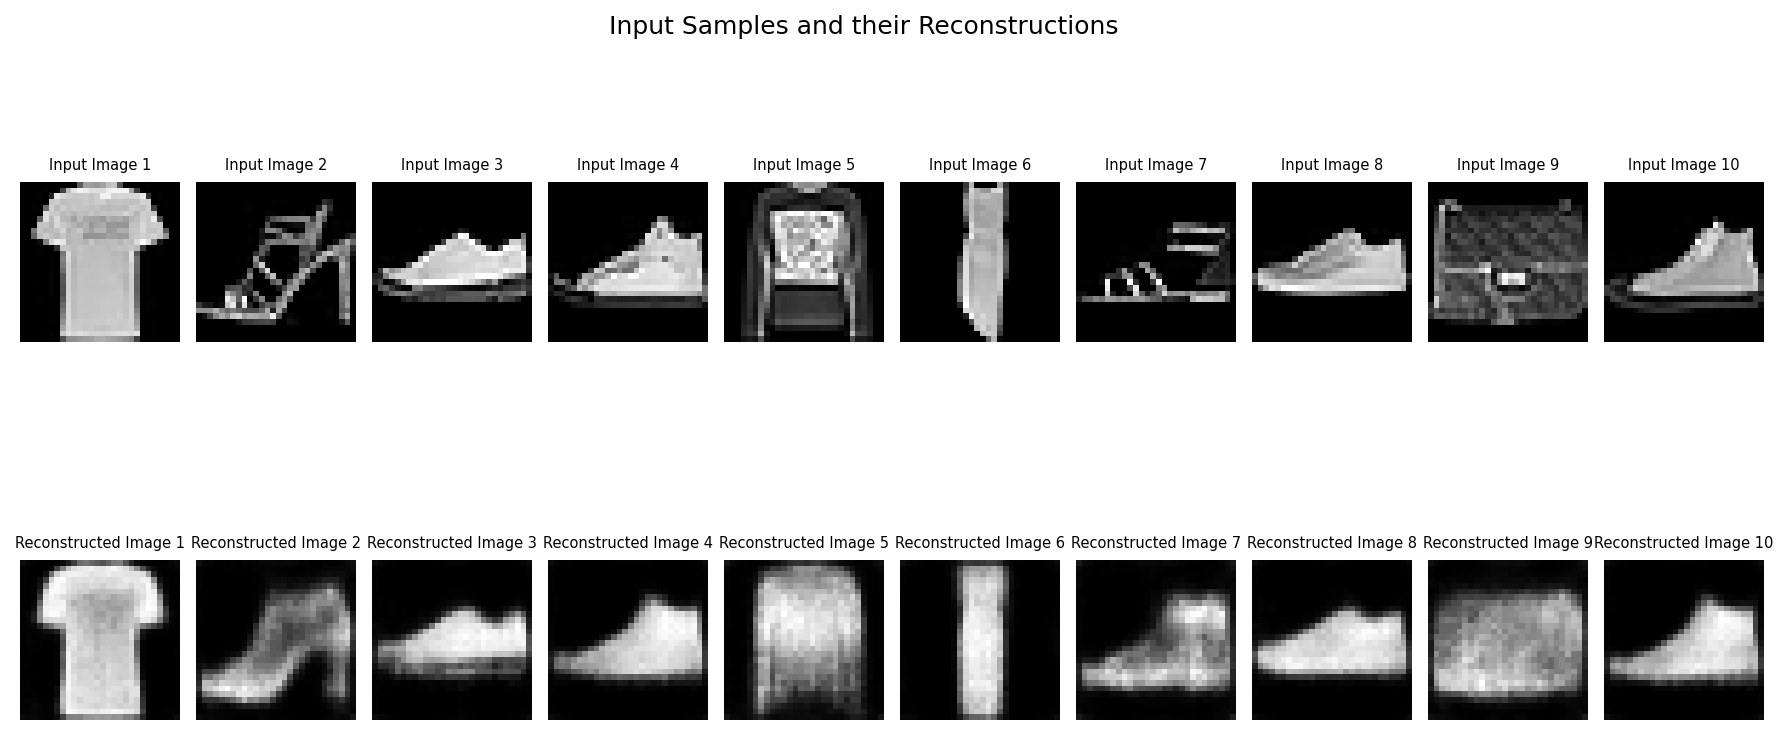

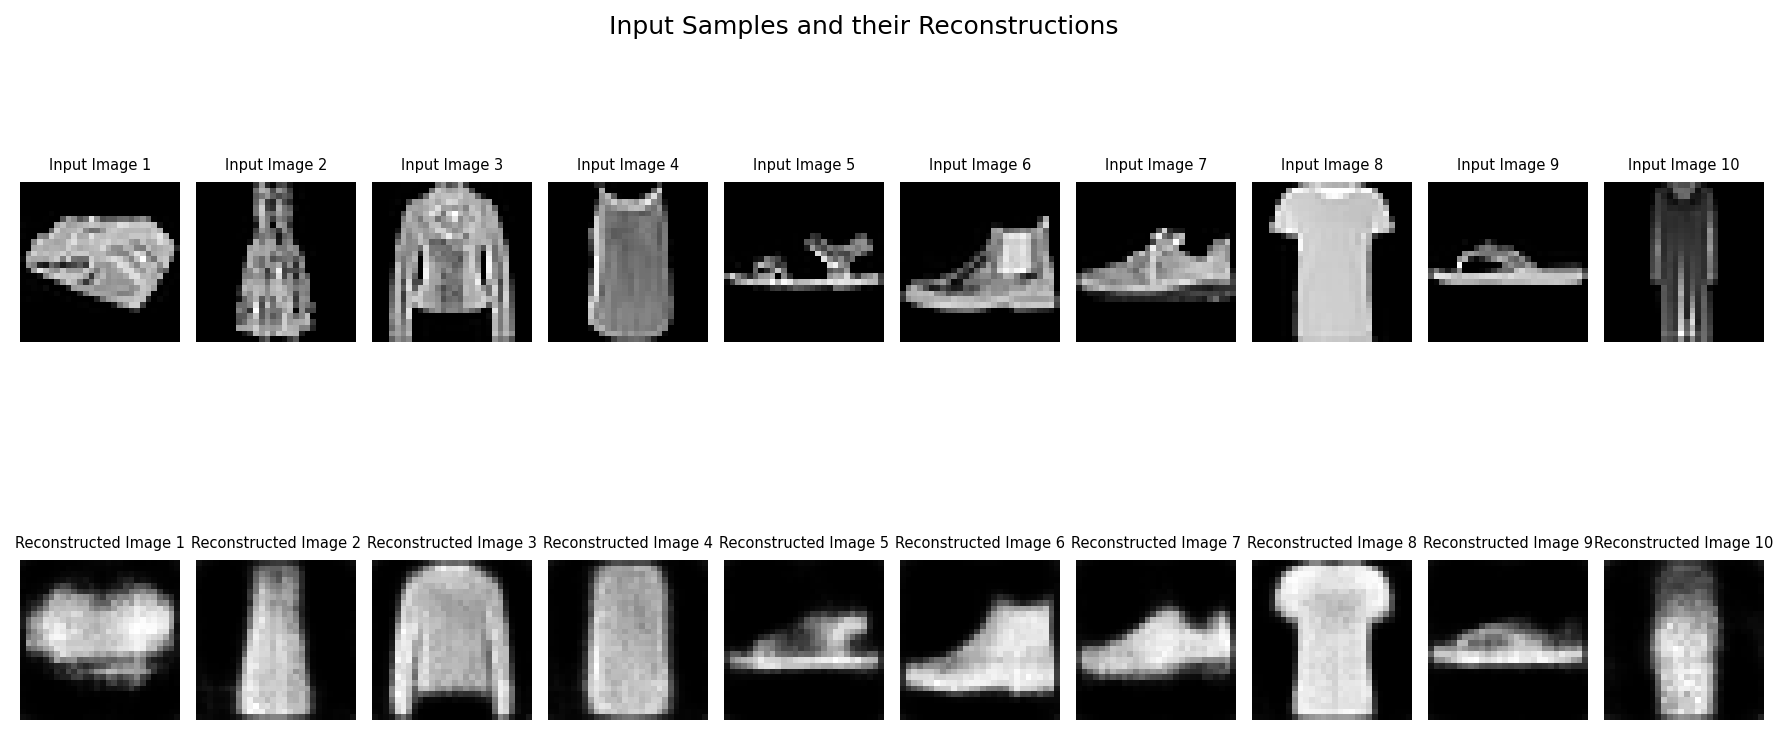

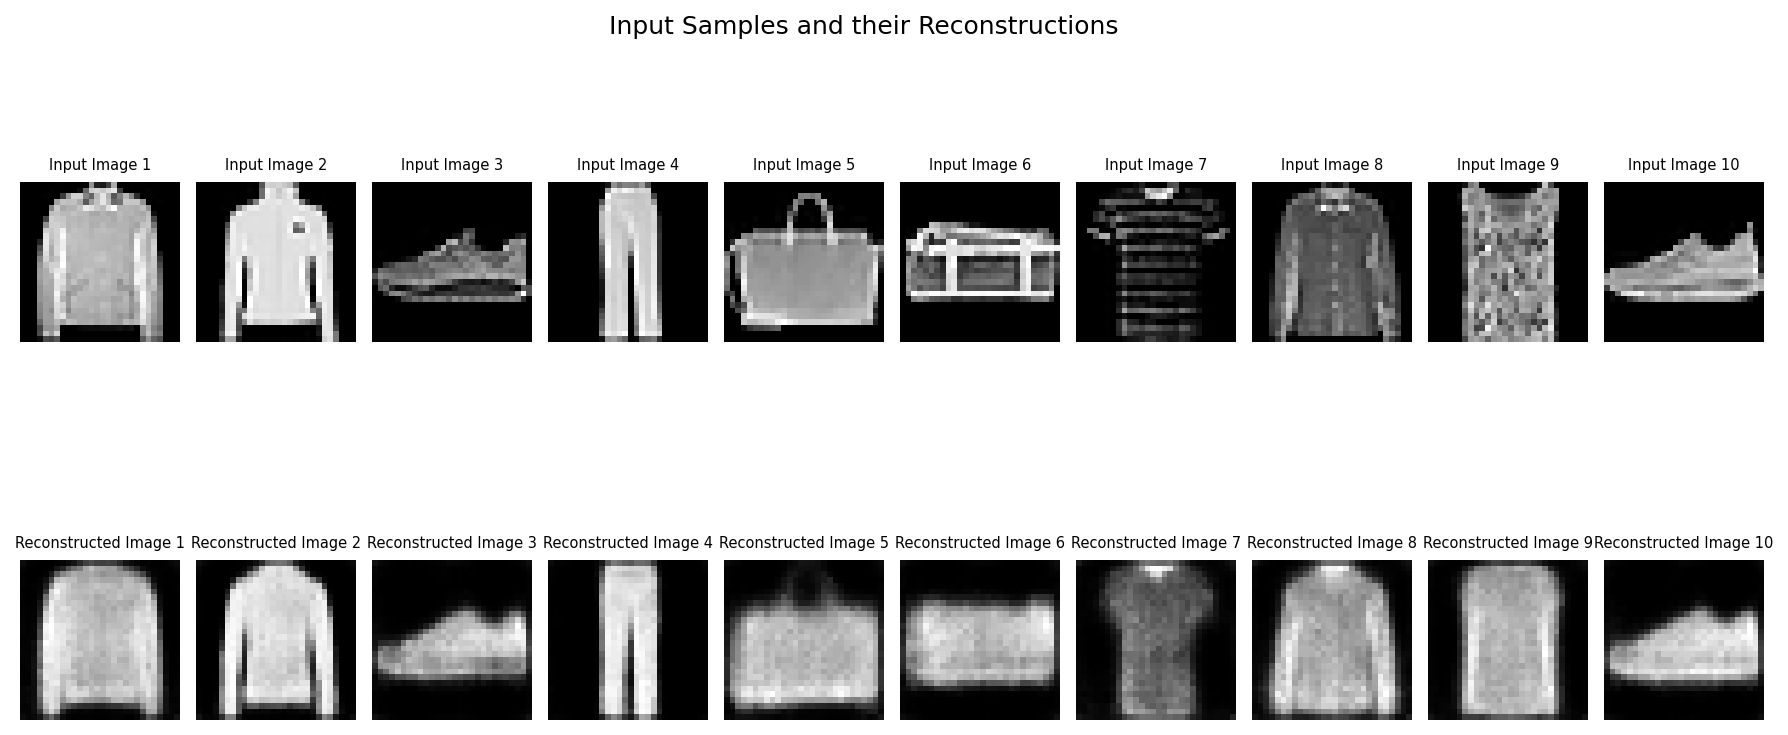

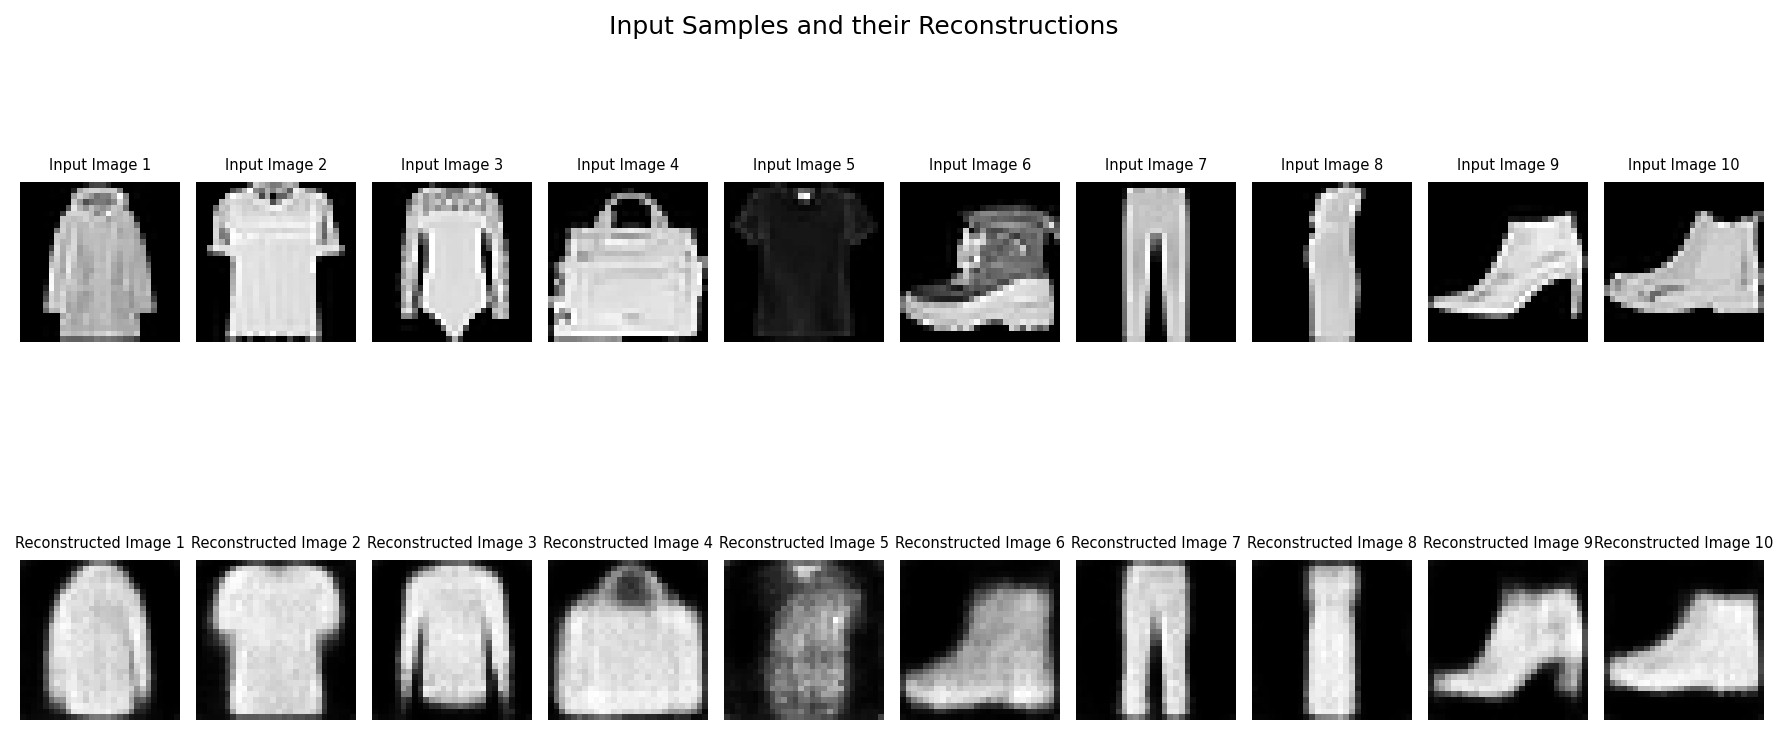

Epoch 1/3, Loss: 0.0778


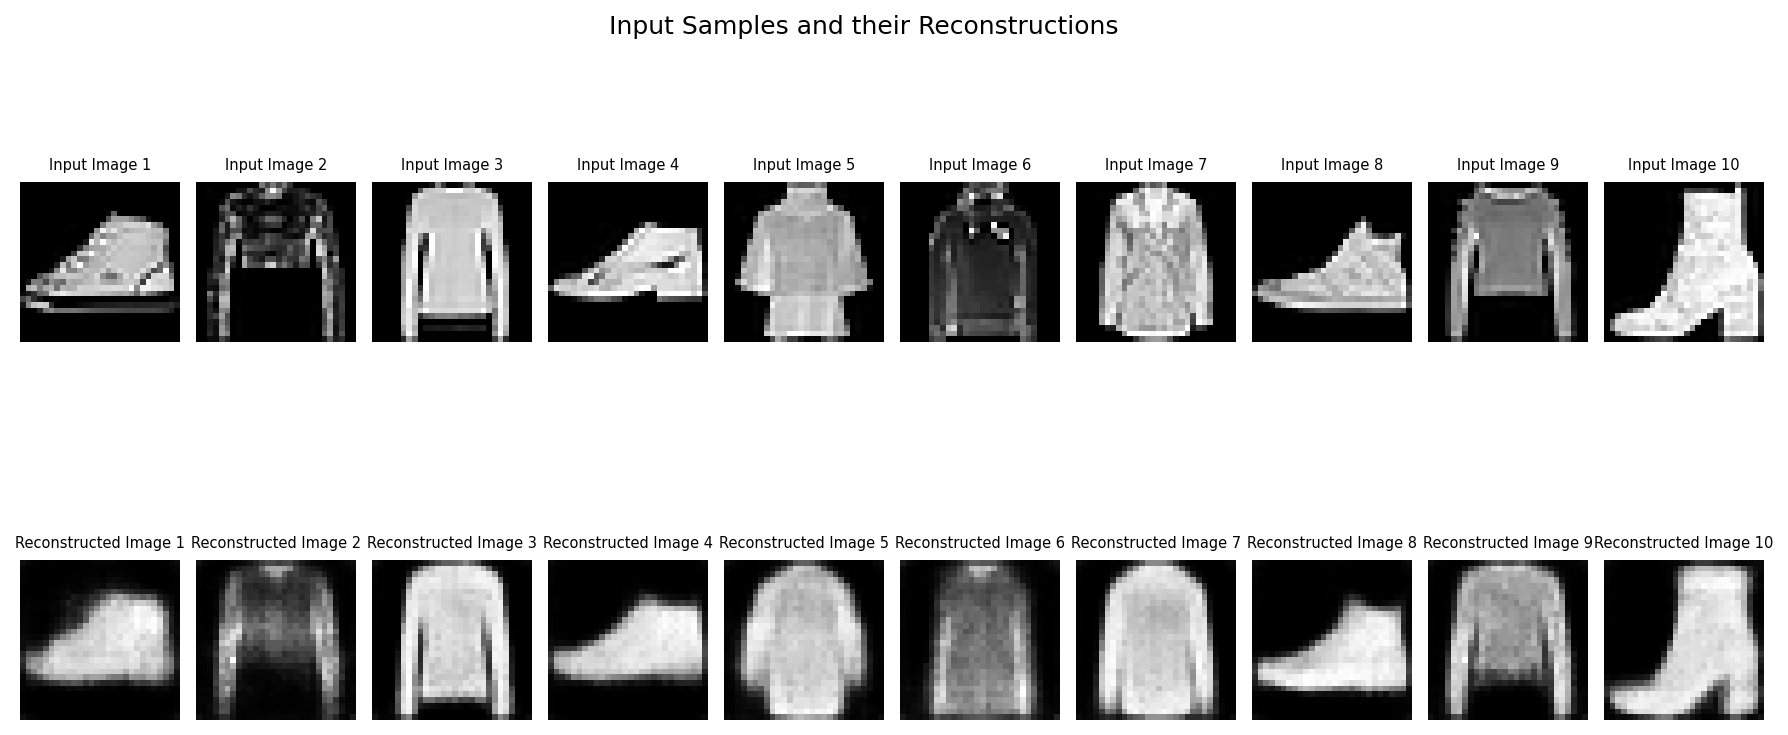

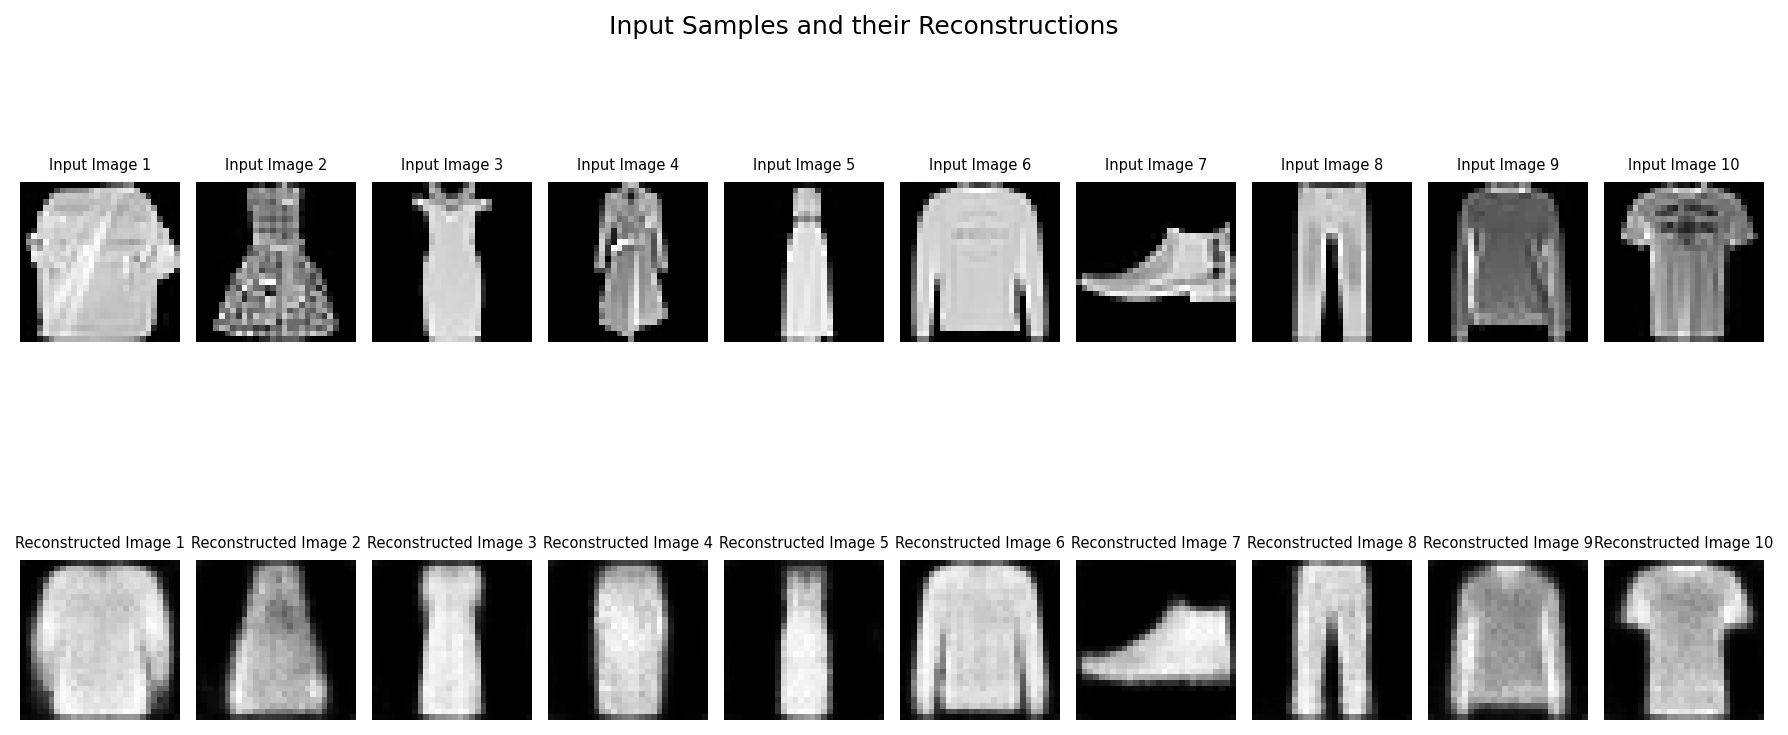

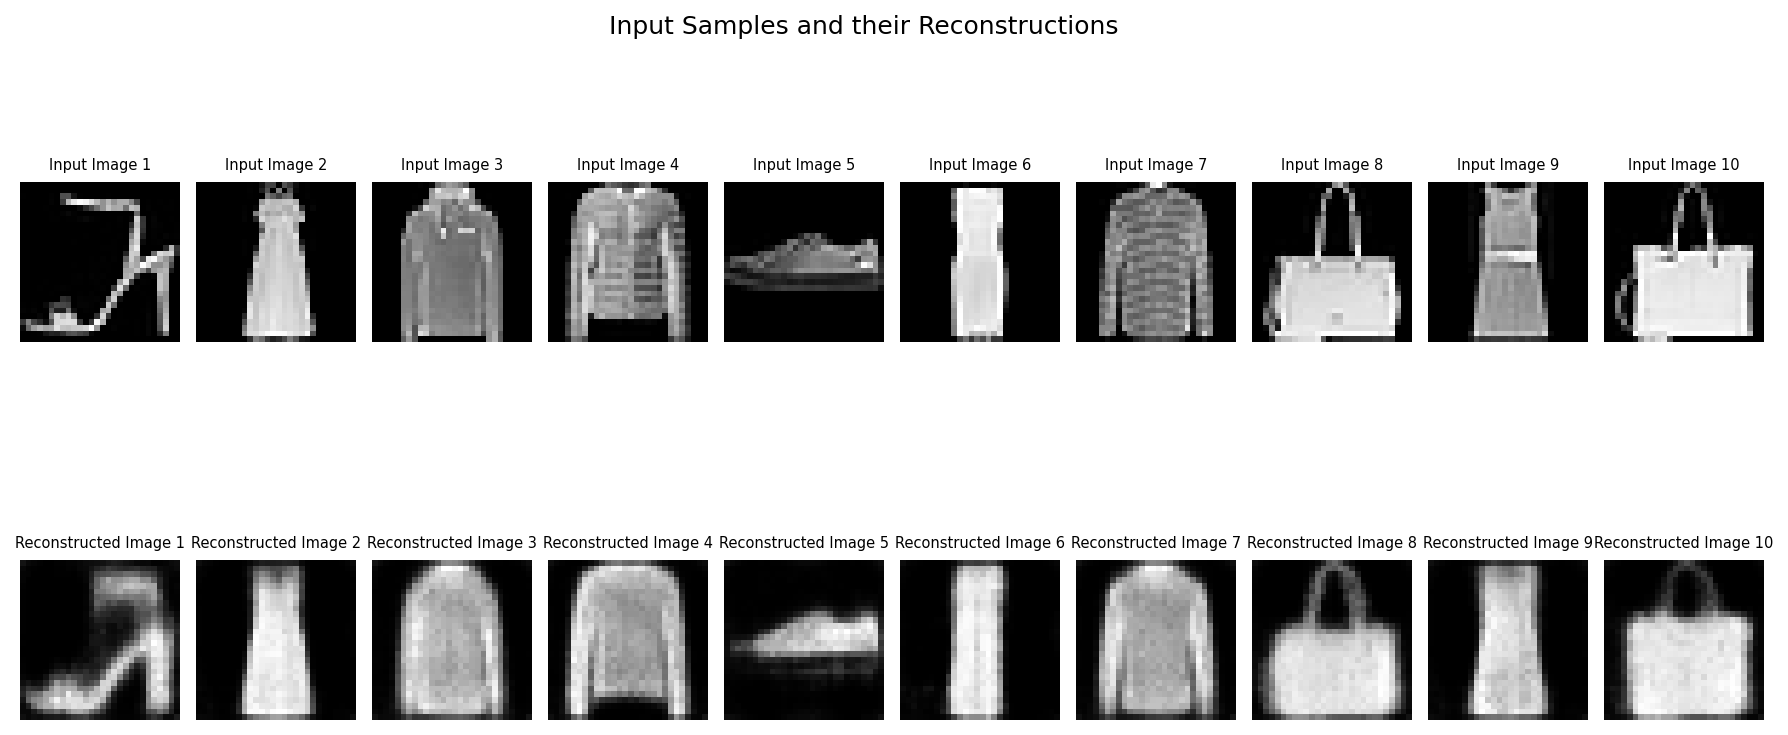

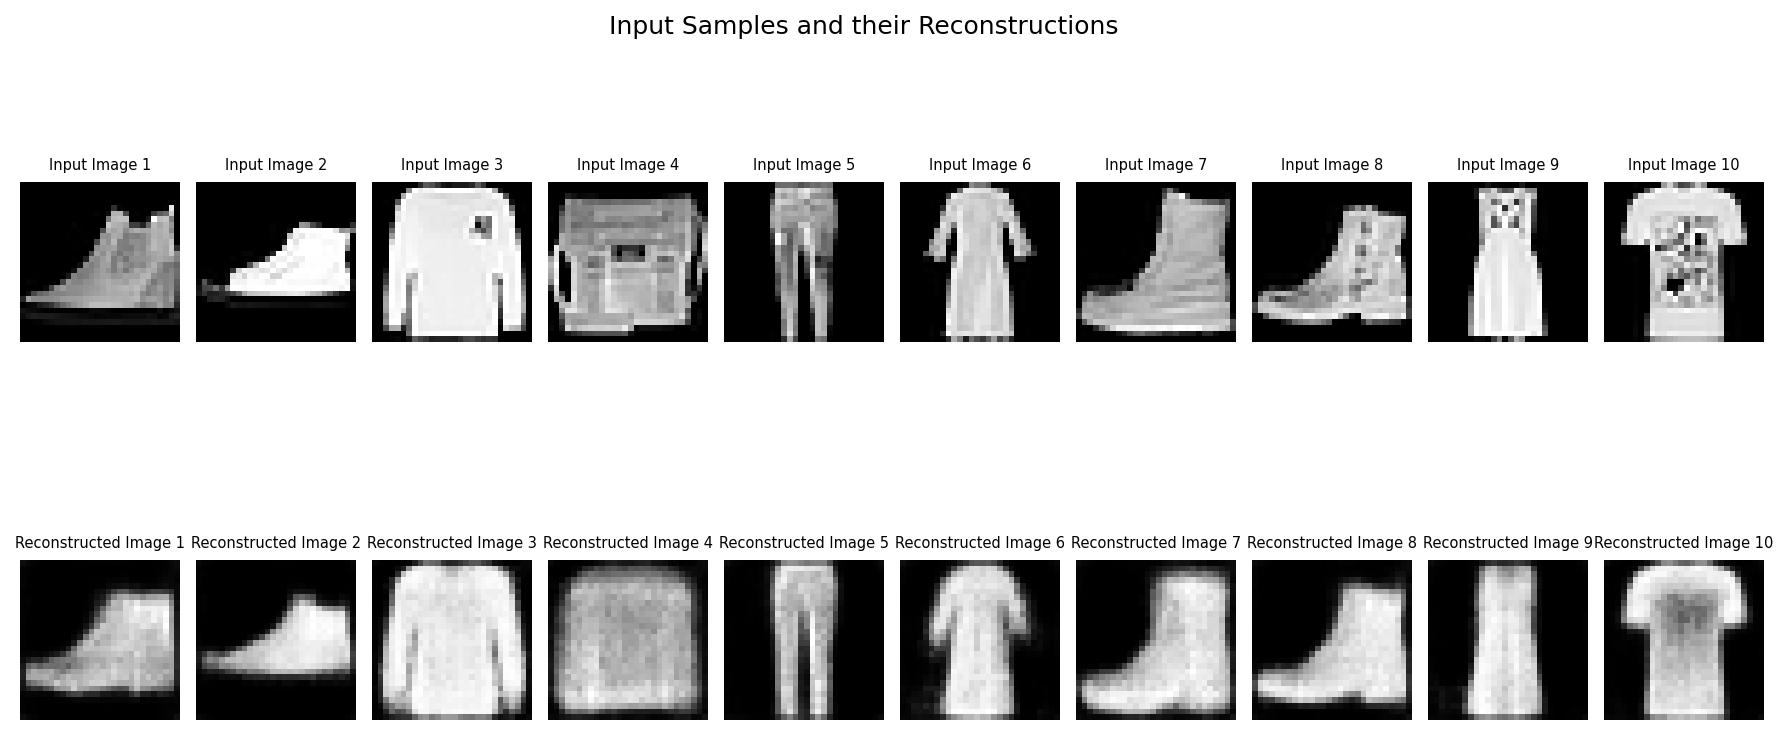

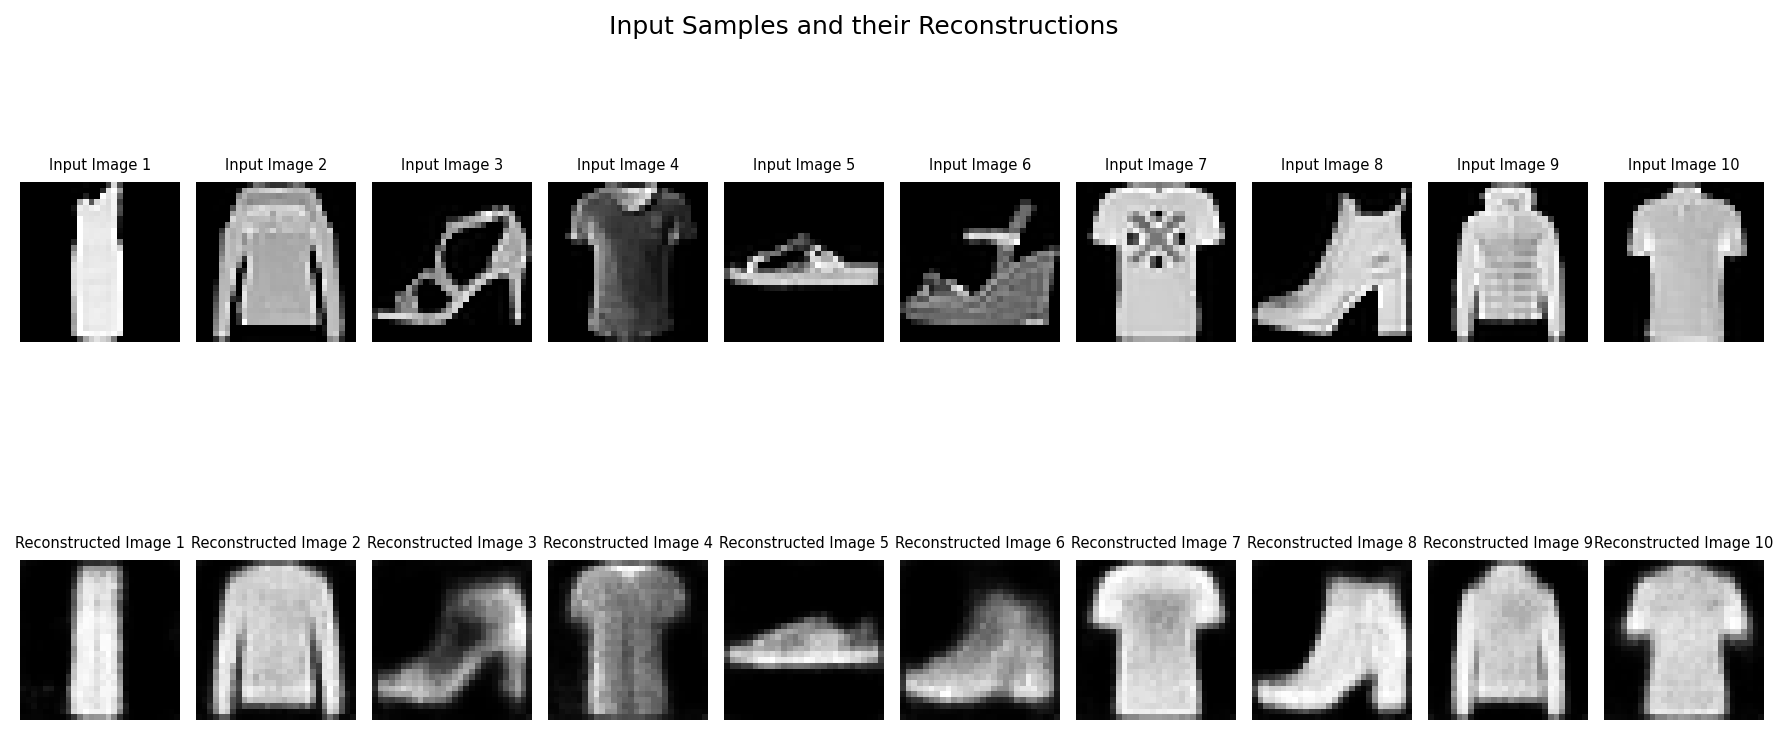

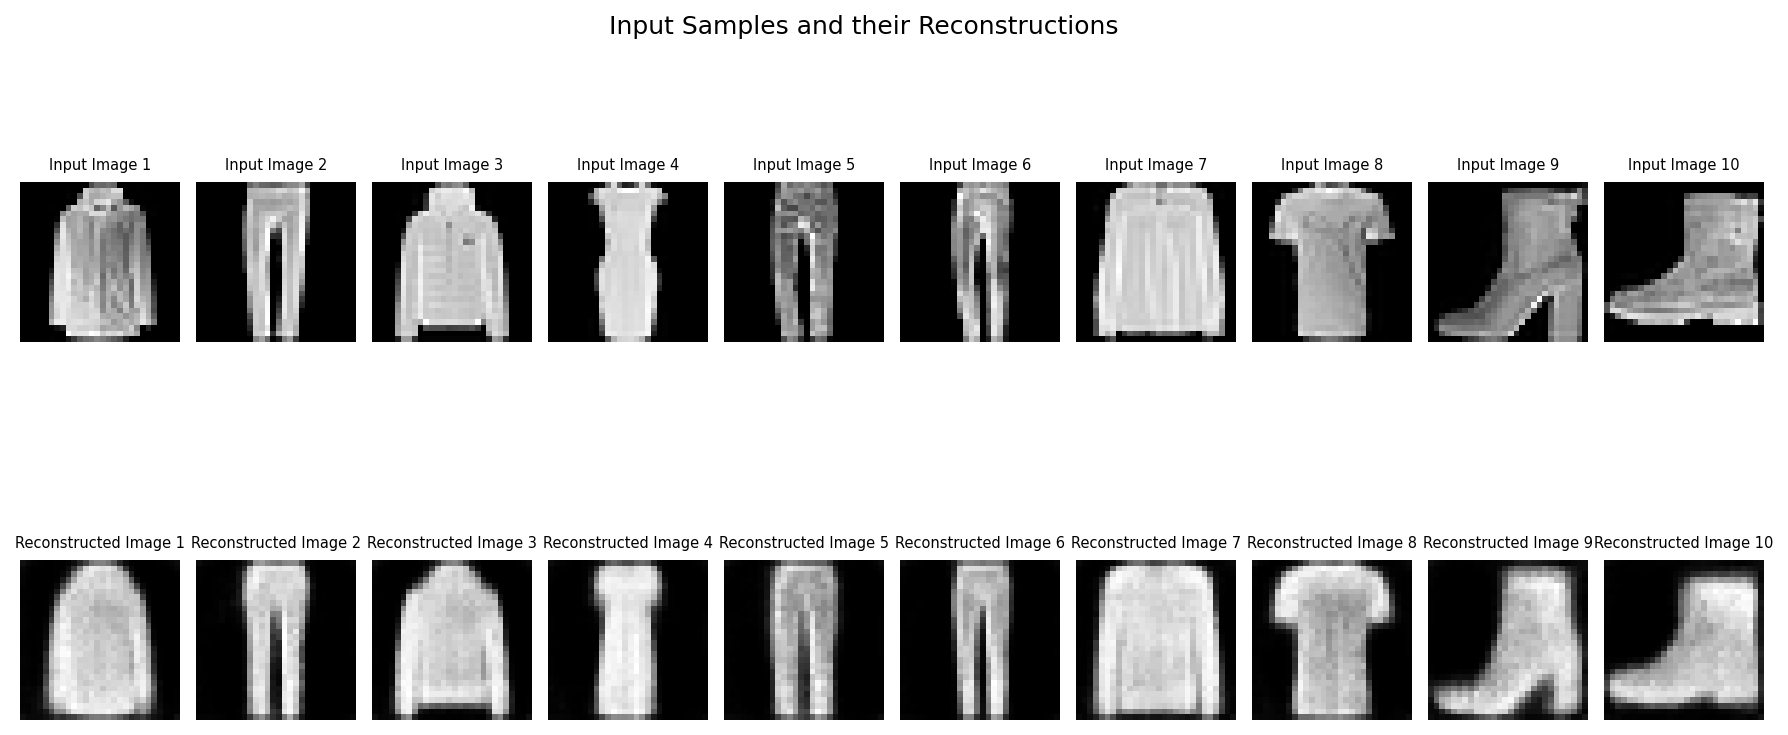

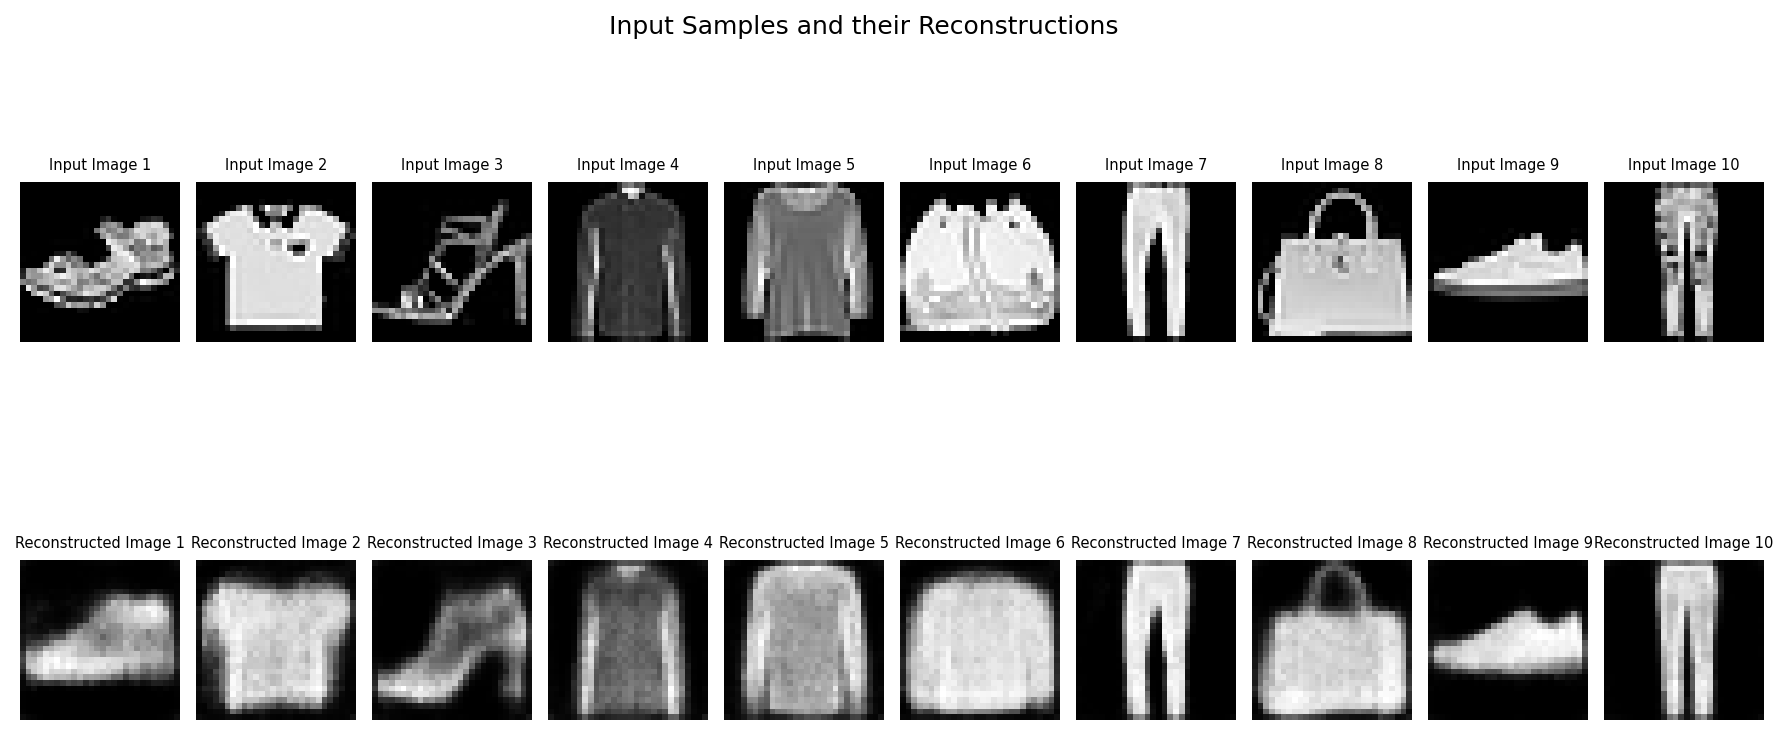

Epoch 2/3, Loss: 0.0780


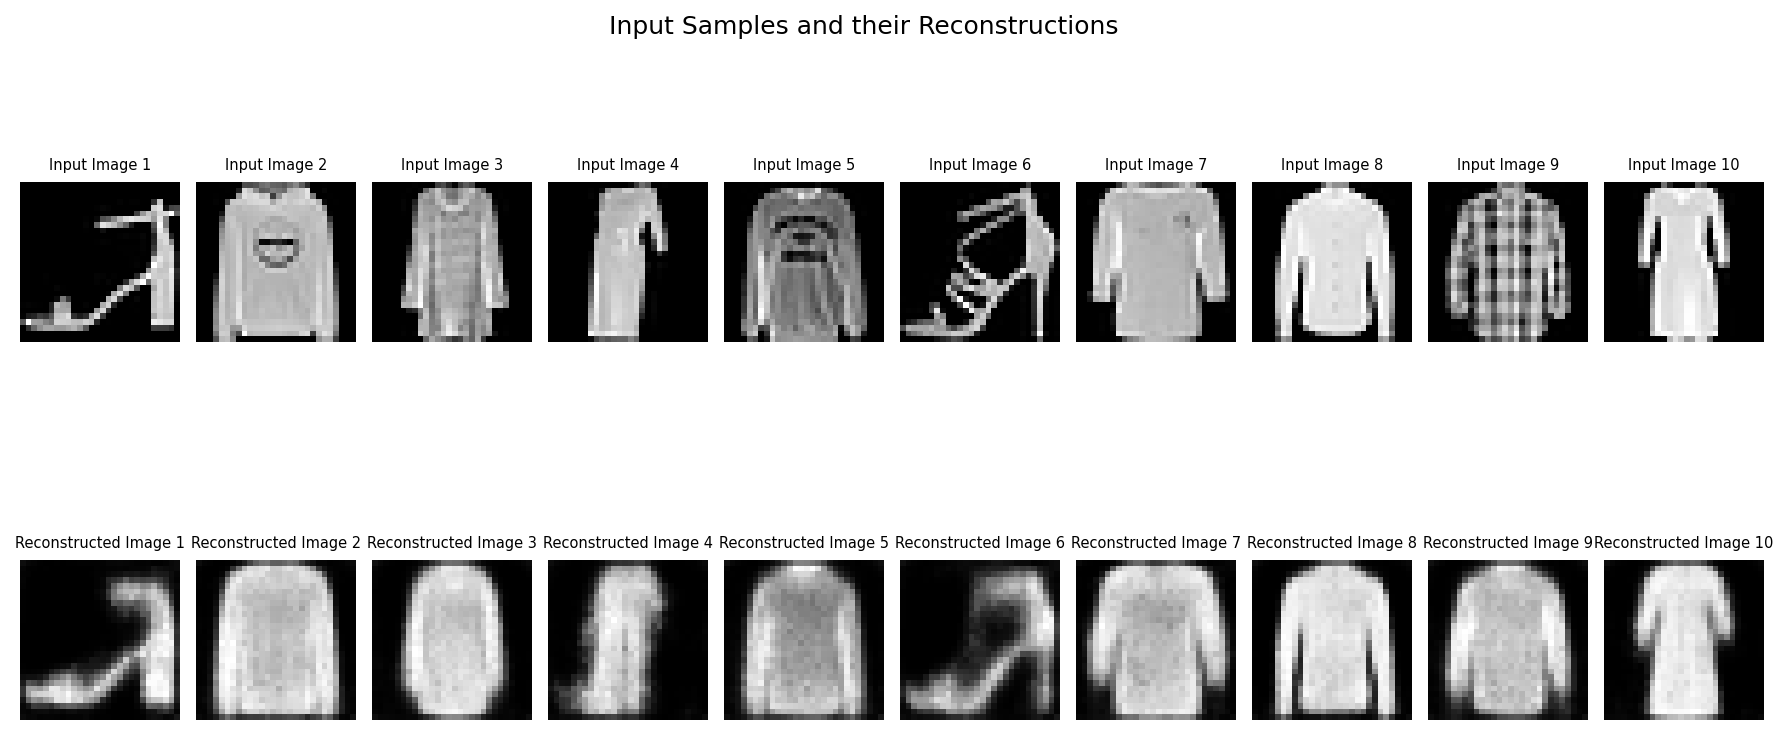

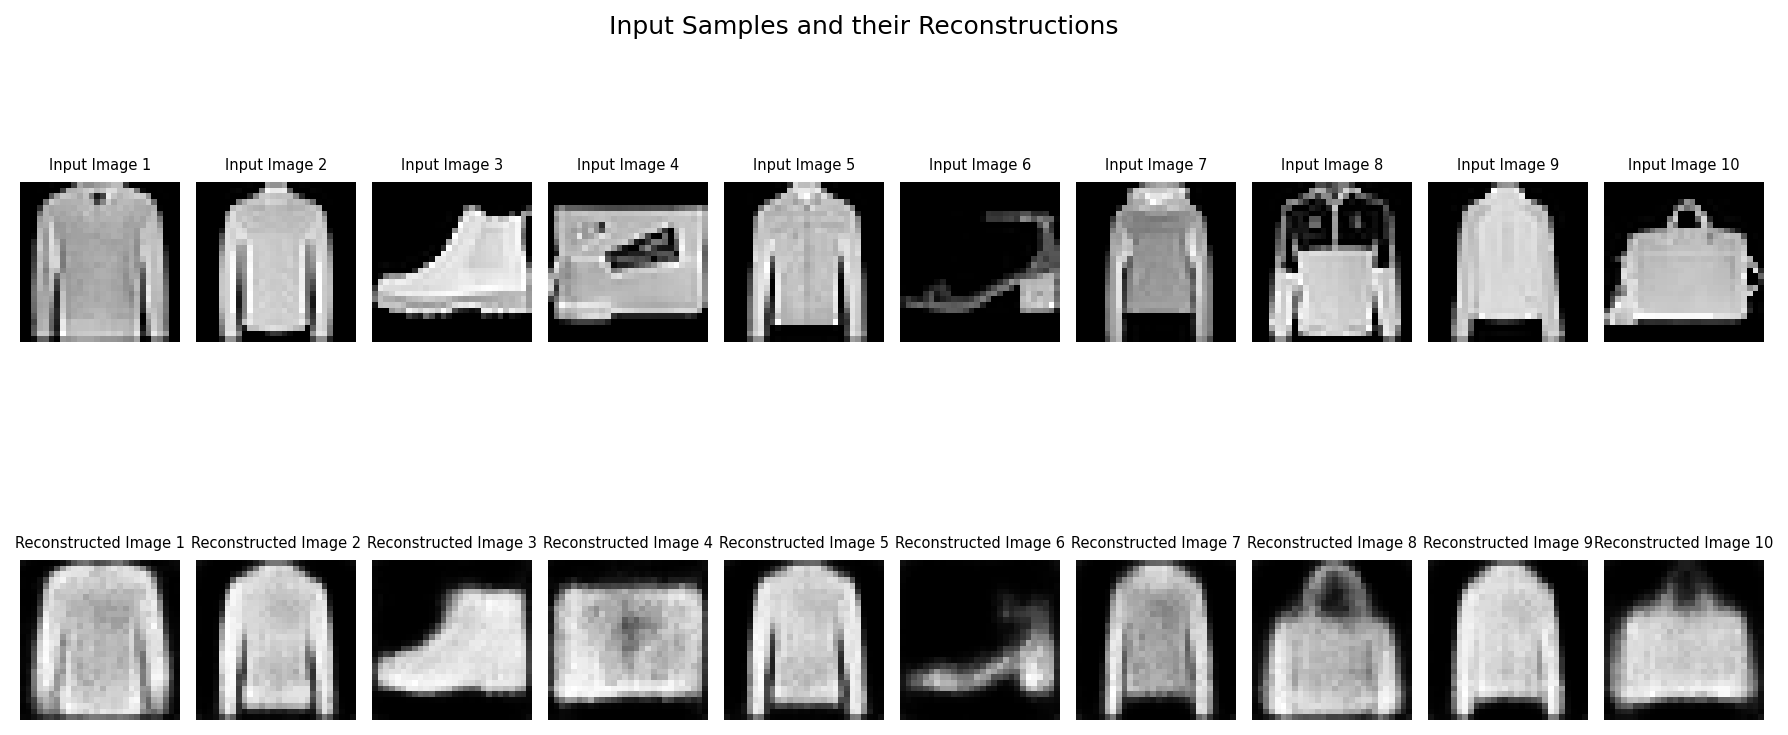

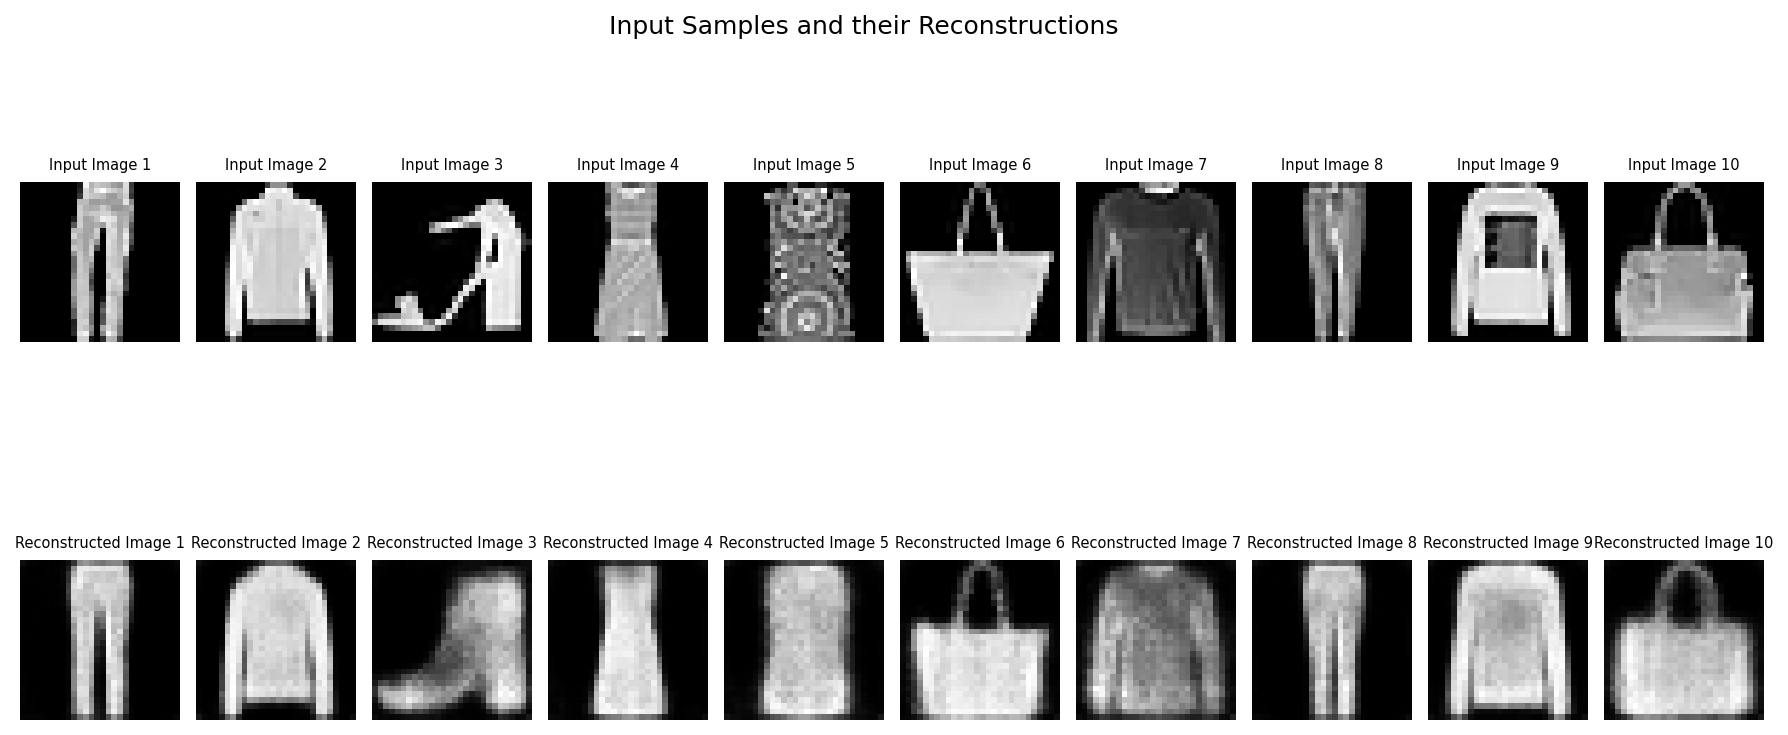

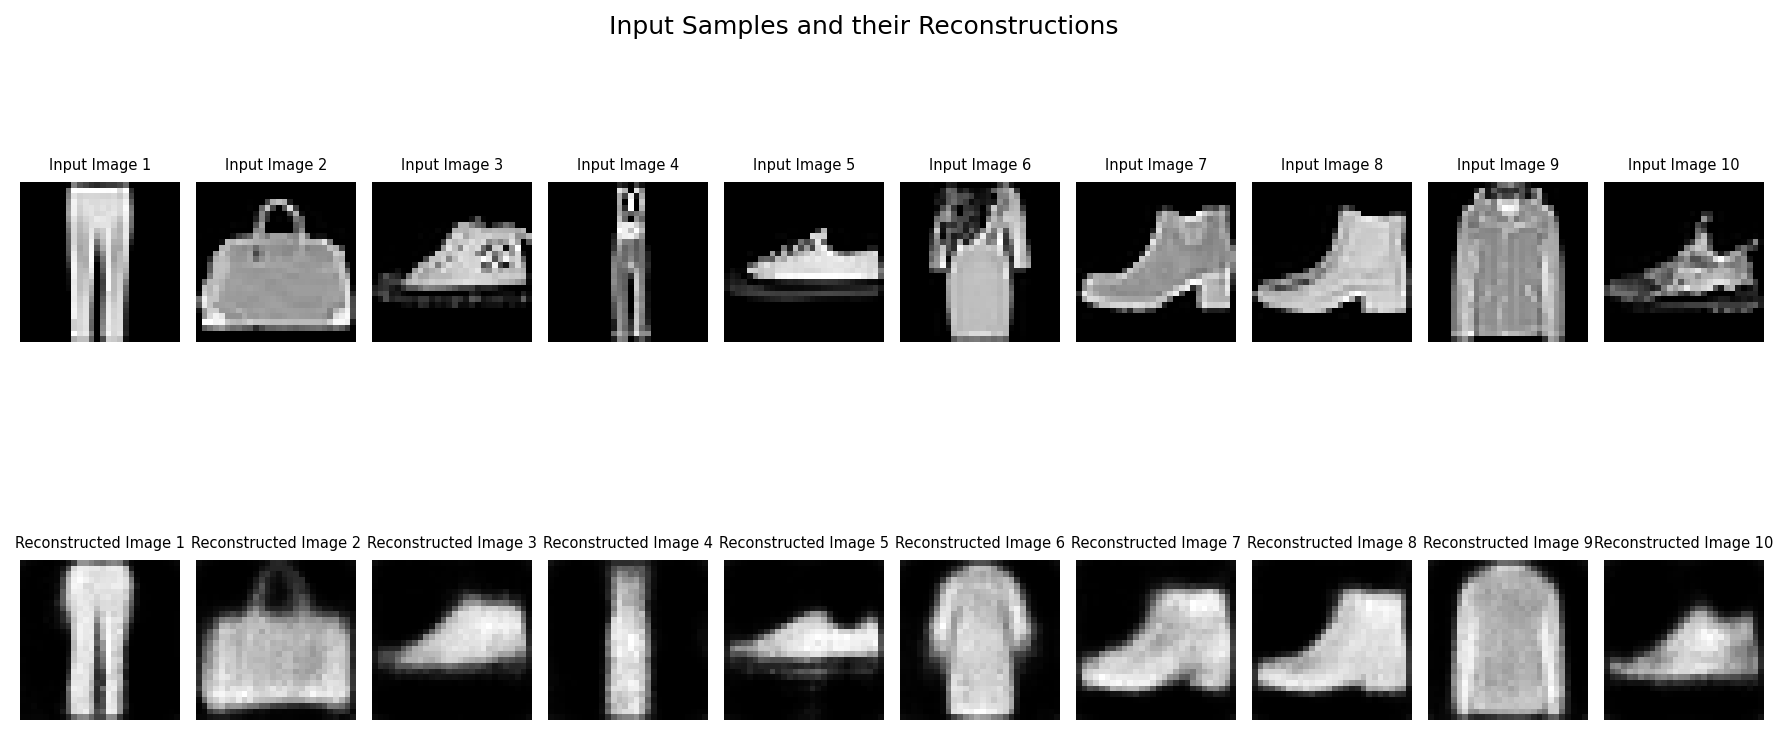

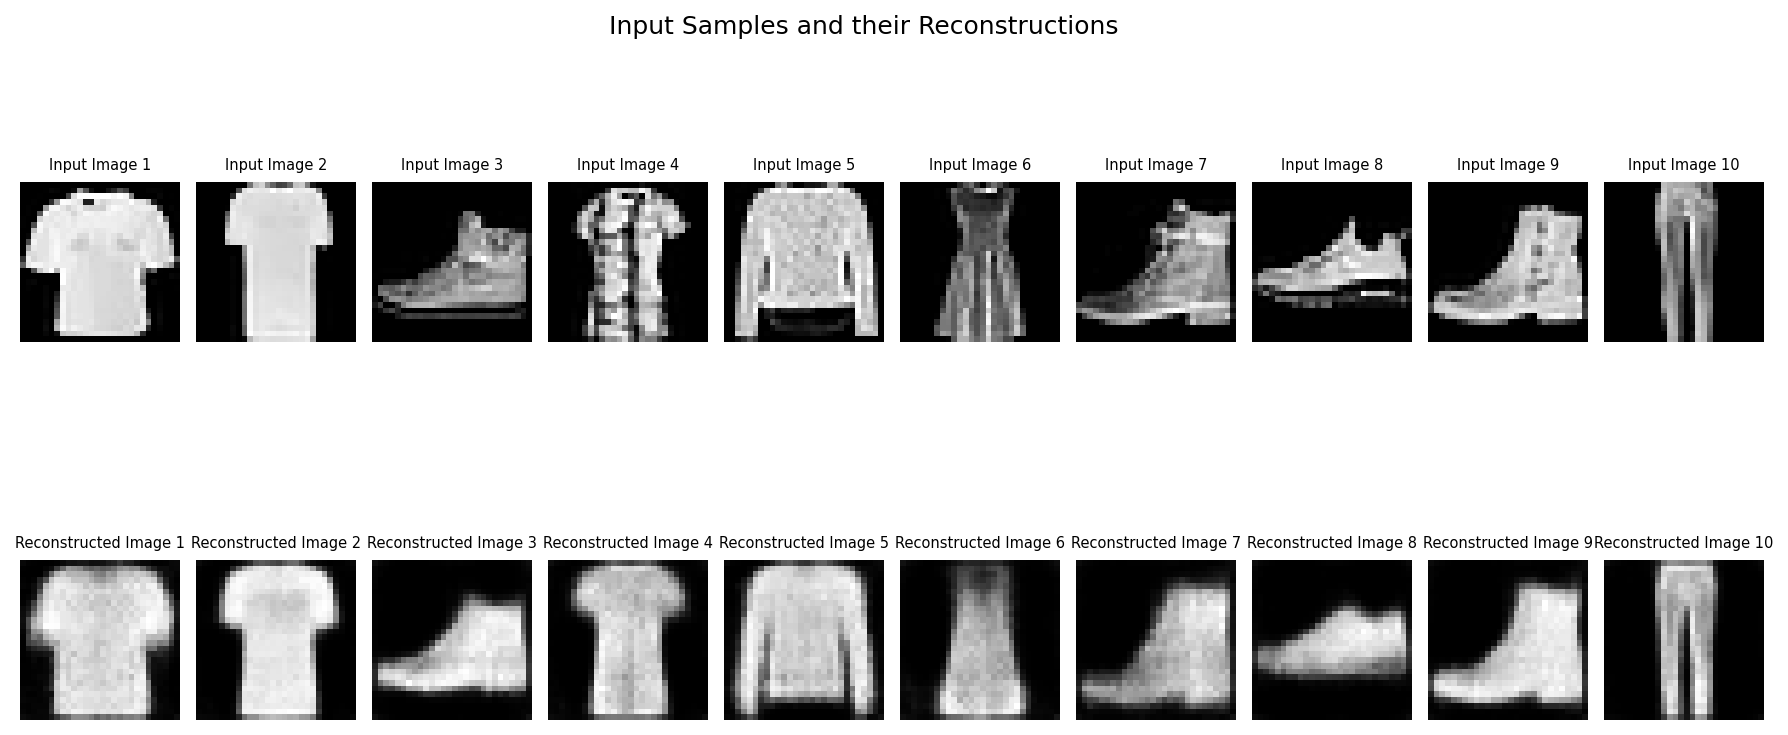

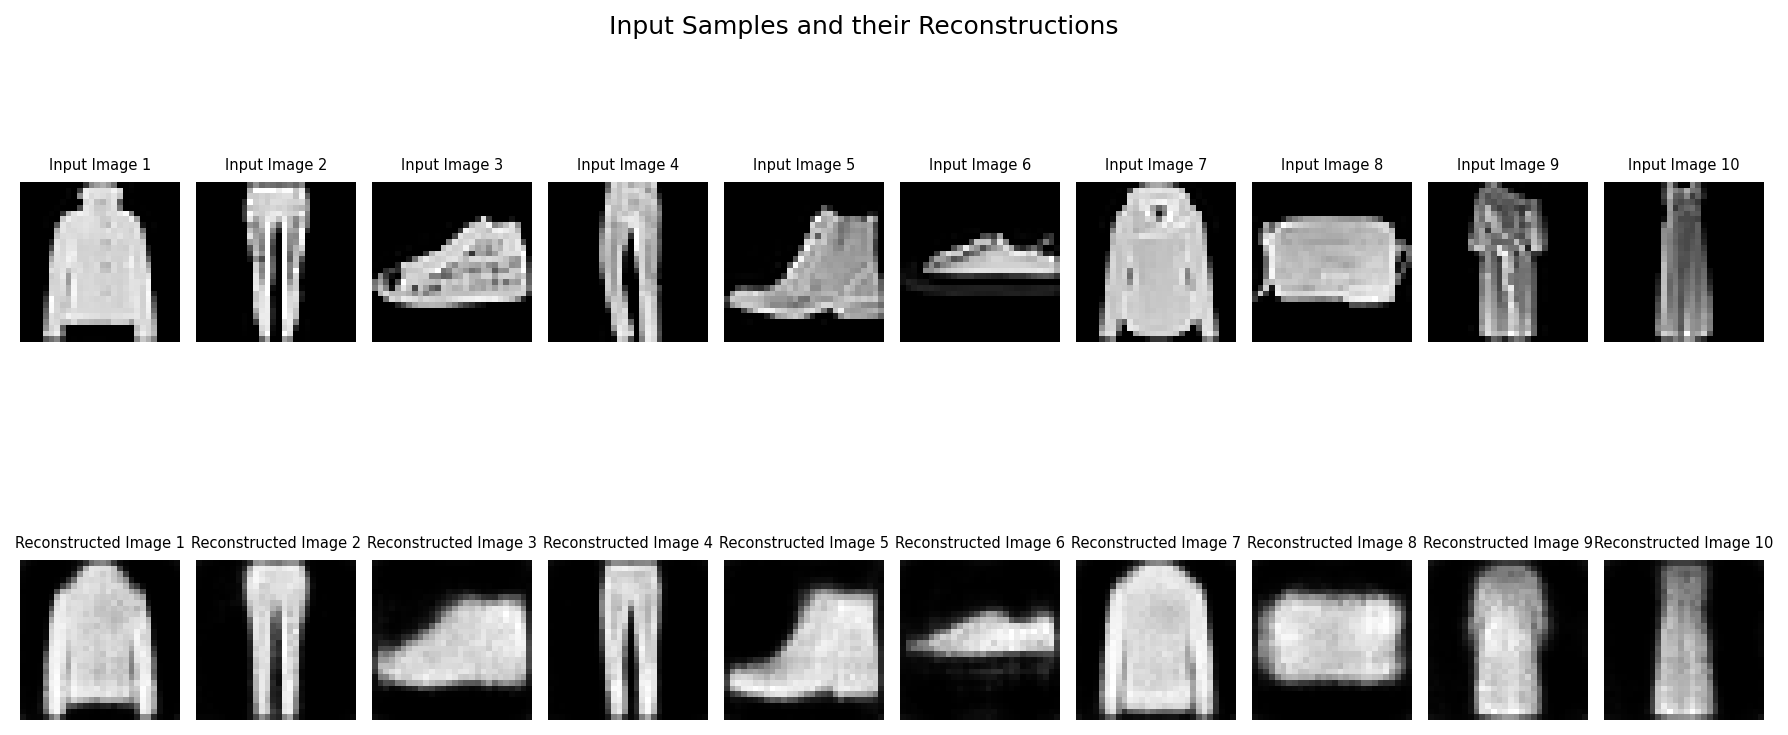

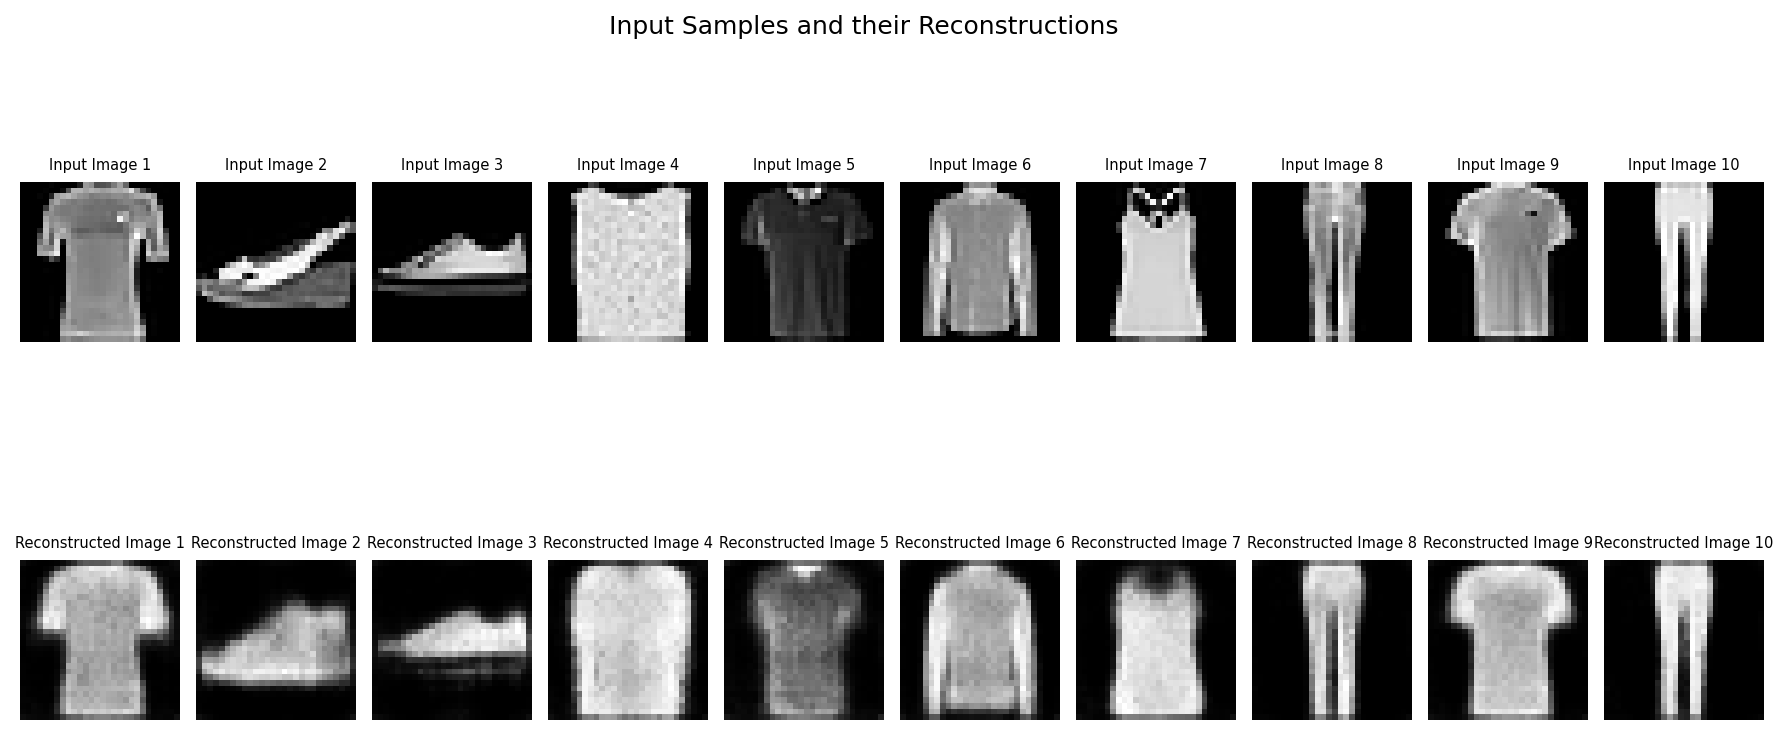

Epoch 3/3, Loss: 0.0778


In [26]:
# 3.4 During the computation of the testing loss plot ten input samples as well as their reconstructions produced by the autoencoder
# test the model
for epoch in range(EPOCHS):
    test_loss = test(conv_autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {test_loss:.4f}')

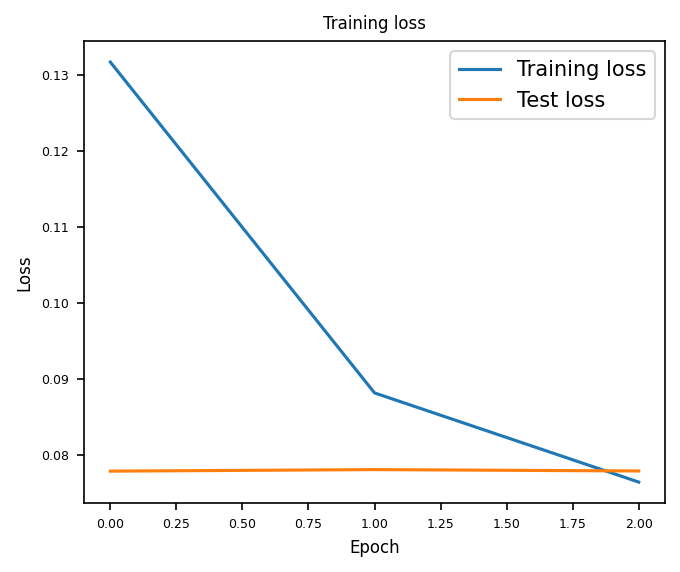

In [27]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss', path=RESULTS_DIR+'conv_ae_loss_curve.png')

**3.5 Compare the performance of this model to the model from the prior task**

* The model with Convolutional Layers demonstrates a greater capacity for learning patterns from high-dimensional, 2D spatial data, as the learned filters in a convolutional neural network are designed to recognize more complex local patterns. In contrast, linear models are less equipped to handle this task.
* Upon visualizing the learned lower-dimensional latent space Z of the encoder with linear layers, it is evident that the latent space scatter plots per class exhibit a linear structure. This suggests that the linear encoder also primarily captures linear relationships in the data.
* In contrast, when examining the components of the latent space of the convolutional encoder, it is clear that the convolutional layers have facilitated a more effective projection of the encoded input values into the latent space. The presence of distinct, separable clusters in the convolutional encoder's latent space indicates that this model is able to capture more complex, non-linear relationships in the data.
* Furthermore, the expressiveness and capacity of the convolutional encoder are shown to be superior to the linear encoder. This may be due to the limitations of a linear transformation when mapping input data into the latent space, where the relationship between the input features and the latent space is strictly linear. As a result, each class is also only represented by a linearly separable region, which may not reflect the true underlying patterns in the input data. The convolutional encoder, however, is not restricted by such linear assumptions and is therefore more capable of transforming the input data into a non-linear latent space. The result visible in the training and testing loss curve is also reflected in the reconstruction of the decoder, which shows higher capacity to reconstruct output images close to the input data distribution than the linear encoder.

## Denoising Convolutional Autoencoder

In [28]:
# train the model with noise
denoise_conv_autoencoder = ConvAutoencoder().to(device)

In [29]:
train_losses = []
test_losses = []

# train the model
for epoch in range(EPOCHS_NOISE):
    start = time.time()
    train_loss = train(denoise_conv_autoencoder, trainloader_noise, optimizer, criterion, device=device)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{EPOCHS_NOISE}, Loss: {train_loss:.4f}, Time: {time.time()-start:.2f} sec')

Epoch 1/3, Loss: 2.3231, Time: 42.33 sec
Epoch 2/3, Loss: 2.3230, Time: 40.06 sec
Epoch 3/3, Loss: 2.3224, Time: 33.75 sec


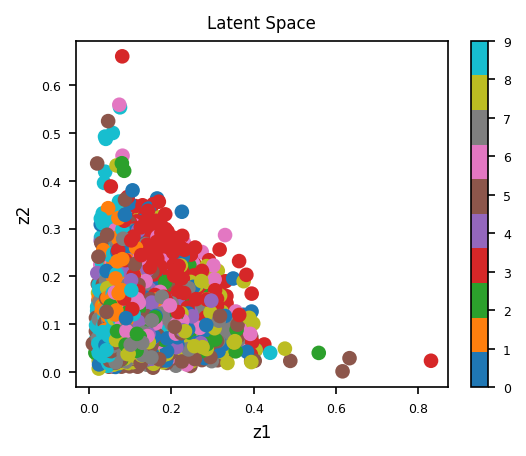

In [30]:
# Plot the latent space
plot_latent(denoise_conv_autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}aeconv_latent_with_noise.png')

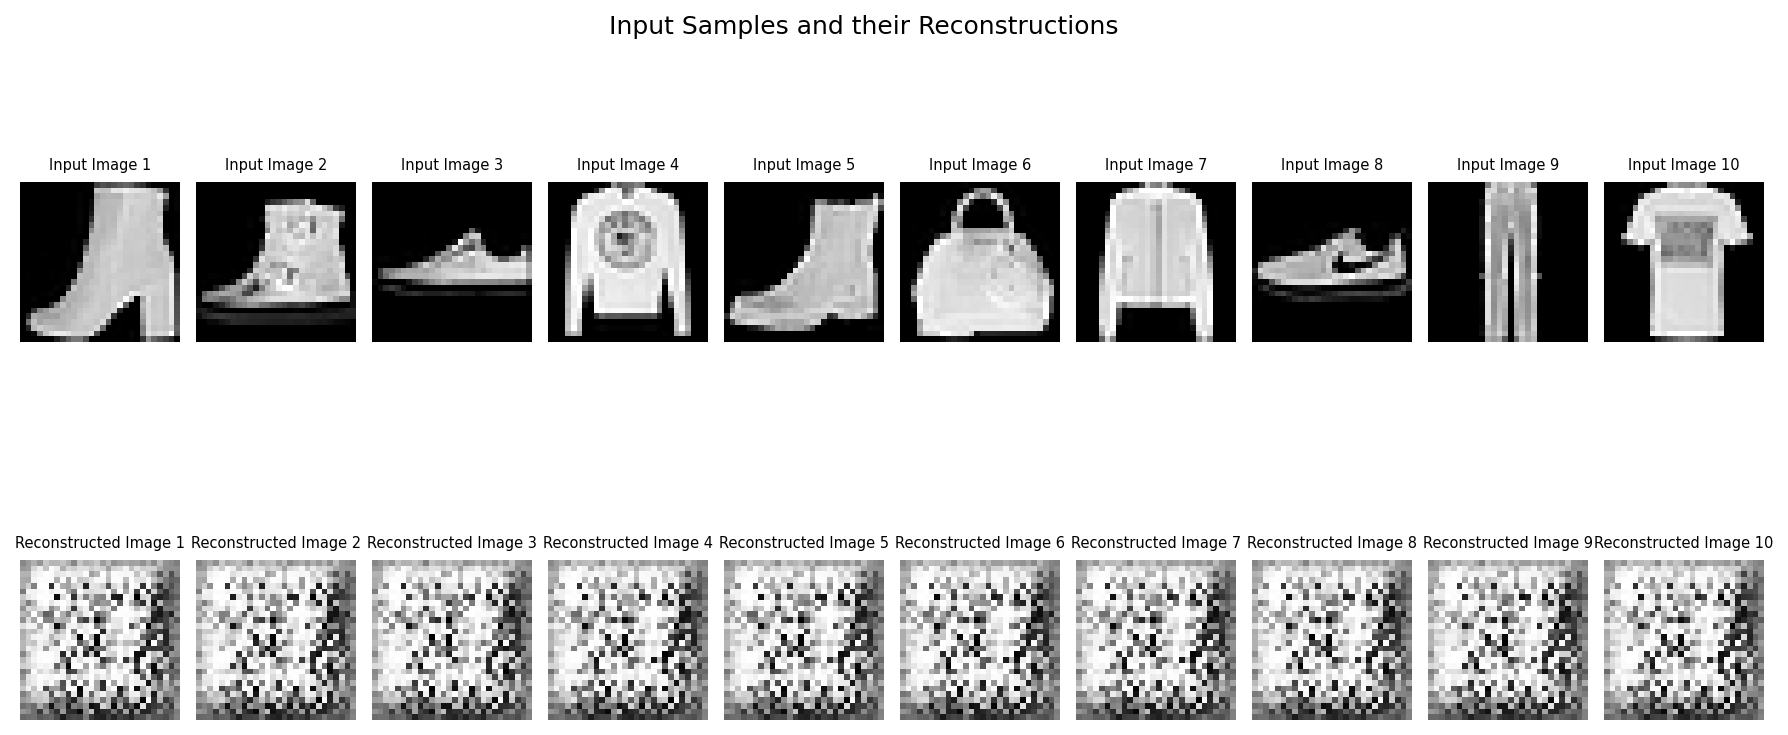

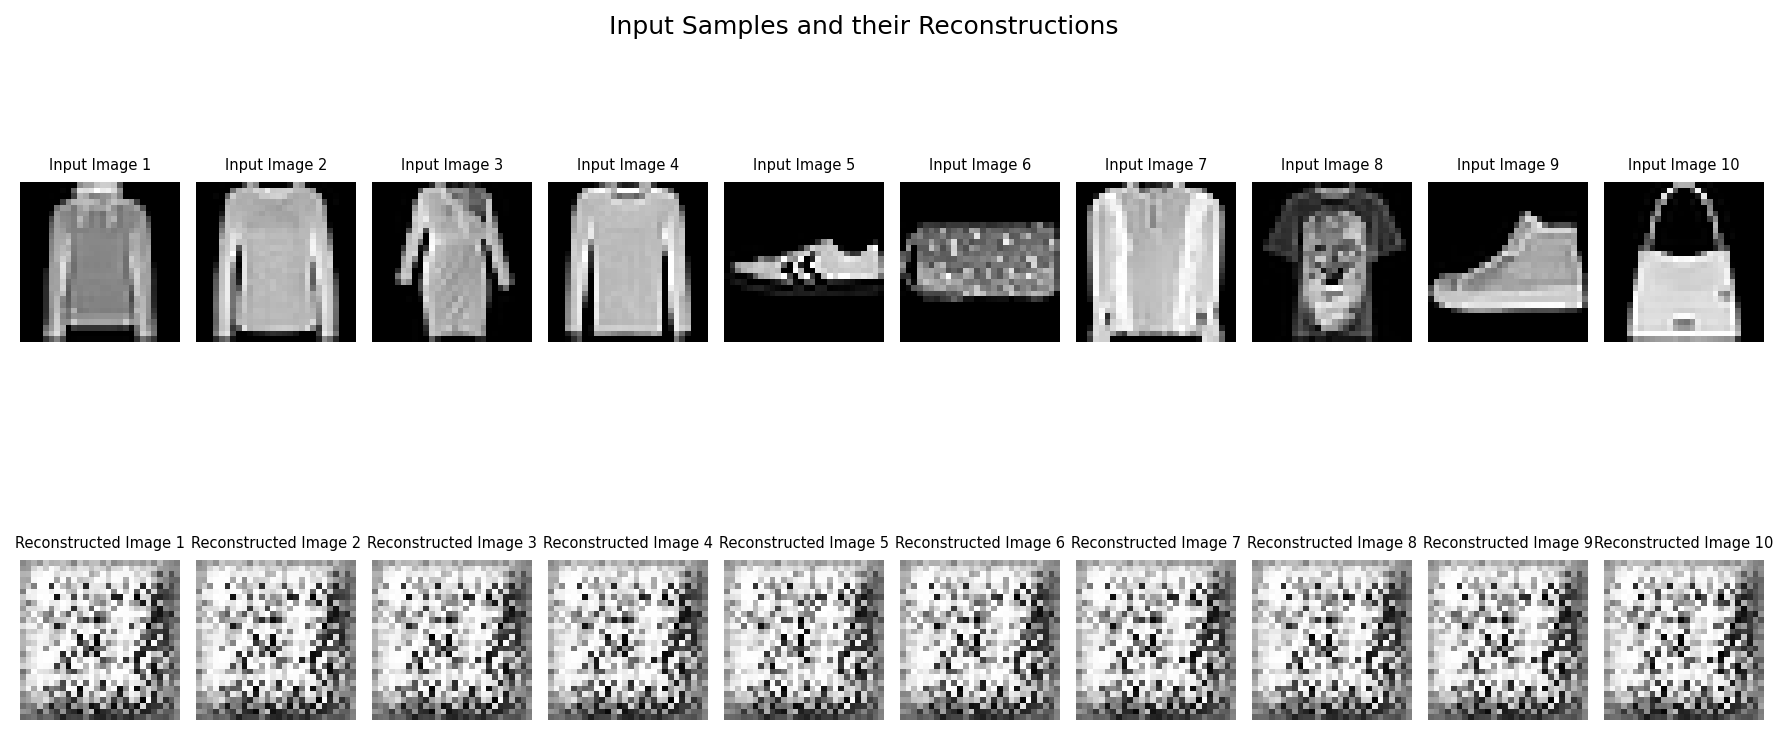

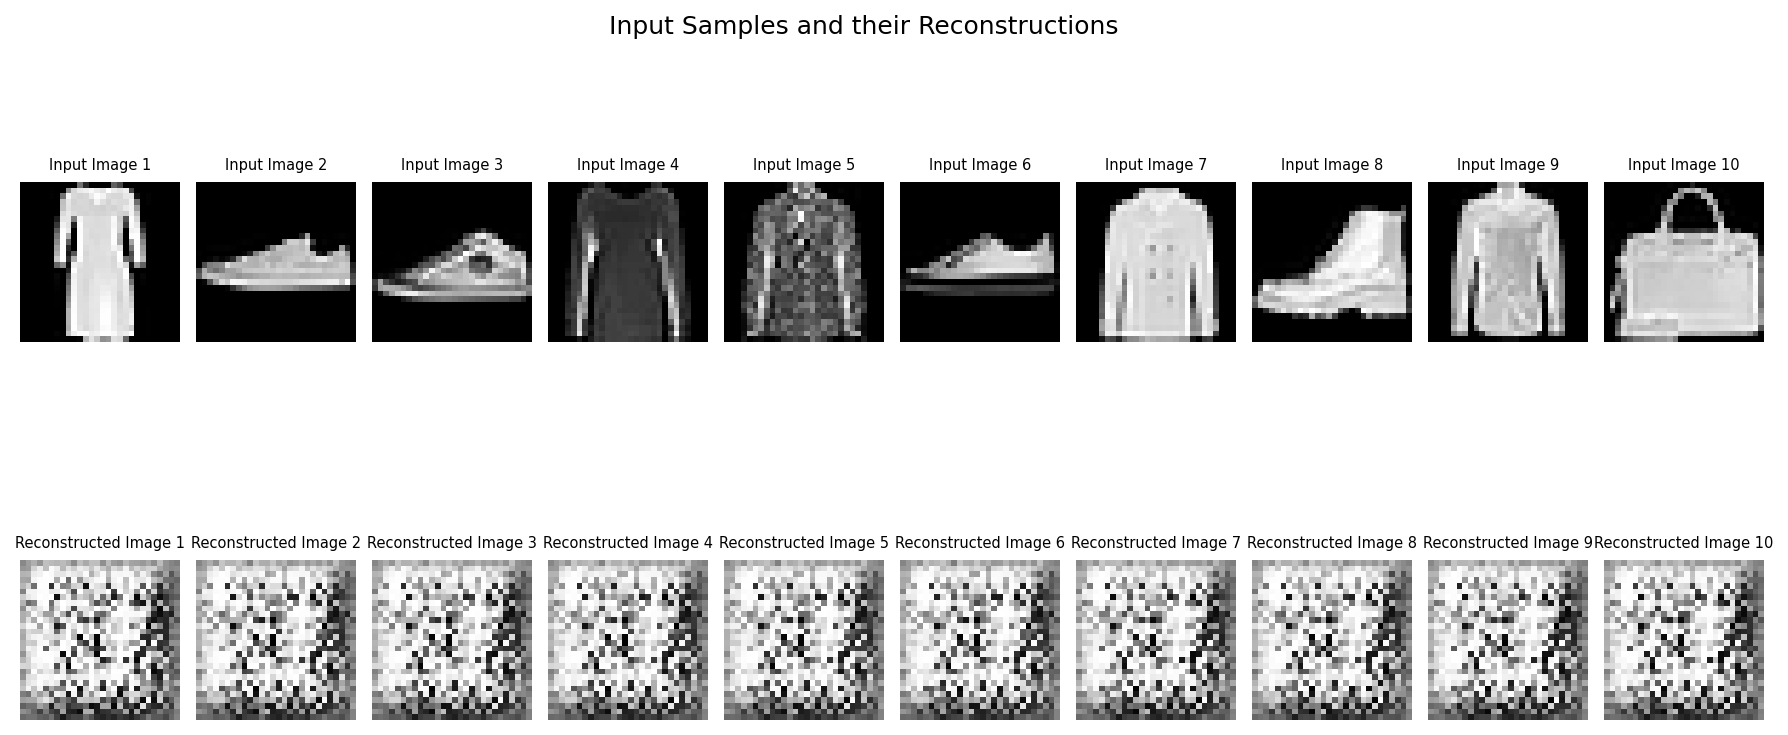

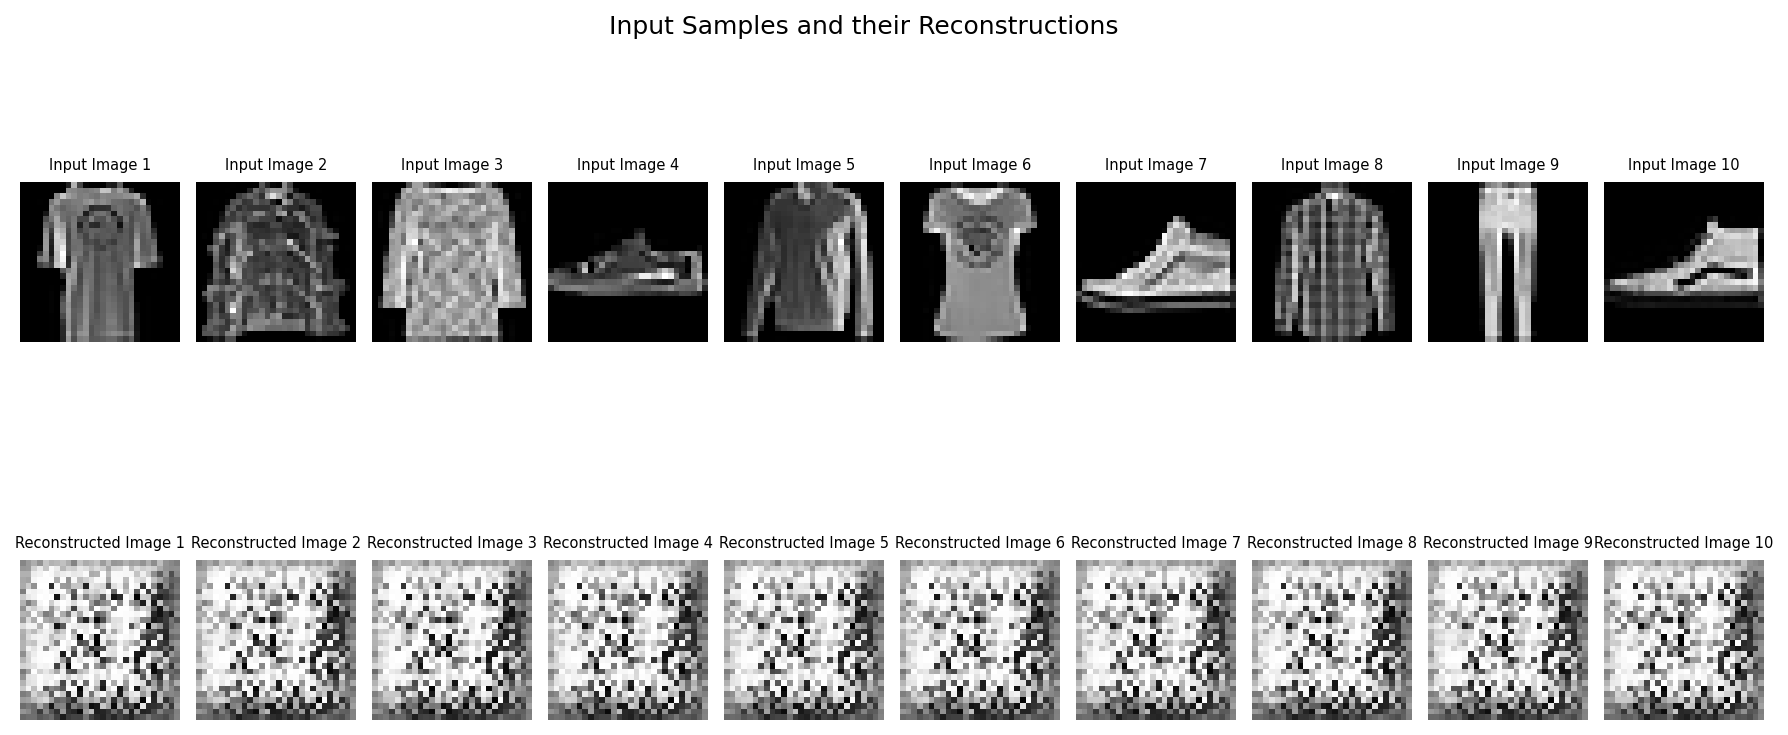

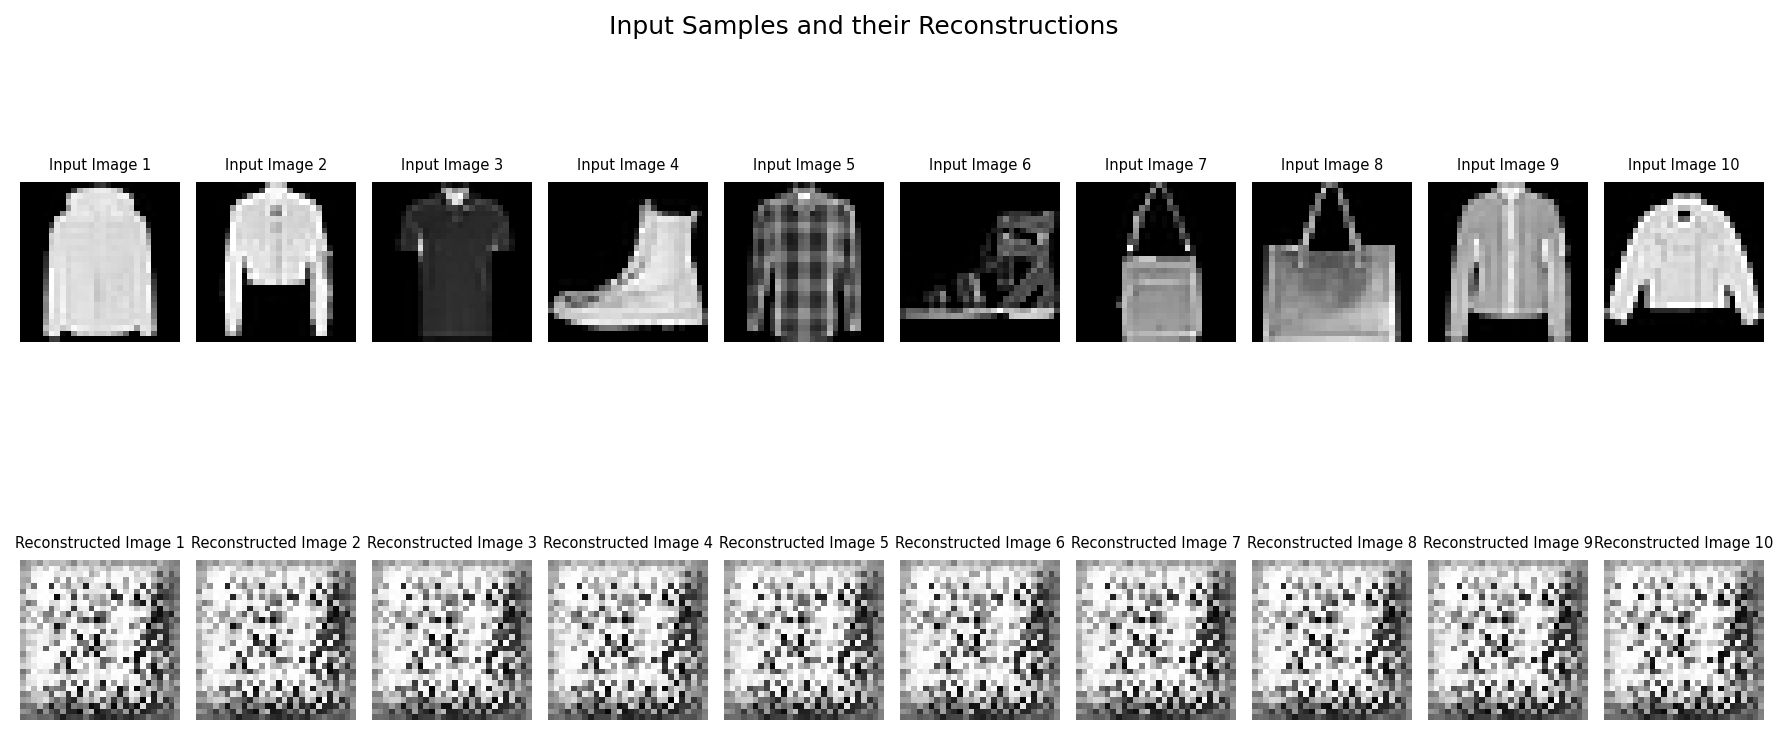

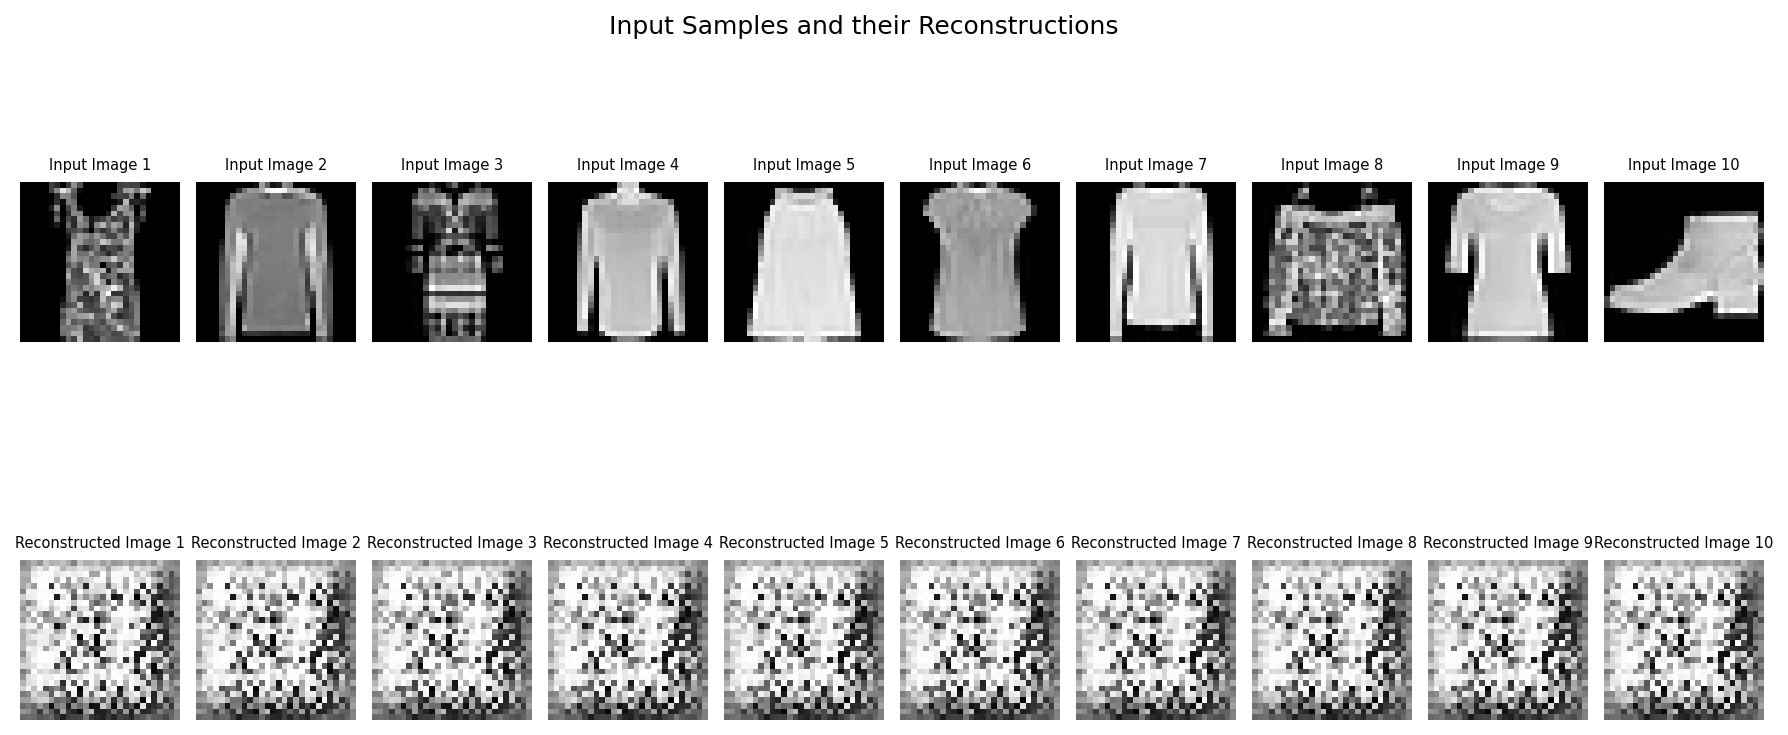

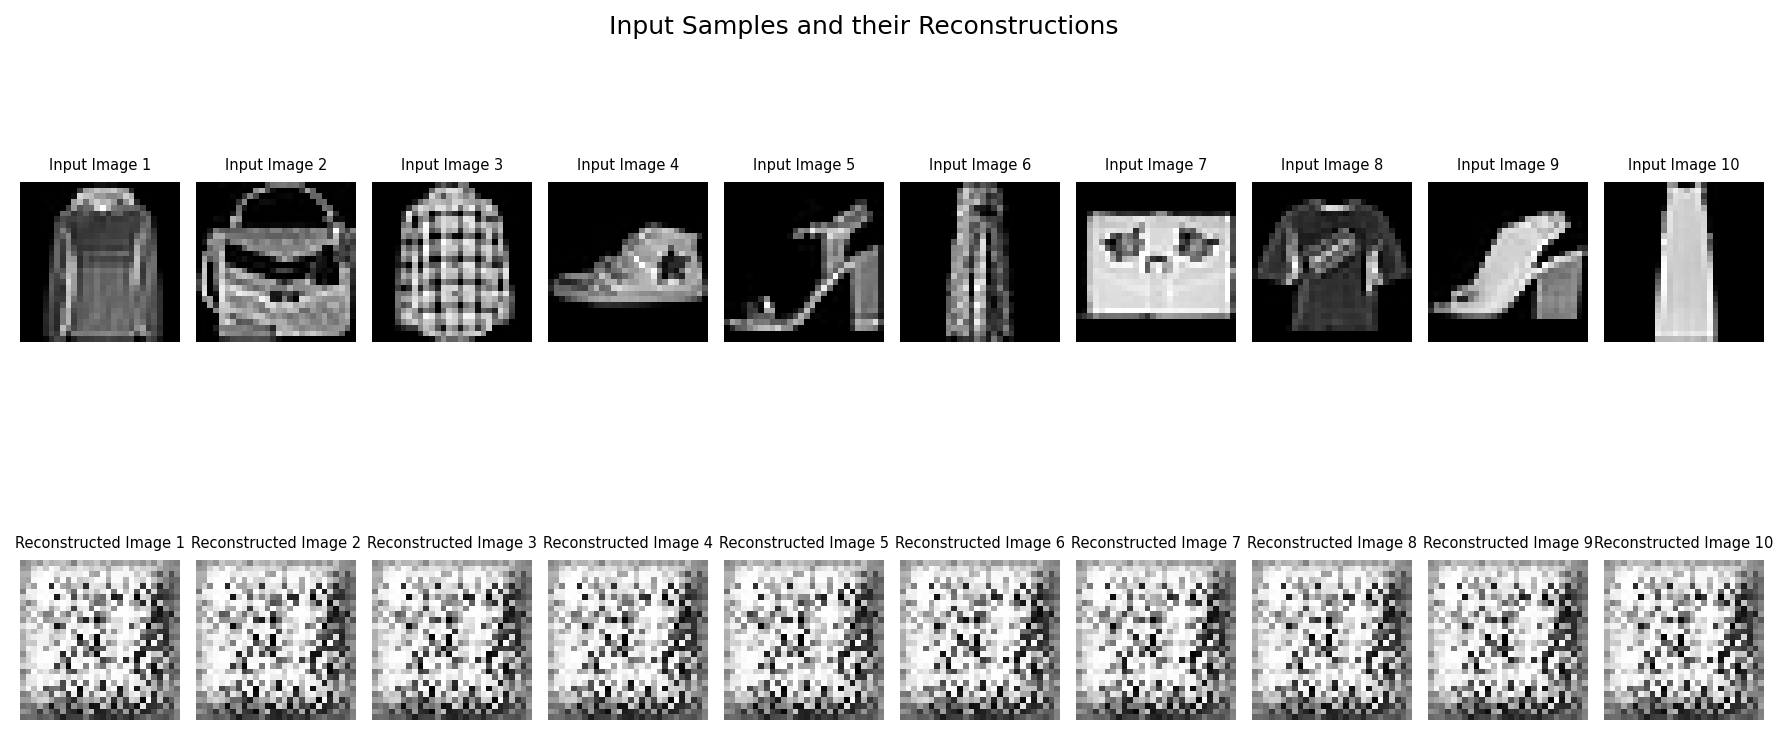

Epoch 1/3, Loss: 1.3189


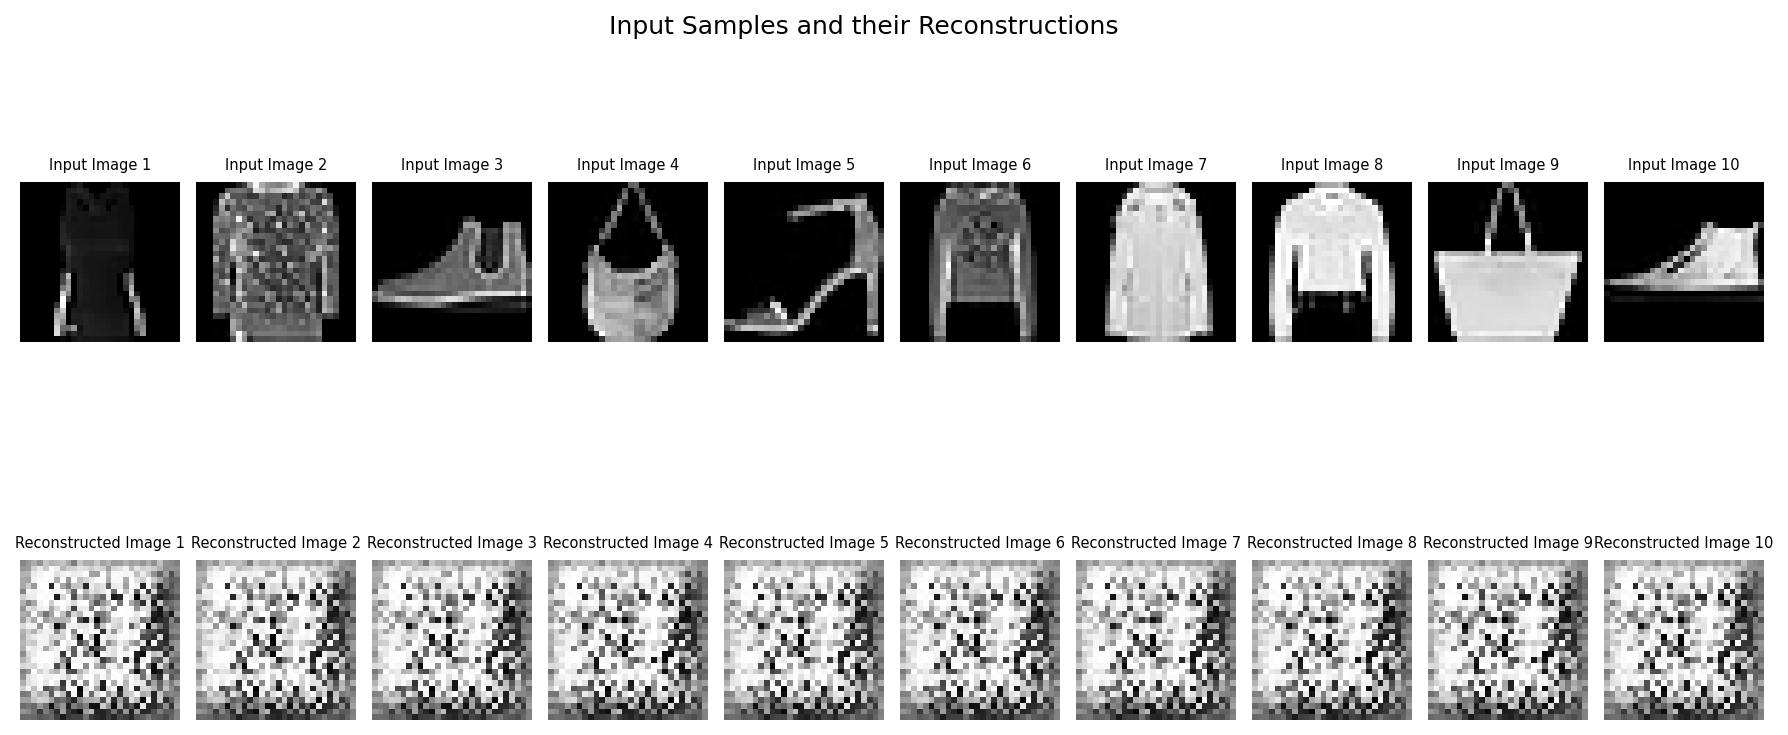

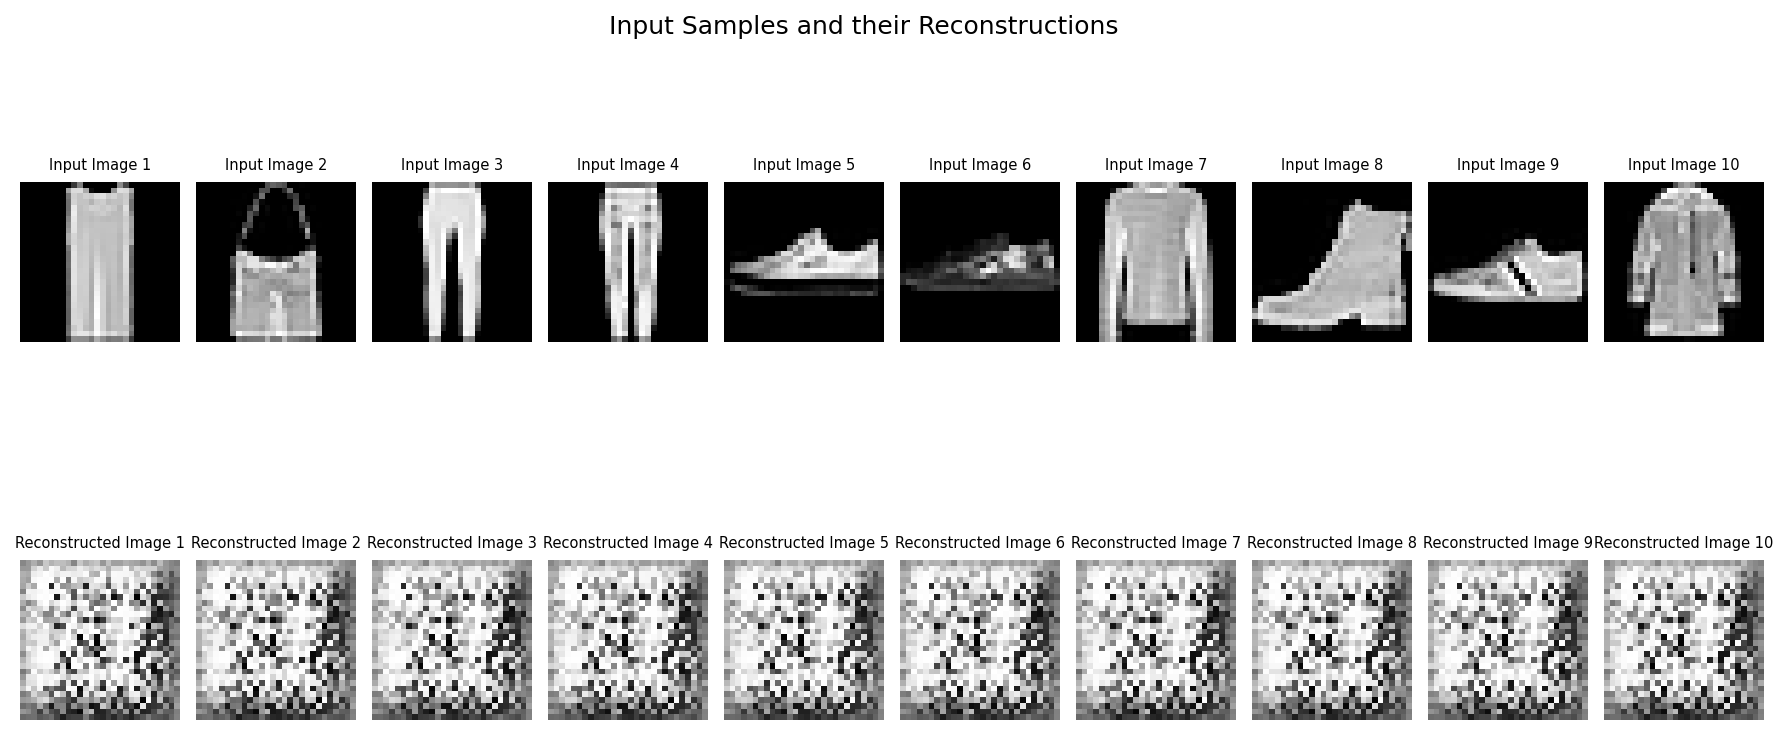

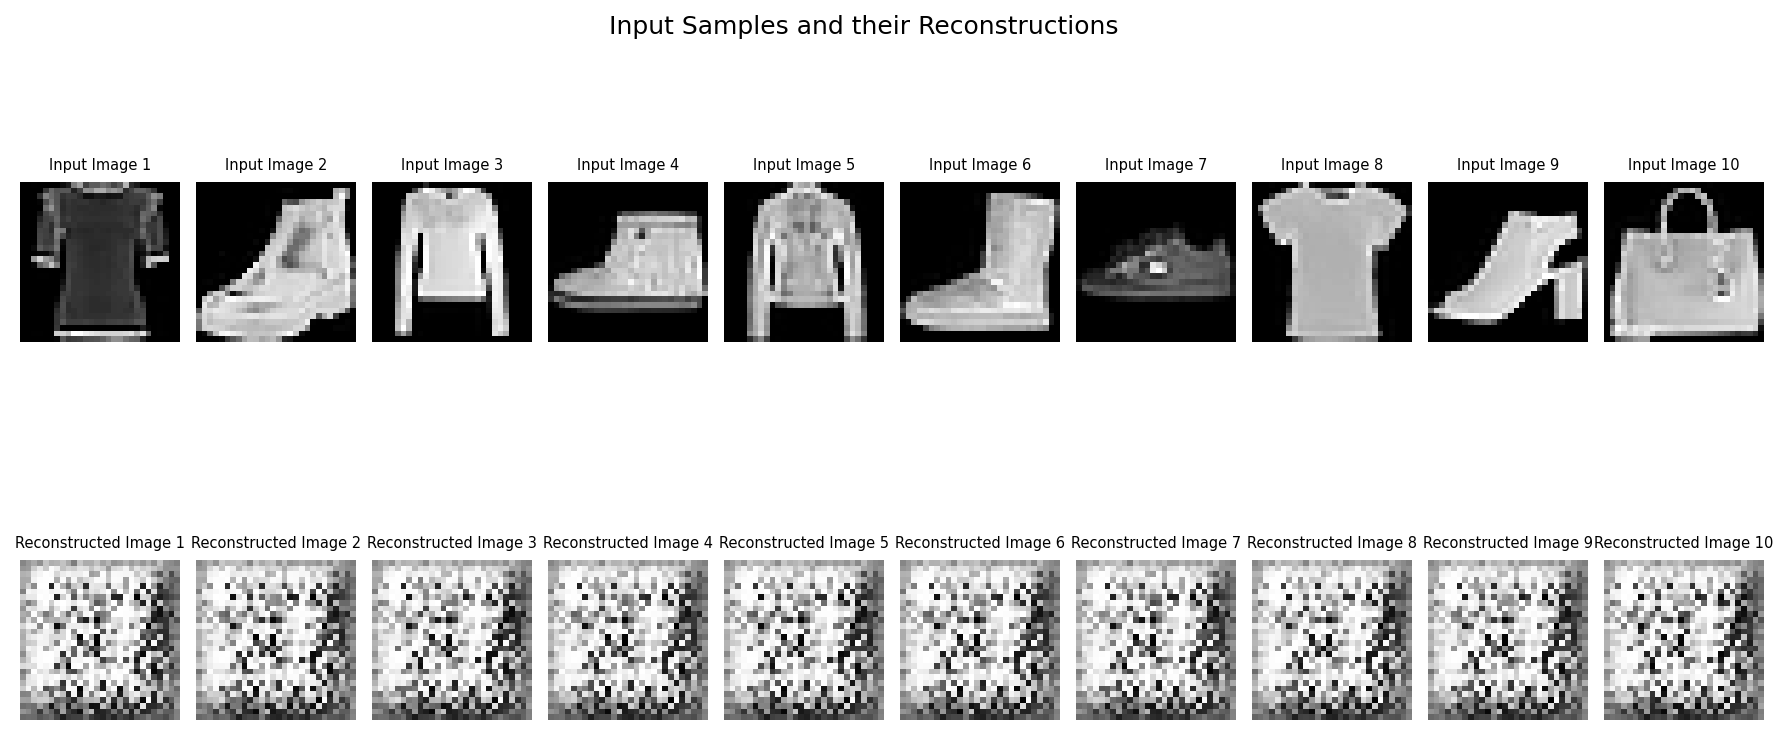

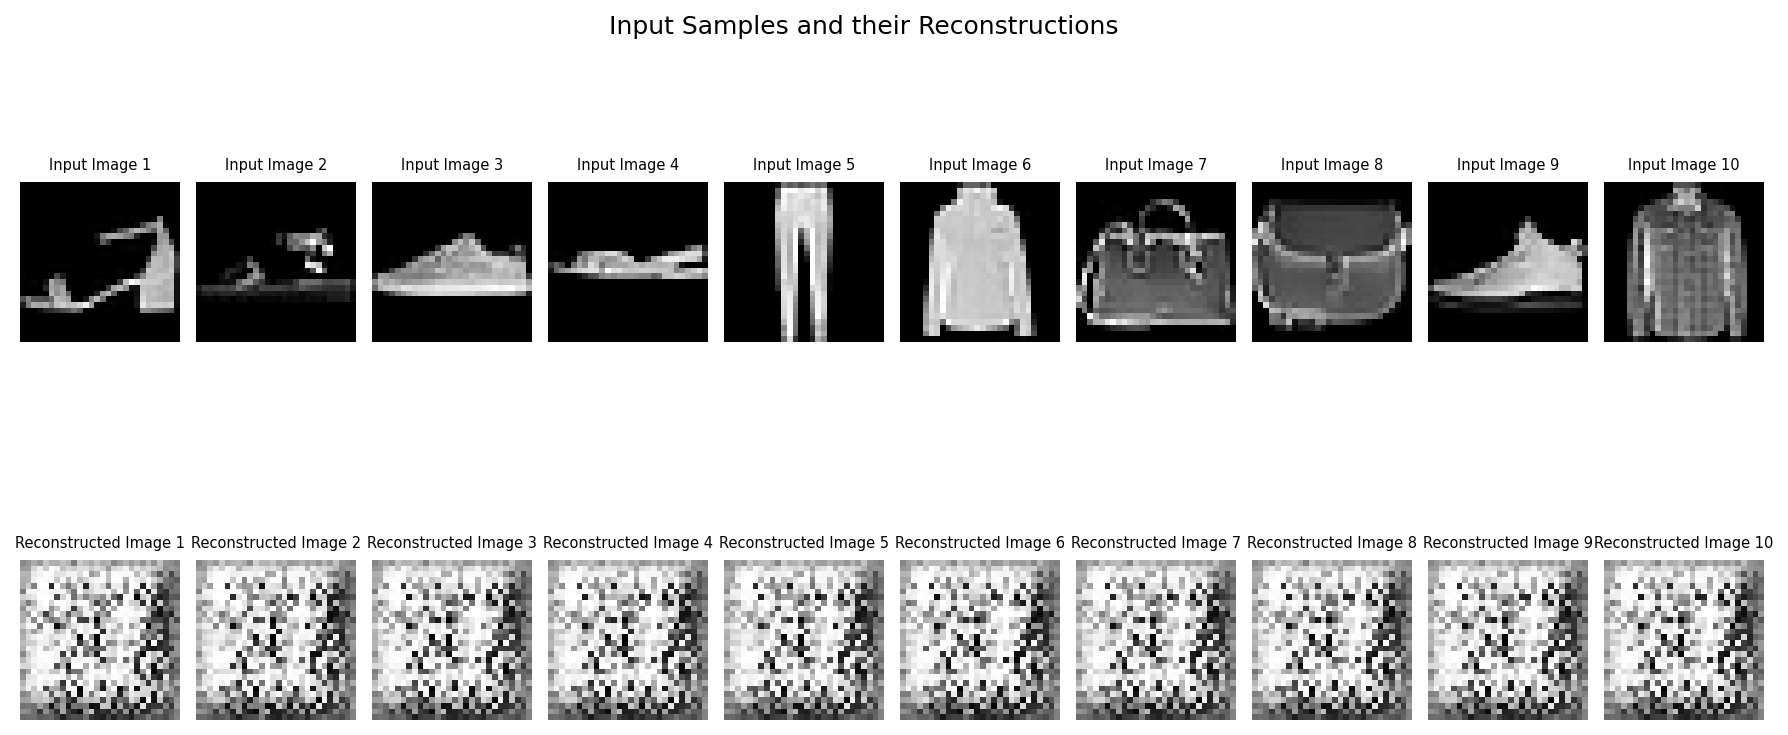

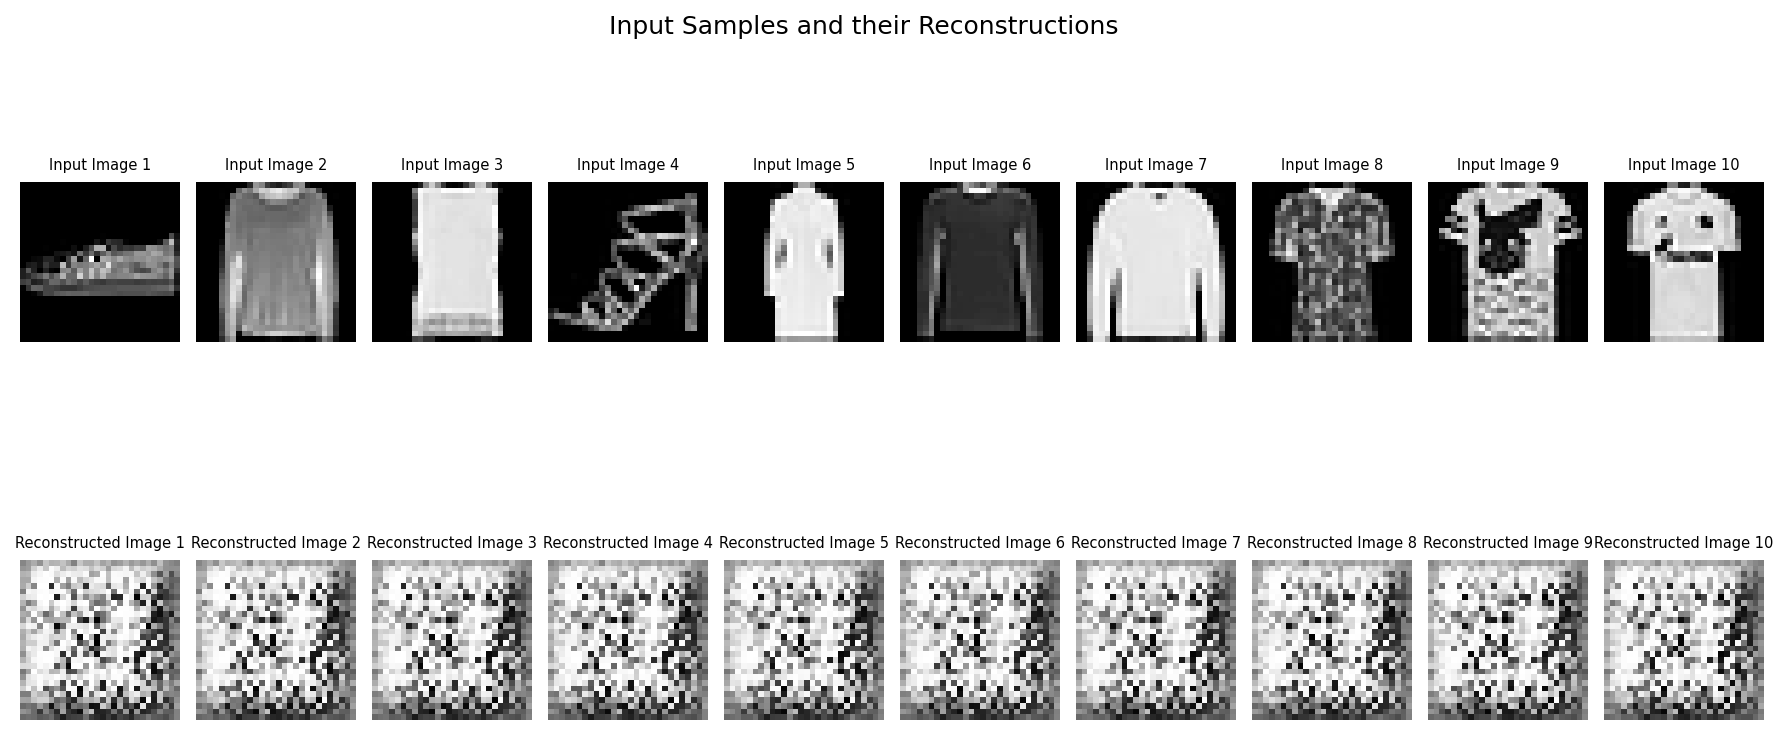

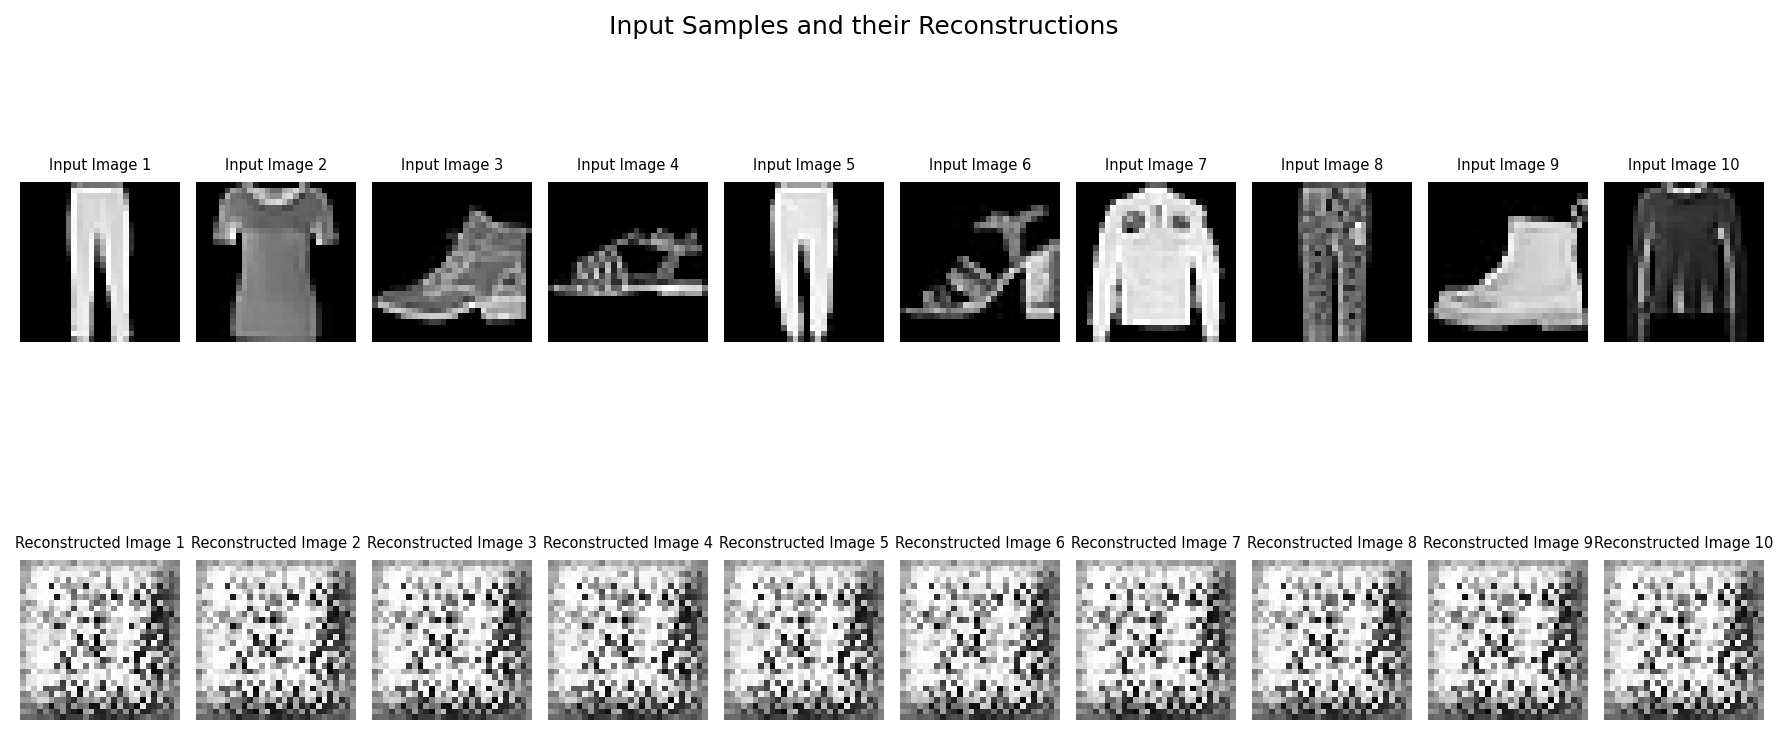

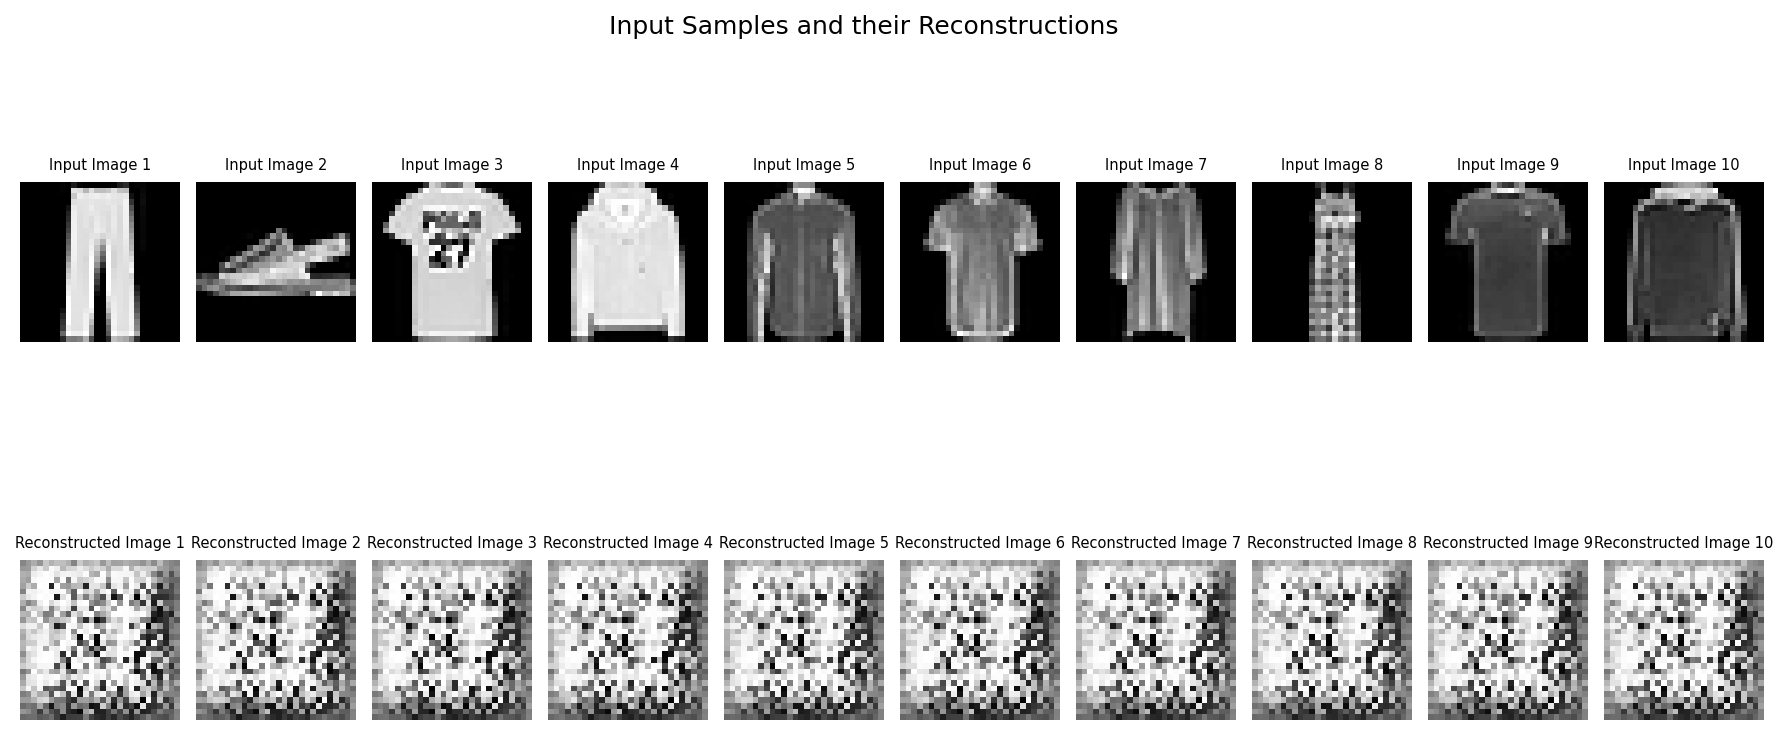

Epoch 2/3, Loss: 1.3199


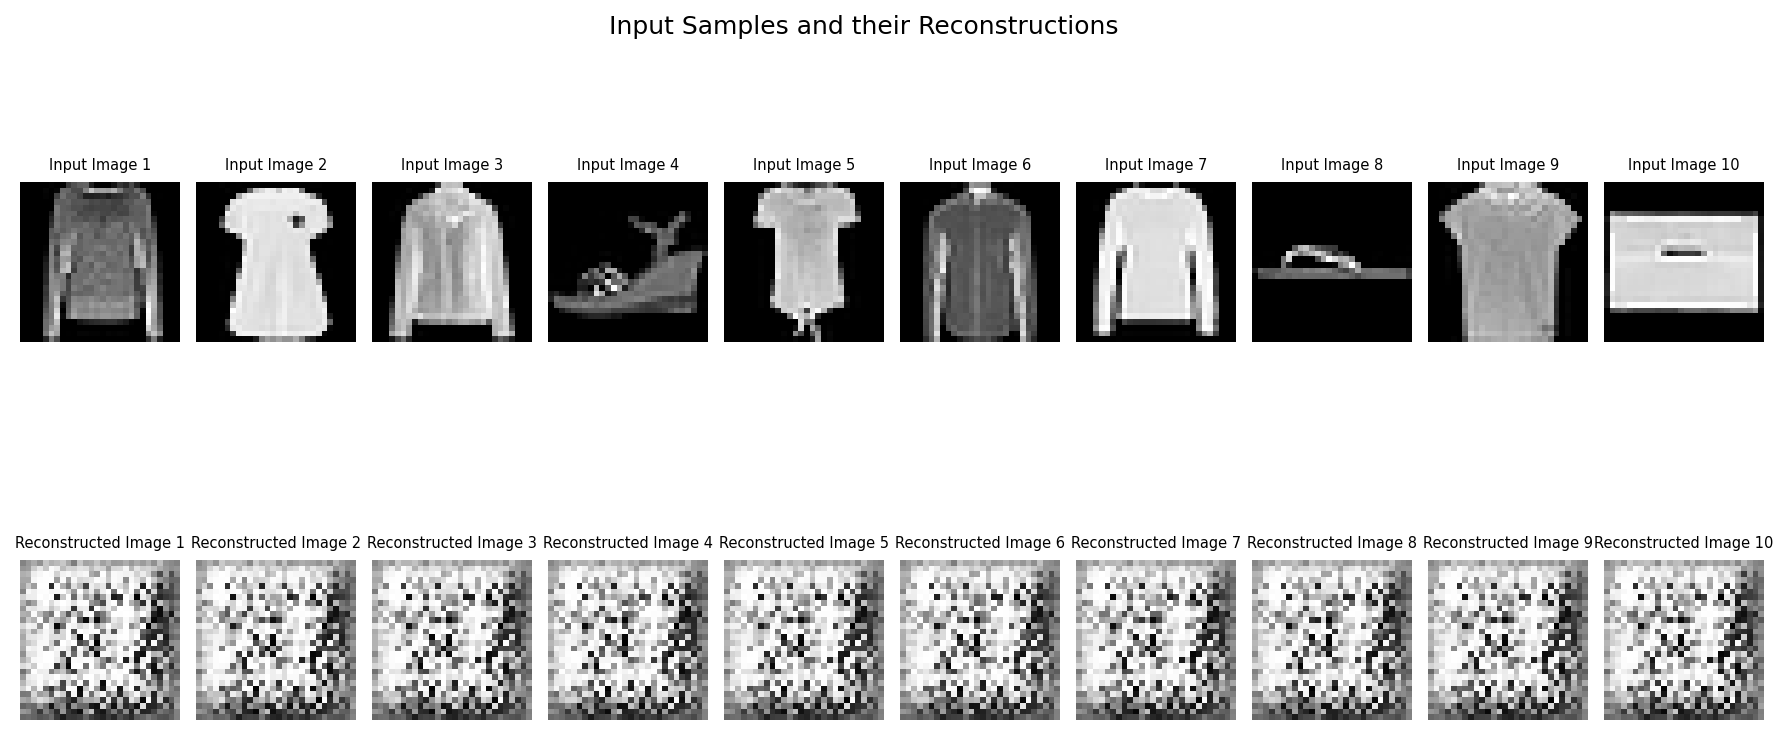

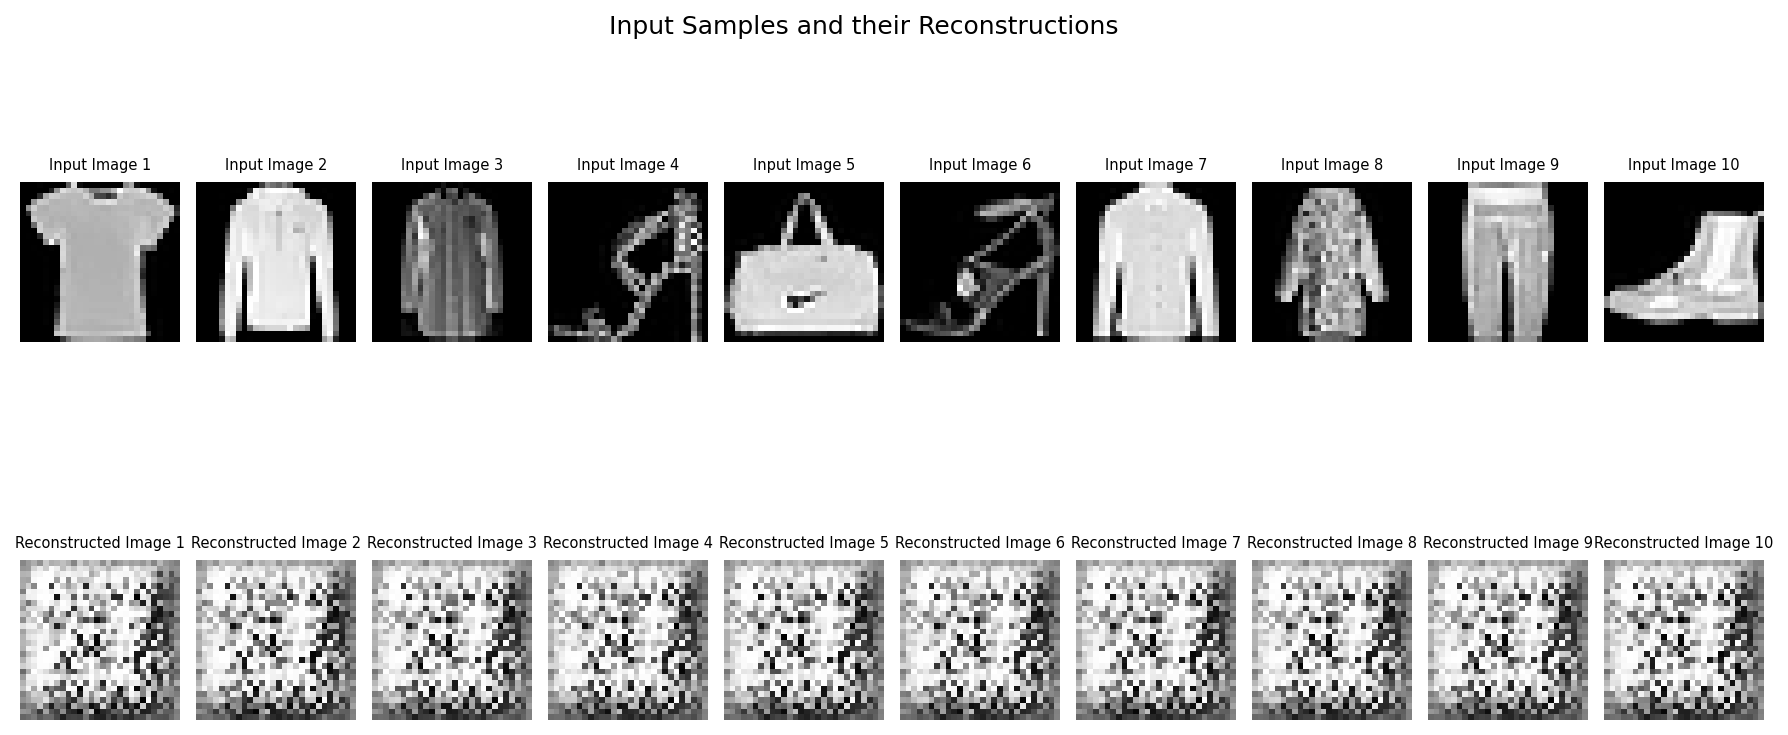

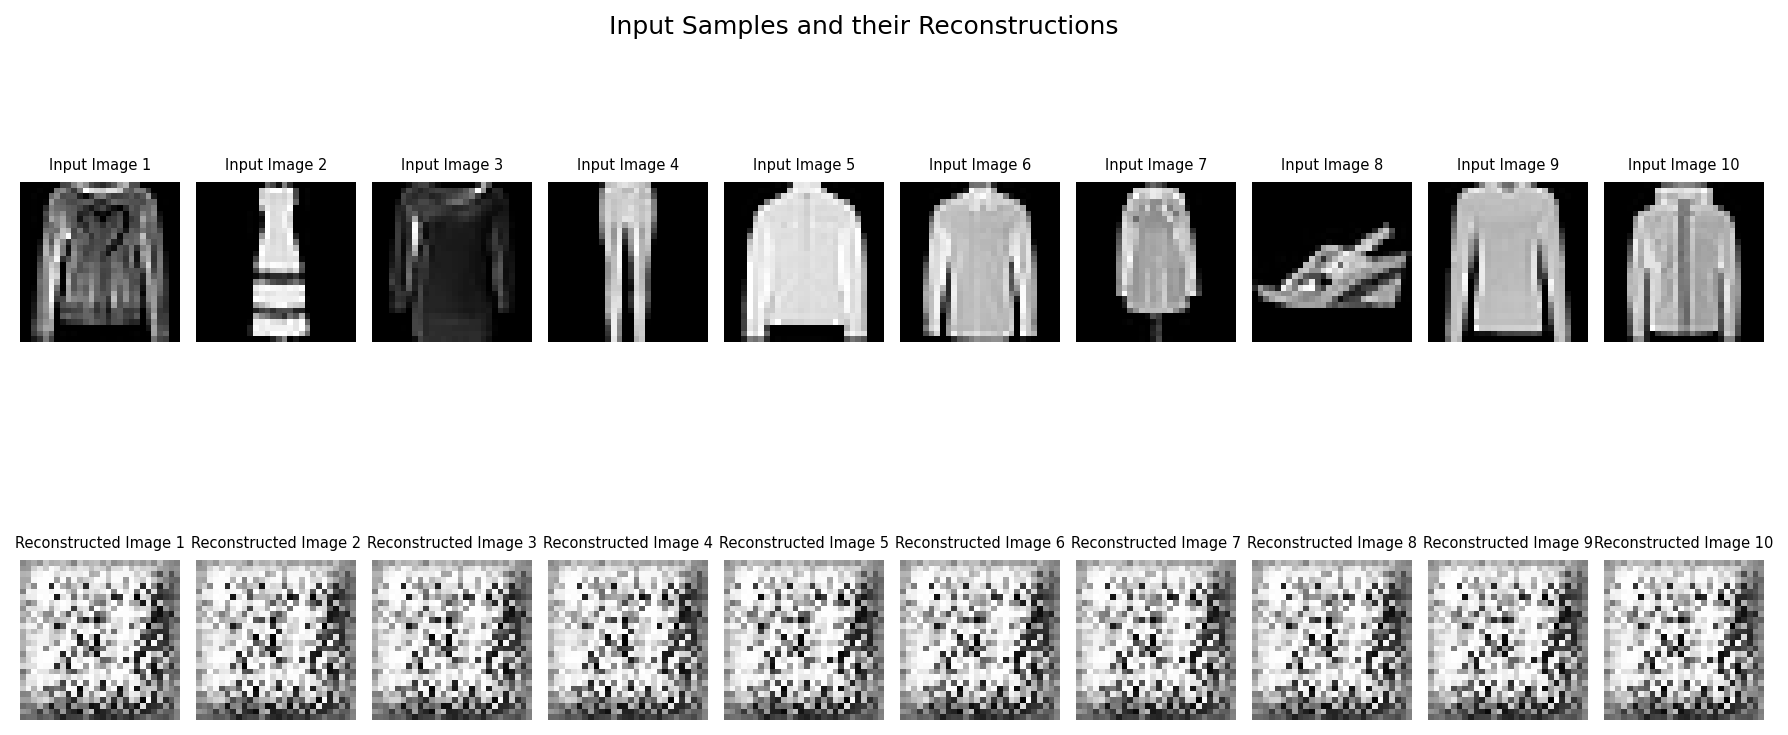

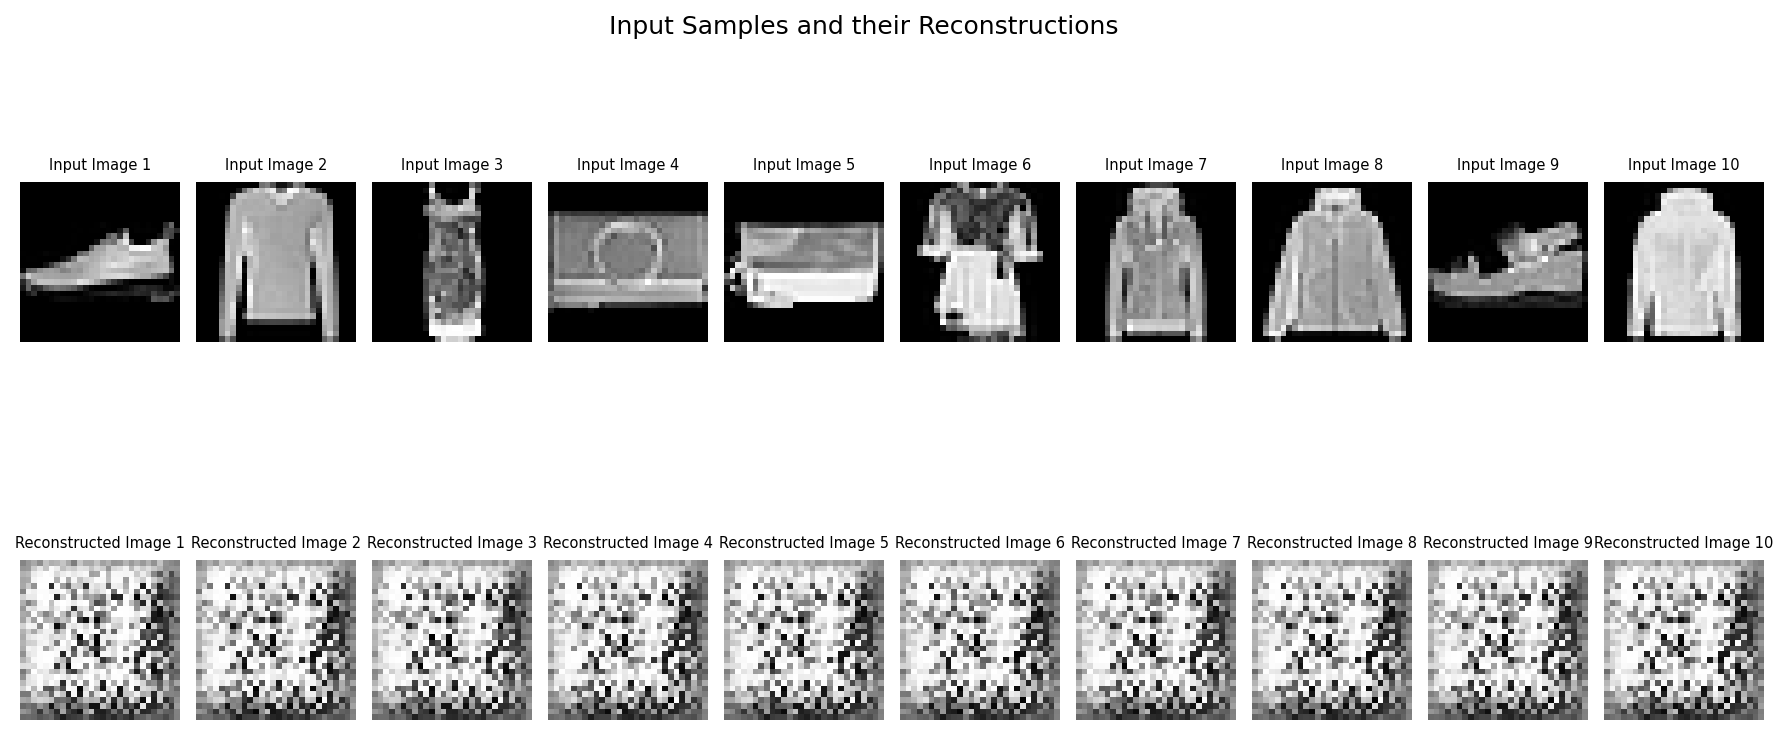

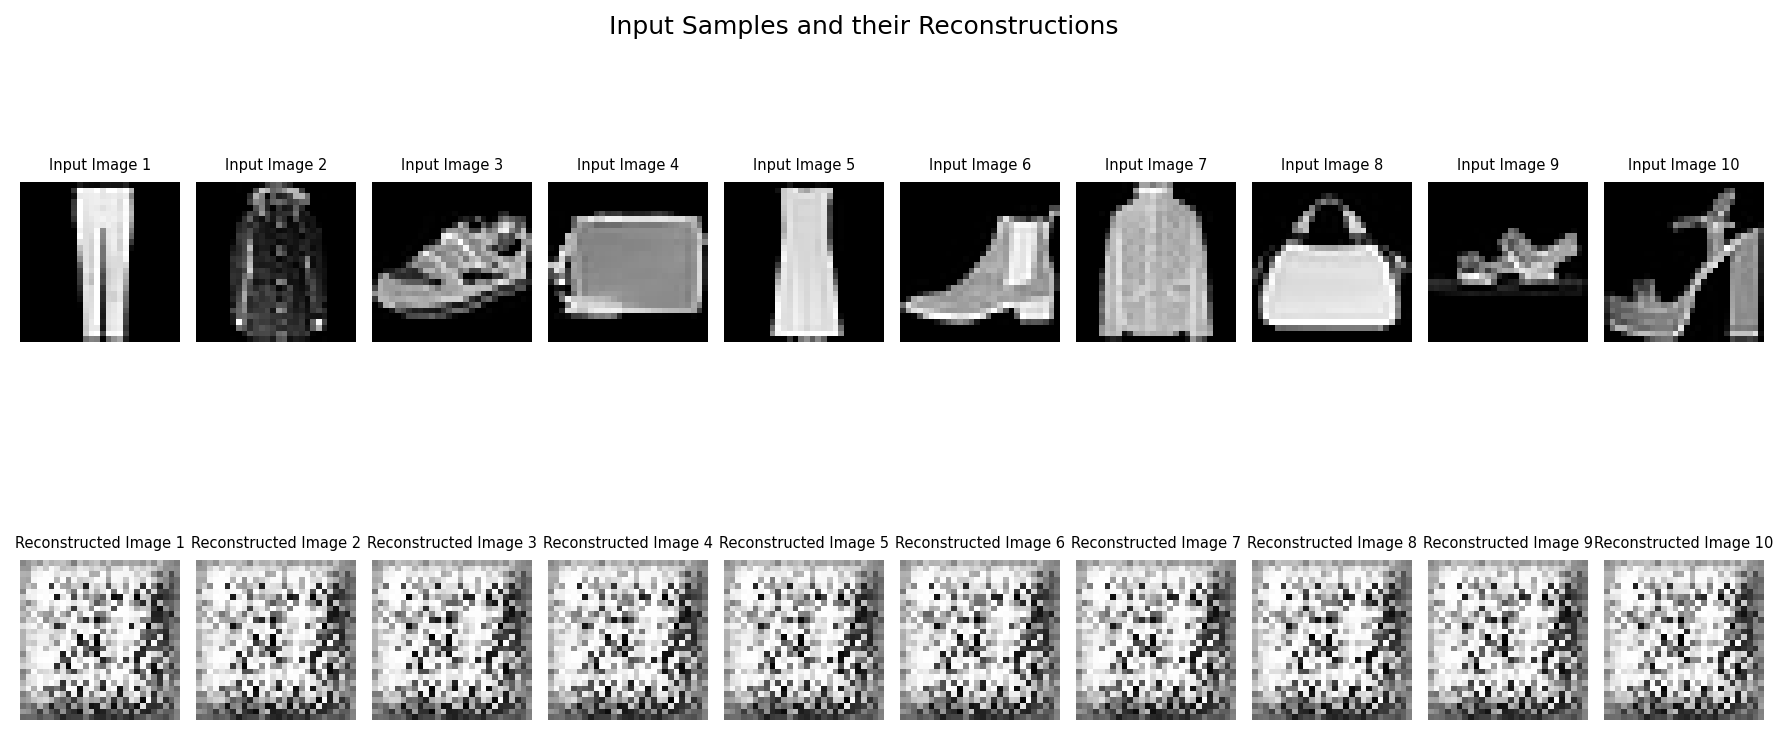

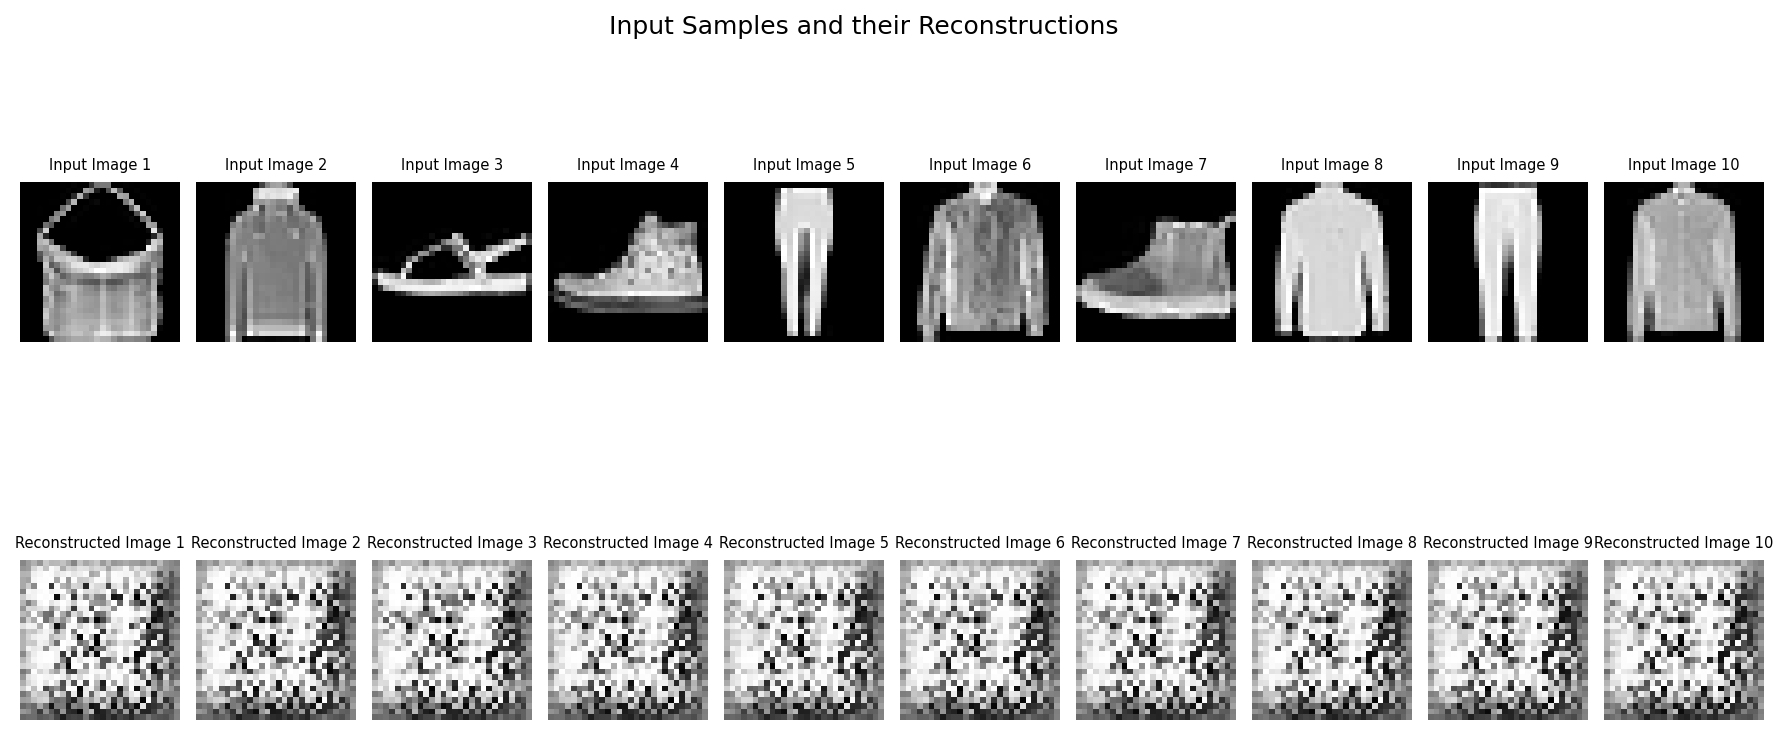

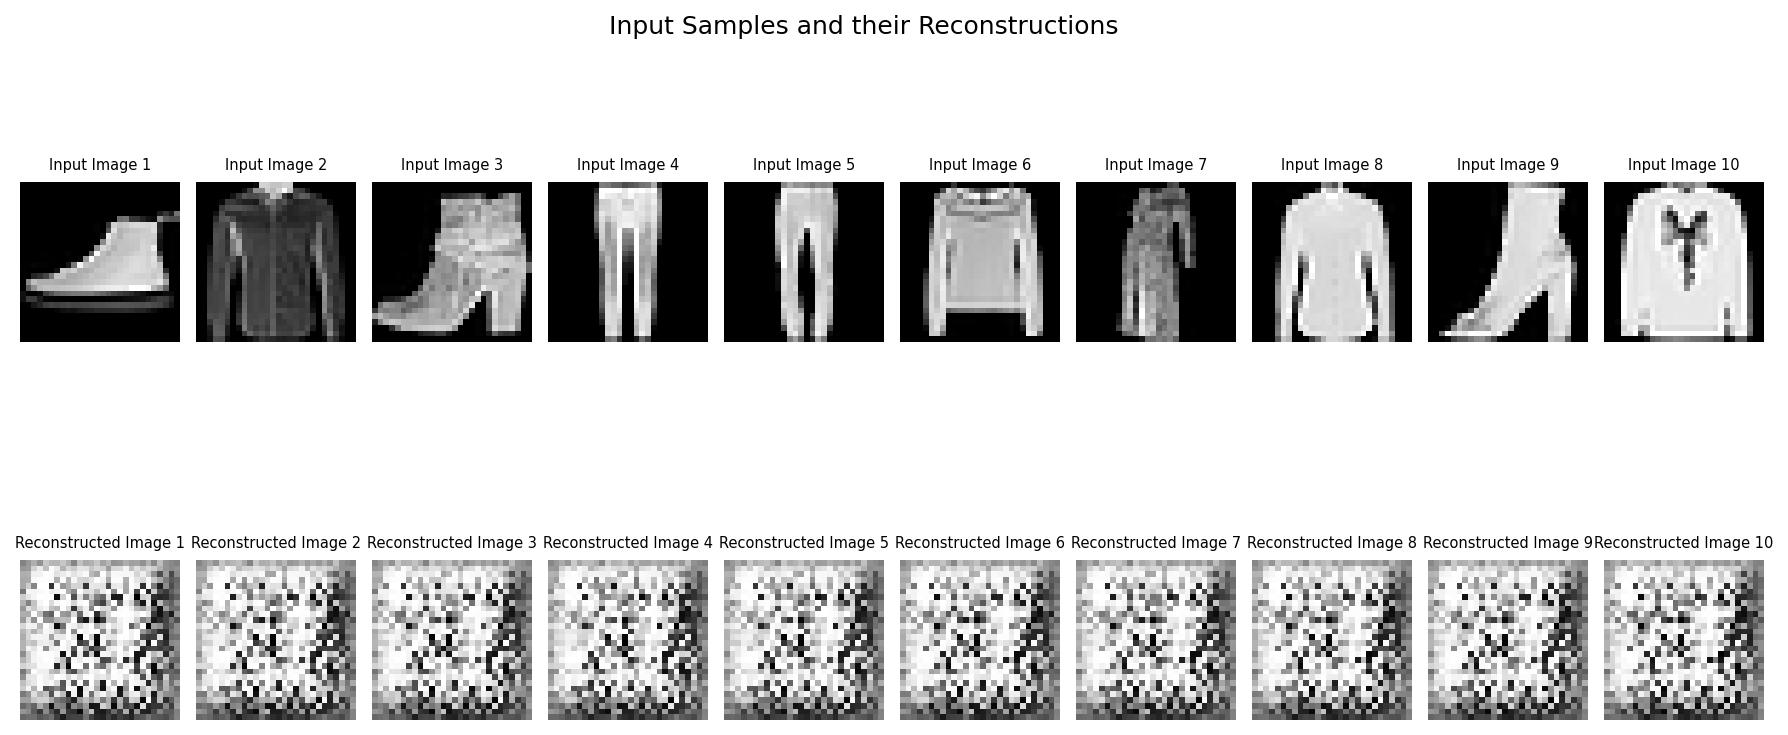

Epoch 3/3, Loss: 1.3189


In [31]:
# test model
for epoch in range(EPOCHS_NOISE):
    test_loss = test(denoise_conv_autoencoder, testloader, criterion, device=device)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{EPOCHS_NOISE}, Loss: {test_loss:.4f}')

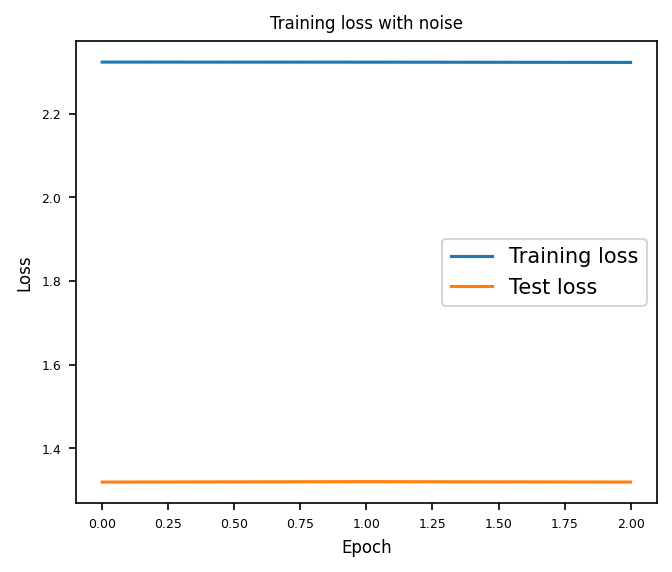

In [32]:
# Plot the loss curve
plot_loss(train_losses, test_losses, label='Training loss with noise', path=RESULTS_DIR+'conv_ae_loss_curve_denoise.png')